# IMU Path Length Analysis

This notebook analyzes IMU acceleration data to compute the length of a walking path based on phone movement patterns during walking motion.

## Methodology
1. **Load and process IMU data** (accelerometer + gyroscope if available)
2. **Remove gravity bias** using advanced gravity compensation techniques
3. **Integrate acceleration** to obtain velocity and position trajectories
4. **Compute path length** from the accumulated distance traveled
5. **Validate results** with multiple approaches and error analysis

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import cumulative_trapezoid, cumulative_simpson
from scipy.ndimage import gaussian_filter1d
import os

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# Configuration: Select which datasets to use
CONFIG = {
    'path_file': 'bjorn_path_new.txt',      # Main path measurement file
    'stationary_file': 'bjorn_stationary_new.txt',  # Stationary reference file
    'integration_method': 'simpson',      # 'trapezoid' or 'simpson'
    'gravity_compensation': 'auto',         # 'static', 'orientation', 'auto'
    'enable_filtering': False,              # Apply low-pass filtering to acceleration
    'filter_cutoff': 2.0,                   # Low-pass filter cutoff frequency (Hz)
    'smoothing_sigma': 2.0,                 # Gaussian smoothing for gravity estimates
    'stationary_threshold': 0.01,           # Gyro threshold for stationary detection (rad/s)
    'print_debug': True                     # Enable debug output
}

print("IMU Path Length Analysis Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print()

IMU Path Length Analysis Configuration:
  path_file: bjorn_path_new.txt
  stationary_file: bjorn_stationary_new.txt
  integration_method: simpson
  gravity_compensation: auto
  enable_filtering: False
  filter_cutoff: 2.0
  smoothing_sigma: 2.0
  stationary_threshold: 0.01
  print_debug: True



In [197]:
def load_imu_data_enhanced(filepath):
    """
    Load IMU data from text file with support for both accelerometer and gyroscope data
    Returns: (merged_dataframe, has_gyro, gyro_dataframe)
    """
    acc_data = []
    gyro_data = []
    
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 5:
                    timestamp = int(parts[0])
                    if parts[1] == 'ACC':
                        acc_x = float(parts[2])
                        acc_y = float(parts[3])
                        acc_z = float(parts[4])
                        acc_data.append([timestamp, acc_x, acc_y, acc_z])
                    elif parts[1] == 'GYR':
                        gyro_x = float(parts[2])
                        gyro_y = float(parts[3])
                        gyro_z = float(parts[4])
                        gyro_data.append([timestamp, gyro_x, gyro_y, gyro_z])
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
        return None, False, None
    
    # Create accelerometer DataFrame
    if not acc_data:
        print(f"No accelerometer data found in {filepath}")
        return None, False, None
        
    acc_df = pd.DataFrame(acc_data, columns=['timestamp', 'acc_x', 'acc_y', 'acc_z'])
    acc_df['time'] = (acc_df['timestamp'] - acc_df['timestamp'].iloc[0]) / 1000.0
    
    # Create gyroscope DataFrame if data exists
    has_gyro = len(gyro_data) > 0
    gyro_df = None
    
    if has_gyro:
        gyro_df = pd.DataFrame(gyro_data, columns=['timestamp', 'gyro_x', 'gyro_y', 'gyro_z'])
        gyro_df['time'] = (gyro_df['timestamp'] - gyro_df['timestamp'].iloc[0]) / 1000.0
        
        # Interpolate gyro data to match accelerometer timestamps
        merged_df = acc_df.copy()
        merged_df['gyro_x'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_x'])
        merged_df['gyro_y'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_y'])
        merged_df['gyro_z'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_z'])
        
        return merged_df, has_gyro, gyro_df
    else:
        return acc_df, has_gyro, None

def detect_stationary_periods_robust(acc_data, gyro_data=None, 
                                   gyro_threshold=0.01, 
                                   acc_var_threshold=0.1,
                                   gravity_tolerance=0.5,
                                   window_size=50):
    """
    Robust stationary period detection using both accelerometer and gyroscope
    """
    n_samples = len(acc_data)
    stationary_mask = np.zeros(n_samples, dtype=bool)
    
    # Calculate accelerometer magnitude and check if close to gravity
    acc_magnitude = np.sqrt(acc_data['acc_x']**2 + acc_data['acc_y']**2 + acc_data['acc_z']**2)
    gravity_condition = np.abs(acc_magnitude - 9.81) < gravity_tolerance
    
    # Calculate accelerometer variance (low variance indicates stationary)
    acc_var = np.zeros(n_samples)
    for i in range(window_size//2, n_samples - window_size//2):
        window_start = i - window_size//2
        window_end = i + window_size//2
        window_acc = acc_data[['acc_x', 'acc_y', 'acc_z']].iloc[window_start:window_end]
        acc_var[i] = np.mean(np.var(window_acc, axis=0))
    
    acc_var_condition = acc_var < acc_var_threshold
    
    if gyro_data is not None:
        # Use gyroscope for more accurate stationary detection
        gyro_magnitude = np.sqrt(gyro_data['gyro_x']**2 + gyro_data['gyro_y']**2 + gyro_data['gyro_z']**2)
        gyro_condition = gyro_magnitude < gyro_threshold
        
        # Combine all conditions
        stationary_mask = gravity_condition & acc_var_condition & gyro_condition
        
        if CONFIG['print_debug']:
            print(f"Stationary detection with gyroscope:")
            print(f"  Gyro threshold: {gyro_threshold} rad/s")
            print(f"  Acc variance threshold: {acc_var_threshold}")
            print(f"  Gravity tolerance: ±{gravity_tolerance} m/s²")
    else:
        # Use only accelerometer-based detection
        stationary_mask = gravity_condition & acc_var_condition
        
        if CONFIG['print_debug']:
            print(f"Stationary detection without gyroscope:")
            print(f"  Acc variance threshold: {acc_var_threshold}")
            print(f"  Gravity tolerance: ±{gravity_tolerance} m/s²")
    
    # Apply smoothing to stationary mask
    stationary_smooth = pd.Series(stationary_mask.astype(float)).rolling(
        window=window_size, center=True, min_periods=1).mean()
    final_stationary = stationary_smooth > 0.7
    
    if CONFIG['print_debug']:
        print(f"  Found {final_stationary.sum()} stationary samples out of {n_samples} ({100*final_stationary.sum()/n_samples:.1f}%)")
    
    return final_stationary, acc_magnitude, acc_var

# Load the configured datasets
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")
print(f"Loading datasets with configuration:")
print(f"  Path file: {CONFIG['path_file']}")
print(f"  Stationary file: {CONFIG['stationary_file']}")
print()

Current working directory: /media/shekharu/DATA/OneDrive/SMaRC PhD/Courses/WASP Autonomous Systems/imu-inchtape/path-data
Loading datasets with configuration:
  Path file: bjorn_path_new.txt
  Stationary file: bjorn_stationary_new.txt



In [198]:
# Load the datasets
path_data, path_has_gyro, path_gyro_df = load_imu_data_enhanced(CONFIG['path_file'])
stationary_data, stationary_has_gyro, stationary_gyro_df = load_imu_data_enhanced(CONFIG['stationary_file'])

if path_data is None:
    raise ValueError(f"Could not load path data from {CONFIG['path_file']}")

print("=== DATASET LOADING RESULTS ===")
print(f"Path data: {len(path_data)} samples, duration: {path_data['time'].iloc[-1]:.1f}s, has gyro: {path_has_gyro}")

if stationary_data is not None:
    print(f"Stationary data: {len(stationary_data)} samples, duration: {stationary_data['time'].iloc[-1]:.1f}s, has gyro: {stationary_has_gyro}")
else:
    print("Warning: No stationary reference data available")

# Store datasets in a unified structure
datasets = {
    'path': {
        'data': path_data,
        'has_gyro': path_has_gyro,
        'gyro_data': path_gyro_df,
        'type': 'motion',
        'name': 'Path Motion Data'
    }
}

if stationary_data is not None:
    datasets['stationary'] = {
        'data': stationary_data,
        'has_gyro': stationary_has_gyro,
        'gyro_data': stationary_gyro_df,
        'type': 'stationary', 
        'name': 'Stationary Reference Data'
    }

print(f"\nLoaded {len(datasets)} datasets successfully")
print()

=== DATASET LOADING RESULTS ===
Path data: 35856 samples, duration: 180.8s, has gyro: False
Stationary data: 1638 samples, duration: 8.3s, has gyro: False

Loaded 2 datasets successfully



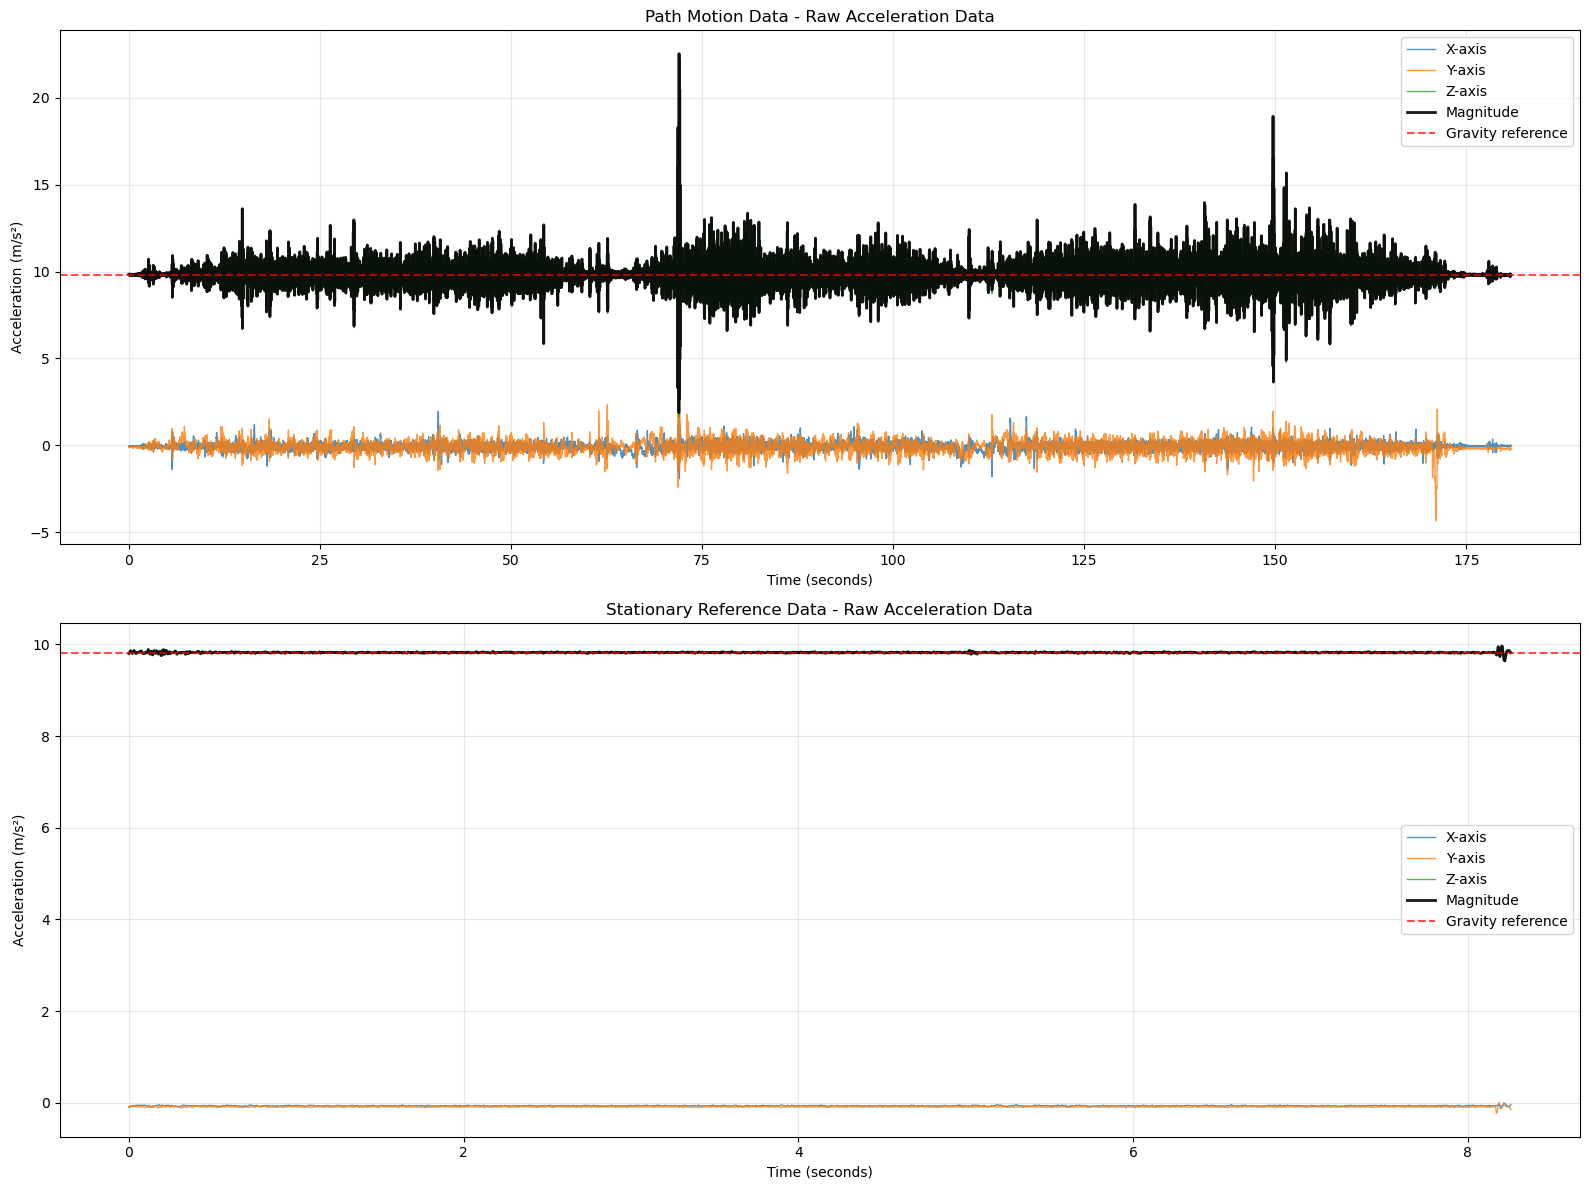

Raw acceleration data visualization complete
Expected gravity magnitude: ~9.81 m/s²
Path data acceleration magnitude: mean=9.83, std=0.65 m/s²


In [199]:
# Visualize raw acceleration data
fig, axes = plt.subplots(len(datasets), 1, figsize=(16, 6*len(datasets)))

if len(datasets) == 1:
    axes = [axes]

for i, (key, dataset_info) in enumerate(datasets.items()):
    data = dataset_info['data']
    title = dataset_info['name']
    
    ax = axes[i]
    ax.plot(data['time'], data['acc_x'], label='X-axis', alpha=0.8, linewidth=1)
    ax.plot(data['time'], data['acc_y'], label='Y-axis', alpha=0.8, linewidth=1)
    ax.plot(data['time'], data['acc_z'], label='Z-axis', alpha=0.8, linewidth=1)
    
    # Show acceleration magnitude
    acc_magnitude = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
    ax.plot(data['time'], acc_magnitude, label='Magnitude', alpha=0.9, linewidth=2, color='black')
    ax.axhline(y=9.81, color='red', linestyle='--', alpha=0.7, label='Gravity reference')
    
    ax.set_title(f'{title} - Raw Acceleration Data')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Acceleration (m/s²)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Raw acceleration data visualization complete")
print(f"Expected gravity magnitude: ~9.81 m/s²")
if 'path' in datasets:
    path_acc_mag = np.sqrt(datasets['path']['data']['acc_x']**2 + 
                          datasets['path']['data']['acc_y']**2 + 
                          datasets['path']['data']['acc_z']**2)
    print(f"Path data acceleration magnitude: mean={path_acc_mag.mean():.2f}, std={path_acc_mag.std():.2f} m/s²")

## Gravity Compensation

We'll implement multiple gravity compensation strategies:

1. **Static Bias Removal**: Use stationary reference data to estimate constant gravity bias
2. **Orientation-Based Compensation**: Use gyroscope integration to track device orientation changes (improved from IMU tricks)
3. **Auto Selection**: Automatically choose the best method based on available sensor data

The goal is to remove the gravity component from acceleration measurements to isolate the motion-induced accelerations.

In [200]:
def estimate_static_gravity_bias(stationary_data, use_robust_method=True):
    """
    Estimate gravity bias from stationary data using robust statistical methods
    """
    if stationary_data is None:
        return None, None, None
    
    if use_robust_method:
        # Use median for robustness against outliers
        gravity_x = stationary_data['acc_x'].median()
        gravity_y = stationary_data['acc_y'].median() 
        gravity_z = stationary_data['acc_z'].median()
        
        if CONFIG['print_debug']:
            print("Static gravity estimation (robust median):")
    else:
        # Use mean for traditional approach
        gravity_x = stationary_data['acc_x'].mean()
        gravity_y = stationary_data['acc_y'].mean()
        gravity_z = stationary_data['acc_z'].mean()
        
        if CONFIG['print_debug']:
            print("Static gravity estimation (mean):")
    
    gravity_magnitude = np.sqrt(gravity_x**2 + gravity_y**2 + gravity_z**2)
    
    if CONFIG['print_debug']:
        print(f"  Gravity vector: ({gravity_x:.3f}, {gravity_y:.3f}, {gravity_z:.3f}) m/s²")
        print(f"  Gravity magnitude: {gravity_magnitude:.3f} m/s²")
        print(f"  Deviation from 9.81: {abs(gravity_magnitude - 9.81):.3f} m/s²")
    
    return gravity_x, gravity_y, gravity_z

def estimate_gravity_from_stationary_periods(acc_data, gyro_data=None):
    """
    Estimate gravity by identifying stationary periods within the motion data
    """
    stationary_mask, acc_mag, acc_var = detect_stationary_periods_robust(
        acc_data, gyro_data, 
        gyro_threshold=CONFIG['stationary_threshold'],
        window_size=50
    )
    
    if stationary_mask.sum() < 10:  # Need at least 10 stationary samples
        if CONFIG['print_debug']:
            print("Warning: Insufficient stationary periods detected in motion data")
        return None, None, None, None
    
    # Calculate gravity from detected stationary periods
    stationary_acc = acc_data[stationary_mask]
    gravity_x = stationary_acc['acc_x'].median()
    gravity_y = stationary_acc['acc_y'].median()
    gravity_z = stationary_acc['acc_z'].median()
    
    if CONFIG['print_debug']:
        print(f"Gravity from motion data stationary periods:")
        print(f"  Used {stationary_mask.sum()} stationary samples ({100*stationary_mask.sum()/len(acc_data):.1f}%)")
        print(f"  Gravity vector: ({gravity_x:.3f}, {gravity_y:.3f}, {gravity_z:.3f}) m/s²")
        gravity_magnitude = np.sqrt(gravity_x**2 + gravity_y**2 + gravity_z**2)
        print(f"  Gravity magnitude: {gravity_magnitude:.3f} m/s²")
    
    return gravity_x, gravity_y, gravity_z, stationary_mask

def improved_orientation_based_gravity(acc_data, gyro_data, initial_gravity_norm=9.81):
    """
    Improved orientation-based gravity compensation with better numerical stability
    """
    if gyro_data is None:
        raise ValueError("Gyroscope data required for orientation-based compensation")
    
    # Estimate initial gravity direction from first few samples (assuming initial stationary period)
    initial_window = min(100, len(acc_data) // 10)
    initial_acc = acc_data[['acc_x', 'acc_y', 'acc_z']].iloc[:initial_window].median()
    initial_acc_norm = np.sqrt(initial_acc['acc_x']**2 + initial_acc['acc_y']**2 + initial_acc['acc_z']**2)
    
    if initial_acc_norm > 0:
        gravity_device_initial = np.array([initial_acc['acc_x'], initial_acc['acc_y'], initial_acc['acc_z']]) / initial_acc_norm * initial_gravity_norm
    else:
        gravity_device_initial = np.array([0, 0, initial_gravity_norm])  # fallback
    
    if CONFIG['print_debug']:
        print(f"Improved orientation-based gravity compensation:")
        print(f"  Initial gravity estimate: ({gravity_device_initial[0]:.3f}, {gravity_device_initial[1]:.3f}, {gravity_device_initial[2]:.3f}) m/s²")
    
    # Initialize arrays
    n_samples = len(acc_data)
    gravity_estimates = np.zeros((n_samples, 3))
    gravity_estimates[0] = gravity_device_initial
    
    # Calculate time intervals with better handling
    time_array = acc_data['time'].values
    dt_array = np.diff(time_array)
    dt_array = np.append(dt_array, dt_array[-1])  # Use last interval for final point
    
    # Numerical integration with improved stability
    current_gravity = gravity_device_initial.copy()
    
    for i in range(1, n_samples):
        dt = dt_array[i-1]
        
        # Skip integration if time step is too large (indicates data gap)
        if dt > 0.1:  # 100ms threshold
            gravity_estimates[i] = current_gravity
            continue
            
        # Get gyroscope readings
        omega = np.array([
            gyro_data['gyro_x'].iloc[i],
            gyro_data['gyro_y'].iloc[i],
            gyro_data['gyro_z'].iloc[i]
        ])
        
        omega_magnitude = np.linalg.norm(omega)
        
        # Apply rotation only if significant rotation detected
        if omega_magnitude > 1e-4:  # Threshold to avoid noise amplification
            # Use small-angle approximation for better numerical stability
            if omega_magnitude * dt < 0.1:  # Small angle (< ~6 degrees)
                # Small angle approximation: R ≈ I + [ω]× * dt
                omega_cross = np.array([
                    [0, -omega[2], omega[1]],
                    [omega[2], 0, -omega[0]],
                    [-omega[1], omega[0], 0]
                ]) * dt
                
                current_gravity = current_gravity + omega_cross @ current_gravity
            else:
                # Use Rodrigues' formula for larger rotations
                axis = omega / omega_magnitude
                angle = omega_magnitude * dt
                
                cos_angle = np.cos(angle)
                sin_angle = np.sin(angle)
                
                current_gravity = (current_gravity * cos_angle +
                                 np.cross(axis, current_gravity) * sin_angle +
                                 axis * np.dot(axis, current_gravity) * (1 - cos_angle))
        
        gravity_estimates[i] = current_gravity
    
    # Apply smoothing to reduce integration noise
    gravity_x_smooth = gaussian_filter1d(gravity_estimates[:, 0], sigma=CONFIG['smoothing_sigma'])
    gravity_y_smooth = gaussian_filter1d(gravity_estimates[:, 1], sigma=CONFIG['smoothing_sigma'])
    gravity_z_smooth = gaussian_filter1d(gravity_estimates[:, 2], sigma=CONFIG['smoothing_sigma'])
    
    # Create DataFrame
    gravity_df = pd.DataFrame({
        'time': acc_data['time'],
        'gravity_x': gravity_x_smooth,
        'gravity_y': gravity_y_smooth,
        'gravity_z': gravity_z_smooth
    })
    
    if CONFIG['print_debug']:
        gravity_magnitude = np.sqrt(gravity_x_smooth**2 + gravity_y_smooth**2 + gravity_z_smooth**2)
        print(f"  Final gravity magnitude: mean={gravity_magnitude.mean():.3f}, std={gravity_magnitude.std():.3f} m/s²")
        print(f"  Gravity range X: [{gravity_x_smooth.min():.3f}, {gravity_x_smooth.max():.3f}] m/s²")
        print(f"  Gravity range Y: [{gravity_y_smooth.min():.3f}, {gravity_y_smooth.max():.3f}] m/s²")
        print(f"  Gravity range Z: [{gravity_z_smooth.min():.3f}, {gravity_z_smooth.max():.3f}] m/s²")
    
    return gravity_df

print("Gravity compensation functions defined successfully")

Gravity compensation functions defined successfully


In [201]:
# Apply gravity compensation to path data
print("=== GRAVITY COMPENSATION ANALYSIS ===")

path_data_corrected = None
gravity_method_used = None

# Determine which gravity compensation method to use
if CONFIG['gravity_compensation'] == 'auto':
    # Auto-select best method based on available data
    if path_has_gyro and 'stationary' in datasets:
        gravity_method_used = 'orientation'
        print("Auto-selected: Orientation-based compensation (gyro + stationary reference available)")
    elif 'stationary' in datasets:
        gravity_method_used = 'static'
        print("Auto-selected: Static compensation (stationary reference available)")
    elif path_has_gyro:
        gravity_method_used = 'stationary_periods'
        print("Auto-selected: Stationary periods from motion data (gyro available)")
    else:
        gravity_method_used = 'fallback'
        print("Auto-selected: Fallback median compensation (limited sensor data)")
elif CONFIG['gravity_compensation'] in ['static', 'orientation', 'stationary_periods']:
    gravity_method_used = CONFIG['gravity_compensation']
    print(f"User-selected: {gravity_method_used} compensation")
else:
    raise ValueError(f"Unknown gravity compensation method: {CONFIG['gravity_compensation']}")

# Apply the selected compensation method
if gravity_method_used == 'static' and 'stationary' in datasets:
    # Static bias removal using stationary reference
    gravity_x, gravity_y, gravity_z = estimate_static_gravity_bias(datasets['stationary']['data'])
    
    if gravity_x is not None:
        path_data_corrected = path_data.copy()
        path_data_corrected['acc_x_corrected'] = path_data['acc_x'] - gravity_x
        path_data_corrected['acc_y_corrected'] = path_data['acc_y'] - gravity_y
        path_data_corrected['acc_z_corrected'] = path_data['acc_z'] - gravity_z
        path_data_corrected['gravity_x_est'] = gravity_x
        path_data_corrected['gravity_y_est'] = gravity_y
        path_data_corrected['gravity_z_est'] = gravity_z
        print("Applied static gravity compensation successfully")

elif gravity_method_used == 'orientation' and path_has_gyro:
    # Orientation-based compensation
    try:
        gravity_estimates = improved_orientation_based_gravity(path_data, path_data)
        path_data_corrected = path_data.copy()
        path_data_corrected['acc_x_corrected'] = path_data['acc_x'] - gravity_estimates['gravity_x']
        path_data_corrected['acc_y_corrected'] = path_data['acc_y'] - gravity_estimates['gravity_y']
        path_data_corrected['acc_z_corrected'] = path_data['acc_z'] - gravity_estimates['gravity_z']
        path_data_corrected['gravity_x_est'] = gravity_estimates['gravity_x']
        path_data_corrected['gravity_y_est'] = gravity_estimates['gravity_y']
        path_data_corrected['gravity_z_est'] = gravity_estimates['gravity_z']
        print("Applied orientation-based gravity compensation successfully")
    except Exception as e:
        print(f"Orientation-based compensation failed: {e}")
        gravity_method_used = 'fallback'

elif gravity_method_used == 'stationary_periods' and path_has_gyro:
    # Use stationary periods within motion data
    gravity_x, gravity_y, gravity_z, stationary_mask = estimate_gravity_from_stationary_periods(path_data, path_data)
    
    if gravity_x is not None:
        path_data_corrected = path_data.copy()
        path_data_corrected['acc_x_corrected'] = path_data['acc_x'] - gravity_x
        path_data_corrected['acc_y_corrected'] = path_data['acc_y'] - gravity_y
        path_data_corrected['acc_z_corrected'] = path_data['acc_z'] - gravity_z
        path_data_corrected['gravity_x_est'] = gravity_x
        path_data_corrected['gravity_y_est'] = gravity_y
        path_data_corrected['gravity_z_est'] = gravity_z
        path_data_corrected['stationary_mask'] = stationary_mask
        print("Applied stationary periods gravity compensation successfully")
    else:
        gravity_method_used = 'fallback'

# Fallback method: use median of motion data (not ideal but better than nothing)
if gravity_method_used == 'fallback' or path_data_corrected is None:
    print("Using fallback gravity compensation (median of motion data)")
    gravity_x = path_data['acc_x'].median()
    gravity_y = path_data['acc_y'].median()
    gravity_z = path_data['acc_z'].median()
    
    path_data_corrected = path_data.copy()
    path_data_corrected['acc_x_corrected'] = path_data['acc_x'] - gravity_x
    path_data_corrected['acc_y_corrected'] = path_data['acc_y'] - gravity_y
    path_data_corrected['acc_z_corrected'] = path_data['acc_z'] - gravity_z
    path_data_corrected['gravity_x_est'] = gravity_x
    path_data_corrected['gravity_y_est'] = gravity_y
    path_data_corrected['gravity_z_est'] = gravity_z
    gravity_method_used = 'fallback'

print(f"\nFinal gravity compensation method: {gravity_method_used}")
print(f"Gravity-corrected data shape: {path_data_corrected.shape}")

# Validate gravity compensation
corrected_magnitude = np.sqrt(path_data_corrected['acc_x_corrected']**2 + 
                            path_data_corrected['acc_y_corrected']**2 + 
                            path_data_corrected['acc_z_corrected']**2)

print(f"\nGravity compensation validation:")
print(f"  Mean corrected acceleration magnitude: {corrected_magnitude.mean():.3f} m/s²")
print(f"  Std corrected acceleration magnitude: {corrected_magnitude.std():.3f} m/s²")
print(f"  Expected: close to 0 for stationary periods, variable for motion")
print()

=== GRAVITY COMPENSATION ANALYSIS ===
Auto-selected: Static compensation (stationary reference available)
Static gravity estimation (robust median):
  Gravity vector: (-0.068, -0.094, 9.823) m/s²
  Gravity magnitude: 9.824 m/s²
  Deviation from 9.81: 0.014 m/s²
Applied static gravity compensation successfully

Final gravity compensation method: static
Gravity-corrected data shape: (35856, 11)

Gravity compensation validation:
  Mean corrected acceleration magnitude: 0.580 m/s²
  Std corrected acceleration magnitude: 0.490 m/s²
  Expected: close to 0 for stationary periods, variable for motion



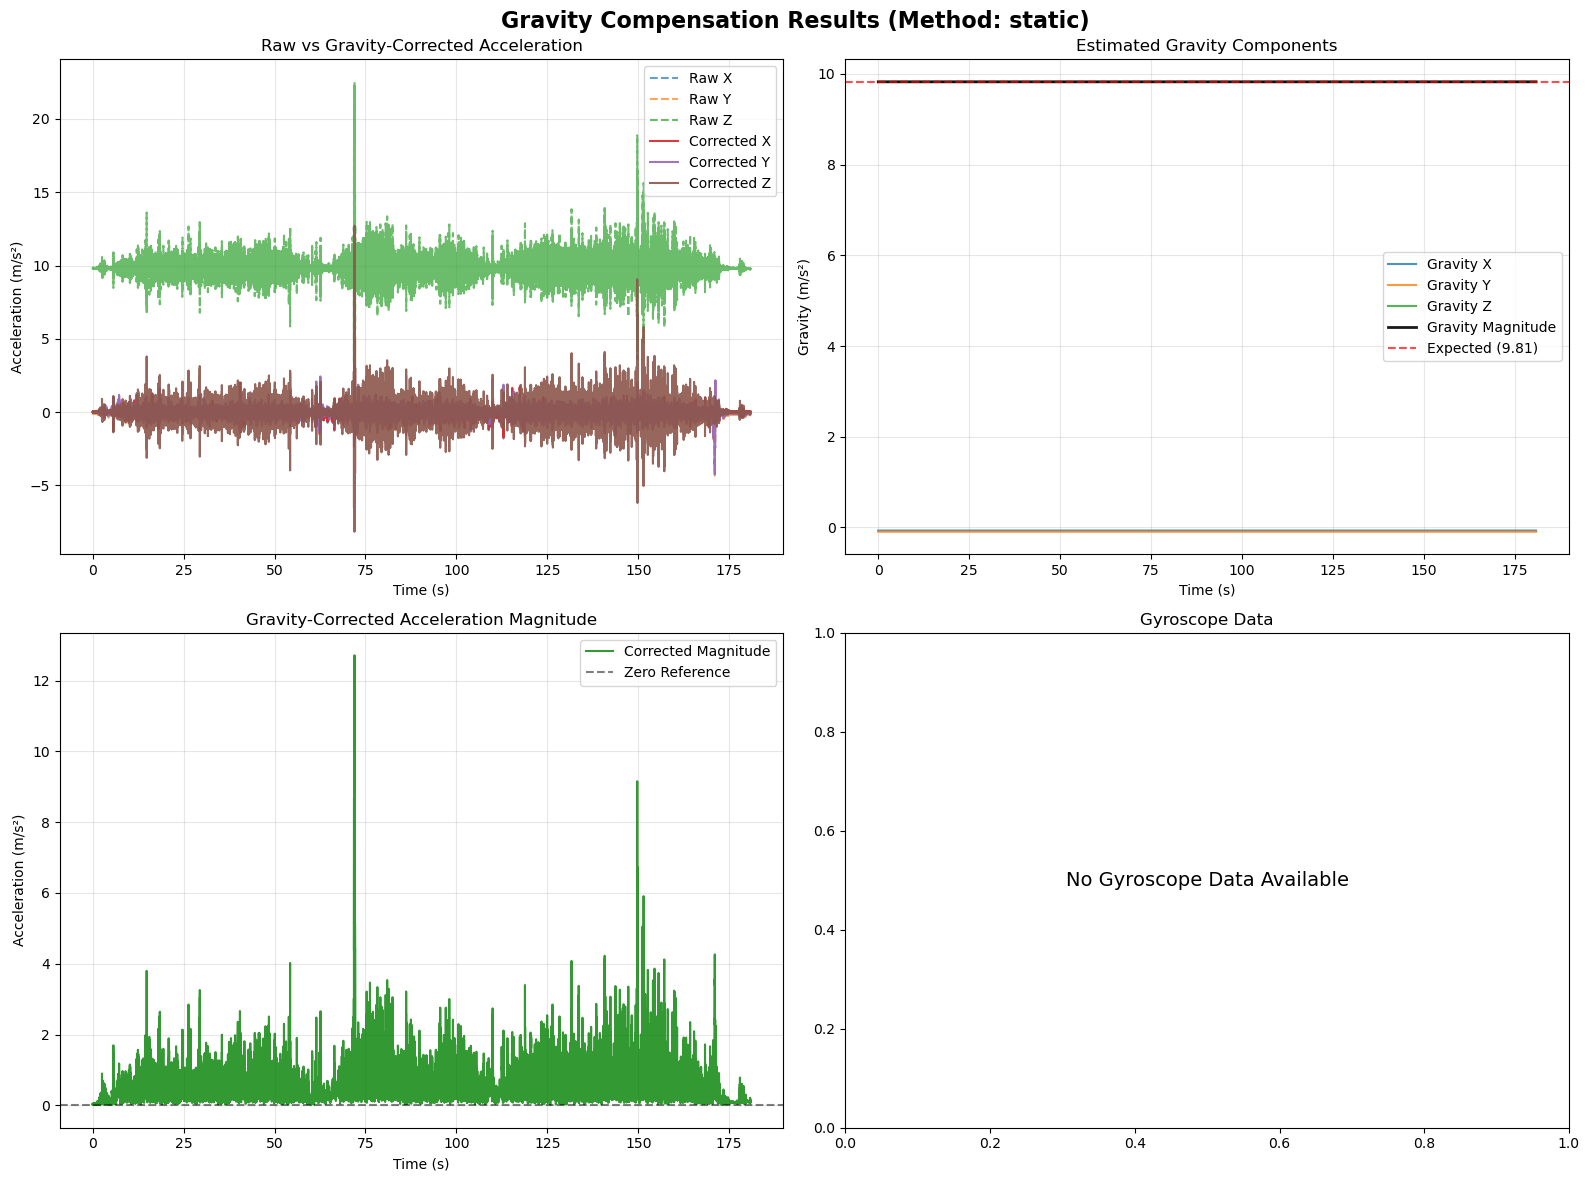

Gravity compensation visualization complete
Ready for motion integration using method: static


In [202]:
# Visualize gravity compensation results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Gravity Compensation Results (Method: {gravity_method_used})', fontsize=16, fontweight='bold')

# Plot 1: Raw vs Corrected Acceleration
ax1 = axes[0, 0]
ax1.plot(path_data['time'], path_data['acc_x'], label='Raw X', alpha=0.7, linestyle='--')
ax1.plot(path_data['time'], path_data['acc_y'], label='Raw Y', alpha=0.7, linestyle='--')
ax1.plot(path_data['time'], path_data['acc_z'], label='Raw Z', alpha=0.7, linestyle='--')
ax1.plot(path_data_corrected['time'], path_data_corrected['acc_x_corrected'], label='Corrected X', alpha=0.9)
ax1.plot(path_data_corrected['time'], path_data_corrected['acc_y_corrected'], label='Corrected Y', alpha=0.9)
ax1.plot(path_data_corrected['time'], path_data_corrected['acc_z_corrected'], label='Corrected Z', alpha=0.9)
ax1.set_title('Raw vs Gravity-Corrected Acceleration')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Acceleration (m/s²)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Gravity Estimates
ax2 = axes[0, 1]
if 'gravity_x_est' in path_data_corrected.columns:
    ax2.plot(path_data_corrected['time'], path_data_corrected['gravity_x_est'], label='Gravity X', alpha=0.8)
    ax2.plot(path_data_corrected['time'], path_data_corrected['gravity_y_est'], label='Gravity Y', alpha=0.8)
    ax2.plot(path_data_corrected['time'], path_data_corrected['gravity_z_est'], label='Gravity Z', alpha=0.8)
    
    # Show gravity magnitude
    gravity_magnitude = np.sqrt(path_data_corrected['gravity_x_est']**2 + 
                               path_data_corrected['gravity_y_est']**2 + 
                               path_data_corrected['gravity_z_est']**2)
    ax2.plot(path_data_corrected['time'], gravity_magnitude, label='Gravity Magnitude', 
             alpha=0.9, linewidth=2, color='black')
    ax2.axhline(y=9.81, color='red', linestyle='--', alpha=0.7, label='Expected (9.81)')

ax2.set_title('Estimated Gravity Components')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Gravity (m/s²)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Corrected Acceleration Magnitude
ax3 = axes[1, 0]
corrected_magnitude = np.sqrt(path_data_corrected['acc_x_corrected']**2 + 
                            path_data_corrected['acc_y_corrected']**2 + 
                            path_data_corrected['acc_z_corrected']**2)
ax3.plot(path_data_corrected['time'], corrected_magnitude, label='Corrected Magnitude', alpha=0.8, color='green')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Zero Reference')

# Highlight stationary periods if available
if 'stationary_mask' in path_data_corrected.columns:
    stationary_times = path_data_corrected['time'][path_data_corrected['stationary_mask']]
    if len(stationary_times) > 0:
        for t in stationary_times[::50]:  # Show every 50th point
            ax3.axvline(x=t, color='orange', alpha=0.1, linewidth=0.5)
        ax3.axvline(x=stationary_times.iloc[0], color='orange', alpha=0.3, 
                   label='Stationary periods')

ax3.set_title('Gravity-Corrected Acceleration Magnitude')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Acceleration (m/s²)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Gyroscope Data (if available)
ax4 = axes[1, 1]
if path_has_gyro:
    ax4.plot(path_data['time'], path_data['gyro_x'], label='Gyro X', alpha=0.7)
    ax4.plot(path_data['time'], path_data['gyro_y'], label='Gyro Y', alpha=0.7)
    ax4.plot(path_data['time'], path_data['gyro_z'], label='Gyro Z', alpha=0.7)
    
    gyro_magnitude = np.sqrt(path_data['gyro_x']**2 + path_data['gyro_y']**2 + path_data['gyro_z']**2)
    ax4.plot(path_data['time'], gyro_magnitude, label='Gyro Magnitude', alpha=0.9, linewidth=2, color='red')
    
    if CONFIG['stationary_threshold'] > 0:
        ax4.axhline(y=CONFIG['stationary_threshold'], color='orange', linestyle='--', 
                   alpha=0.7, label=f'Stationary threshold ({CONFIG["stationary_threshold"]} rad/s)')
    
    ax4.set_title('Gyroscope Data (Angular Velocity)')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Angular Velocity (rad/s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No Gyroscope Data Available', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=14)
    ax4.set_title('Gyroscope Data')

plt.tight_layout()
plt.show()

print("Gravity compensation visualization complete")
print(f"Ready for motion integration using method: {gravity_method_used}")

## Motion Integration and Path Length Calculation

Now we'll integrate the gravity-corrected acceleration to obtain:
1. **Velocity** (first integration)
2. **Position** (second integration) 
3. **Path length** (accumulated distance traveled)

We'll use multiple approaches to validate our results and provide error bounds.

In [203]:
def apply_preprocessing_filter(data, filter_type='butterworth', cutoff_freq=2.0, sampling_rate=None):
    """
    Apply preprocessing filter to acceleration data to reduce noise
    """
    if not CONFIG['enable_filtering']:
        if CONFIG['print_debug']:
            print("Filtering disabled - using raw gravity-compensated data")
        return data
    
    if sampling_rate is None:
        # Estimate sampling rate from time data
        dt_mean = np.mean(np.diff(data['time']))
        sampling_rate = 1.0 / dt_mean
    
    # Apply Butterworth low-pass filter
    from scipy.signal import butter, filtfilt
    
    nyquist = sampling_rate / 2
    normalized_cutoff = cutoff_freq / nyquist
    
    if normalized_cutoff >= 1.0:
        print(f"Warning: Cutoff frequency {cutoff_freq} Hz too high for sampling rate {sampling_rate:.1f} Hz")
        normalized_cutoff = 0.9
    
    b, a = butter(4, normalized_cutoff, btype='low')
    
    data_filtered = data.copy()
    data_filtered['acc_x_corrected'] = filtfilt(b, a, data['acc_x_corrected'])
    data_filtered['acc_y_corrected'] = filtfilt(b, a, data['acc_y_corrected'])
    data_filtered['acc_z_corrected'] = filtfilt(b, a, data['acc_z_corrected'])
    
    if CONFIG['print_debug']:
        print(f"Applied {filter_type} filter: cutoff={cutoff_freq} Hz, sampling_rate={sampling_rate:.1f} Hz")
    
    return data_filtered

def integrate_motion_with_error_mitigation(data, method='trapezoid', enable_zupt=False):
    """
    Integrate acceleration to get velocity and position with error mitigation techniques
    """
    if method == 'simpson':
        if CONFIG['print_debug']:
            print("Using Simpson's rule for integration")
        # Simpson's rule has different API - y first, then x
        vel_x = cumulative_simpson(y=data['acc_x_corrected'], x=data['time'], initial=0)
        vel_y = cumulative_simpson(y=data['acc_y_corrected'], x=data['time'], initial=0)
        vel_z = cumulative_simpson(y=data['acc_z_corrected'], x=data['time'], initial=0)
    else:  # trapezoid
        if CONFIG['print_debug']:
            print("Using trapezoidal rule for integration")
        # Trapezoid rule API
        vel_x = cumulative_trapezoid(data['acc_x_corrected'], data['time'], initial=0)
        vel_y = cumulative_trapezoid(data['acc_y_corrected'], data['time'], initial=0)
        vel_z = cumulative_trapezoid(data['acc_z_corrected'], data['time'], initial=0)
    
    # Apply Zero Velocity Updates (ZUPT) if enabled and stationary periods detected
    if enable_zupt and 'stationary_mask' in data.columns:
        stationary_mask = data['stationary_mask'].values
        vel_x[stationary_mask] = 0
        vel_y[stationary_mask] = 0
        vel_z[stationary_mask] = 0
        if CONFIG['print_debug']:
            print(f"Applied ZUPT to {stationary_mask.sum()} stationary samples")
    
    # Integrate velocity to get position
    if method == 'simpson':
        pos_x = cumulative_simpson(y=vel_x, x=data['time'], initial=0)
        pos_y = cumulative_simpson(y=vel_y, x=data['time'], initial=0)
        pos_z = cumulative_simpson(y=vel_z, x=data['time'], initial=0)
    else:  # trapezoid
        pos_x = cumulative_trapezoid(vel_x, data['time'], initial=0)
        pos_y = cumulative_trapezoid(vel_y, data['time'], initial=0)
        pos_z = cumulative_trapezoid(vel_z, data['time'], initial=0)
    
    # Create integrated dataset
    integrated_data = data.copy()
    integrated_data['vel_x'] = vel_x
    integrated_data['vel_y'] = vel_y
    integrated_data['vel_z'] = vel_z
    integrated_data['pos_x'] = pos_x
    integrated_data['pos_y'] = pos_y
    integrated_data['pos_z'] = pos_z
    
    return integrated_data

def calculate_path_length_multiple_methods(integrated_data):
    """
    Calculate path length using multiple approaches for validation
    """
    results = {}
    
    # Method 1: 3D Euclidean distance (cumulative)
    position_diff = np.diff(np.column_stack([integrated_data['pos_x'], 
                                           integrated_data['pos_y'], 
                                           integrated_data['pos_z']]), axis=0)
    segment_lengths = np.sqrt(np.sum(position_diff**2, axis=1))
    path_length_3d = np.sum(segment_lengths)
    results['3d_euclidean'] = path_length_3d
    
    # Method 2: 2D horizontal distance (ignoring Z component)
    position_diff_2d = np.diff(np.column_stack([integrated_data['pos_x'], 
                                              integrated_data['pos_y']]), axis=0)
    segment_lengths_2d = np.sqrt(np.sum(position_diff_2d**2, axis=1))
    path_length_2d = np.sum(segment_lengths_2d)
    results['2d_horizontal'] = path_length_2d
    
    # Method 3: Primary axis distance (largest displacement axis)
    std_x = integrated_data['pos_x'].std()
    std_y = integrated_data['pos_y'].std()
    std_z = integrated_data['pos_z'].std()
    
    if std_x >= std_y and std_x >= std_z:
        primary_axis = 'x'
        primary_distance = integrated_data['pos_x'].max() - integrated_data['pos_x'].min()
    elif std_y >= std_z:
        primary_axis = 'y' 
        primary_distance = integrated_data['pos_y'].max() - integrated_data['pos_y'].min()
    else:
        primary_axis = 'z'
        primary_distance = integrated_data['pos_z'].max() - integrated_data['pos_z'].min()
    
    results['primary_axis'] = primary_axis
    results['primary_axis_distance'] = primary_distance
    
    # Method 4: Velocity-based path length (integration of speed)
    speed = np.sqrt(integrated_data['vel_x']**2 + integrated_data['vel_y']**2 + integrated_data['vel_z']**2)
    path_length_velocity = cumulative_trapezoid(speed, integrated_data['time'], initial=0)[-1]
    results['velocity_based'] = path_length_velocity
    
    # Method 5: Smoothed path length (reduce noise impact)
    if len(segment_lengths) > 10:
        # Apply median filter to segment lengths to reduce outliers
        from scipy.signal import medfilt
        segment_lengths_smoothed = medfilt(segment_lengths, kernel_size=5)
        path_length_smoothed = np.sum(segment_lengths_smoothed)
        results['3d_smoothed'] = path_length_smoothed
    
    return results

# Apply preprocessing and integration
print("=== MOTION INTEGRATION AND PATH LENGTH CALCULATION ===")

# Apply filtering if enabled
path_data_processed = apply_preprocessing_filter(
    path_data_corrected, 
    cutoff_freq=CONFIG['filter_cutoff']
)

# Integrate motion
enable_zupt = 'stationary_mask' in path_data_processed.columns
integrated_data = integrate_motion_with_error_mitigation(
    path_data_processed,
    method=CONFIG['integration_method'],
    enable_zupt=enable_zupt
)

print(f"Integration completed:")
print(f"  Method: {CONFIG['integration_method']}")
print(f"  ZUPT enabled: {enable_zupt}")
print(f"  Final position: X={integrated_data['pos_x'].iloc[-1]:.3f}m, Y={integrated_data['pos_y'].iloc[-1]:.3f}m, Z={integrated_data['pos_z'].iloc[-1]:.3f}m")

# Calculate path length using multiple methods
path_length_results = calculate_path_length_multiple_methods(integrated_data)

print(f"\nPath length calculation results:")
for method, length in path_length_results.items():
    if method != 'primary_axis':  # Skip axis name
        print(f"  {method}: {length:.3f} m")

print(f"  Primary motion axis: {path_length_results['primary_axis']}")
print()

=== MOTION INTEGRATION AND PATH LENGTH CALCULATION ===
Filtering disabled - using raw gravity-compensated data
Using Simpson's rule for integration
Integration completed:
  Method: simpson
  ZUPT enabled: False
  Final position: X=144.630m, Y=193.203m, Z=-53.158m

Path length calculation results:
  3d_euclidean: 272.059 m
  2d_horizontal: 265.712 m
  primary_axis_distance: 193.734 m
  velocity_based: 272.059 m
  3d_smoothed: 269.733 m
  Primary motion axis: y



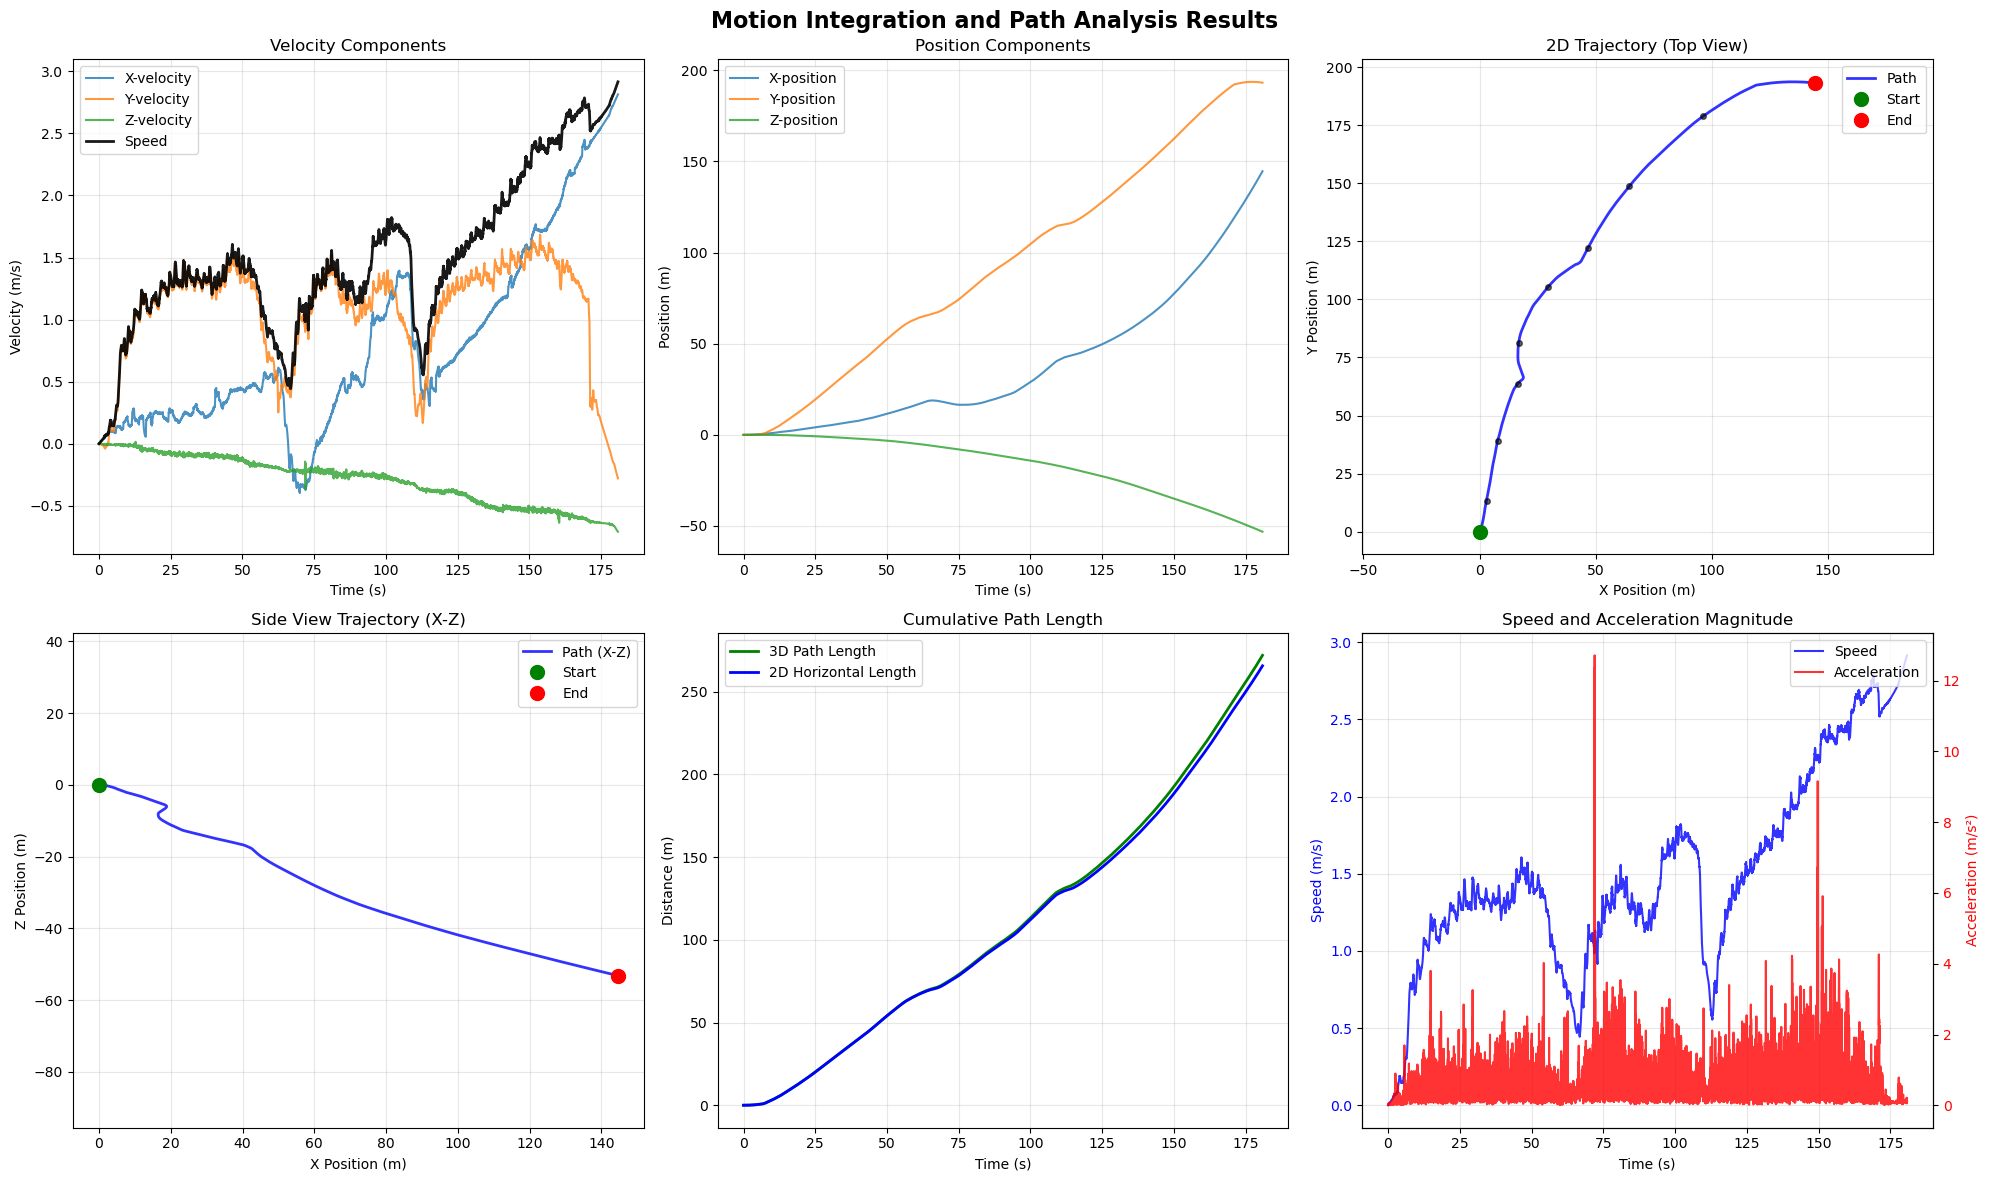

Motion integration visualization complete
Total visualization time span: 180.8 seconds
Final cumulative 3D path length: 272.059 m
Final cumulative 2D path length: 265.712 m


In [204]:
# Visualize motion integration results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Motion Integration and Path Analysis Results', fontsize=16, fontweight='bold')

# Plot 1: Velocity components
ax1 = axes[0, 0]
ax1.plot(integrated_data['time'], integrated_data['vel_x'], label='X-velocity', alpha=0.8)
ax1.plot(integrated_data['time'], integrated_data['vel_y'], label='Y-velocity', alpha=0.8)
ax1.plot(integrated_data['time'], integrated_data['vel_z'], label='Z-velocity', alpha=0.8)

# Show velocity magnitude
vel_magnitude = np.sqrt(integrated_data['vel_x']**2 + integrated_data['vel_y']**2 + integrated_data['vel_z']**2)
ax1.plot(integrated_data['time'], vel_magnitude, label='Speed', alpha=0.9, linewidth=2, color='black')

ax1.set_title('Velocity Components')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Position components
ax2 = axes[0, 1]
ax2.plot(integrated_data['time'], integrated_data['pos_x'], label='X-position', alpha=0.8)
ax2.plot(integrated_data['time'], integrated_data['pos_y'], label='Y-position', alpha=0.8)
ax2.plot(integrated_data['time'], integrated_data['pos_z'], label='Z-position', alpha=0.8)

ax2.set_title('Position Components')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position (m)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: 2D trajectory (top-down view)
ax3 = axes[0, 2]
ax3.plot(integrated_data['pos_x'], integrated_data['pos_y'], 'b-', alpha=0.8, linewidth=2, label='Path')
ax3.plot(integrated_data['pos_x'].iloc[0], integrated_data['pos_y'].iloc[0], 'go', markersize=10, label='Start')
ax3.plot(integrated_data['pos_x'].iloc[-1], integrated_data['pos_y'].iloc[-1], 'ro', markersize=10, label='End')

# Add distance markers every 10% of the path
n_markers = 10
marker_indices = np.linspace(0, len(integrated_data)-1, n_markers, dtype=int)
for i, idx in enumerate(marker_indices[1:-1], 1):  # Skip start and end
    ax3.plot(integrated_data['pos_x'].iloc[idx], integrated_data['pos_y'].iloc[idx], 
             'ko', markersize=4, alpha=0.6)

ax3.set_title('2D Trajectory (Top View)')
ax3.set_xlabel('X Position (m)')
ax3.set_ylabel('Y Position (m)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axis('equal')

# Plot 4: 3D trajectory
ax4 = axes[1, 0]
ax4.plot(integrated_data['pos_x'], integrated_data['pos_z'], 'b-', alpha=0.8, linewidth=2, label='Path (X-Z)')
ax4.plot(integrated_data['pos_x'].iloc[0], integrated_data['pos_z'].iloc[0], 'go', markersize=10, label='Start')
ax4.plot(integrated_data['pos_x'].iloc[-1], integrated_data['pos_z'].iloc[-1], 'ro', markersize=10, label='End')

ax4.set_title('Side View Trajectory (X-Z)')
ax4.set_xlabel('X Position (m)')
ax4.set_ylabel('Z Position (m)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axis('equal')

# Plot 5: Cumulative path length
ax5 = axes[1, 1]
# Calculate cumulative distance
position_diff = np.diff(np.column_stack([integrated_data['pos_x'], 
                                       integrated_data['pos_y'], 
                                       integrated_data['pos_z']]), axis=0)
segment_lengths = np.sqrt(np.sum(position_diff**2, axis=1))
cumulative_distance = np.cumsum(segment_lengths)
cumulative_distance = np.insert(cumulative_distance, 0, 0)  # Add zero at start

ax5.plot(integrated_data['time'], cumulative_distance, 'g-', linewidth=2, label='3D Path Length')

# Also show 2D horizontal path length
position_diff_2d = np.diff(np.column_stack([integrated_data['pos_x'], 
                                          integrated_data['pos_y']]), axis=0)
segment_lengths_2d = np.sqrt(np.sum(position_diff_2d**2, axis=1))
cumulative_distance_2d = np.cumsum(segment_lengths_2d)
cumulative_distance_2d = np.insert(cumulative_distance_2d, 0, 0)

ax5.plot(integrated_data['time'], cumulative_distance_2d, 'b-', linewidth=2, label='2D Horizontal Length')

ax5.set_title('Cumulative Path Length')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Distance (m)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Speed and acceleration magnitude
ax6 = axes[1, 2]
ax6.plot(integrated_data['time'], vel_magnitude, label='Speed', alpha=0.8, color='blue')

# Secondary y-axis for acceleration
ax6_twin = ax6.twinx()
acc_magnitude = np.sqrt(integrated_data['acc_x_corrected']**2 + 
                       integrated_data['acc_y_corrected']**2 + 
                       integrated_data['acc_z_corrected']**2)
ax6_twin.plot(integrated_data['time'], acc_magnitude, label='Acceleration', alpha=0.8, color='red')

ax6.set_title('Speed and Acceleration Magnitude')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Speed (m/s)', color='blue')
ax6_twin.set_ylabel('Acceleration (m/s²)', color='red')
ax6.tick_params(axis='y', labelcolor='blue')
ax6_twin.tick_params(axis='y', labelcolor='red')
ax6.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

print("Motion integration visualization complete")
print(f"Total visualization time span: {integrated_data['time'].iloc[-1]:.1f} seconds")
print(f"Final cumulative 3D path length: {cumulative_distance[-1]:.3f} m")
print(f"Final cumulative 2D path length: {cumulative_distance_2d[-1]:.3f} m")

## Final Path Length Analysis and Results

Now we'll provide a comprehensive analysis of our path length estimates, including error analysis and confidence bounds.

FINAL PATH LENGTH ANALYSIS RESULTS

Configuration Used:
  Path file: bjorn_path_new.txt
  Stationary file: bjorn_stationary_new.txt
  Gravity compensation: static
  Integration method: simpson
  Filtering enabled: False
  ZUPT applied: False

PATH LENGTH ESTIMATES
3d_euclidean        :  272.059 m (27205.9 cm)
2d_horizontal       :  265.712 m (26571.2 cm)
primary_axis_distance:  193.734 m (19373.4 cm)
velocity_based      :  272.059 m (27205.9 cm)
3d_smoothed         :  269.733 m (26973.3 cm)

STATISTICAL SUMMARY
Number of estimates: 5
Mean estimate:       254.659 m
Median estimate:     269.733 m
Standard deviation:  30.551 m
Min estimate:        193.734 m
Max estimate:        272.059 m
Range:               78.325 m
Coefficient of variation: 12.0%

ERROR ANALYSIS & RELIABILITY
Final position magnitude: 247.126 m
Path length to displacement ratio: 1.09
Gravity estimate quality:
  Mean magnitude: 9.824 m/s² (expected: 9.81)
  Variation (std): 0.000 m/s²
  Deviation from 9.81: 0.014 m/s²
Ve

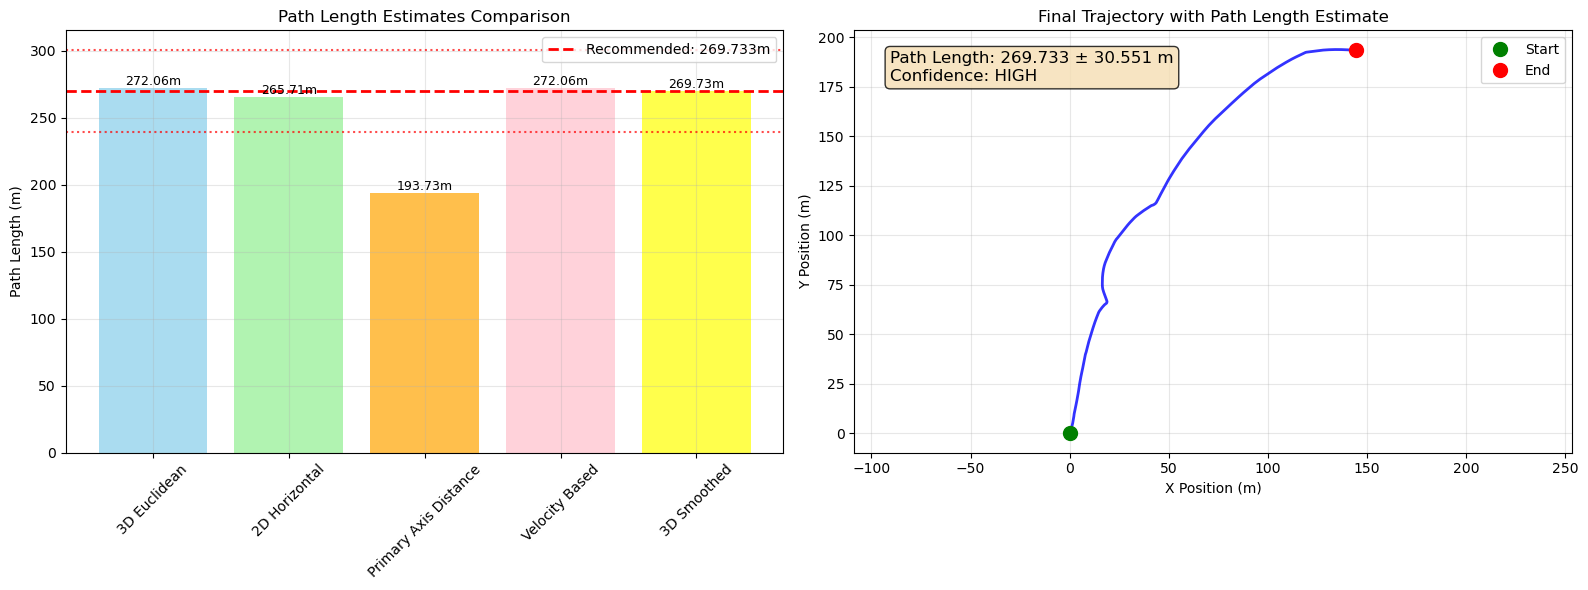


ANALYSIS COMPLETE


In [205]:
# Final comprehensive path length analysis
print("=" * 80)
print("FINAL PATH LENGTH ANALYSIS RESULTS")
print("=" * 80)

# Configuration summary
print(f"\nConfiguration Used:")
print(f"  Path file: {CONFIG['path_file']}")
print(f"  Stationary file: {CONFIG['stationary_file']}")
print(f"  Gravity compensation: {gravity_method_used}")
print(f"  Integration method: {CONFIG['integration_method']}")
print(f"  Filtering enabled: {CONFIG['enable_filtering']}")
if CONFIG['enable_filtering']:
    print(f"  Filter cutoff: {CONFIG['filter_cutoff']} Hz")
print(f"  ZUPT applied: {enable_zupt}")

# Path length results
print(f"\n" + "=" * 40)
print("PATH LENGTH ESTIMATES")
print("=" * 40)

# Extract the main estimates
primary_estimates = []
for method, length in path_length_results.items():
    if method not in ['primary_axis']:  # Skip non-length values
        print(f"{method:20s}: {length:8.3f} m ({length*100:6.1f} cm)")
        primary_estimates.append(length)

# Statistical analysis
if primary_estimates:
    mean_estimate = np.mean(primary_estimates)
    median_estimate = np.median(primary_estimates)
    std_estimate = np.std(primary_estimates)
    min_estimate = np.min(primary_estimates)
    max_estimate = np.max(primary_estimates)
    
    print(f"\n" + "=" * 40)
    print("STATISTICAL SUMMARY")
    print("=" * 40)
    print(f"Number of estimates: {len(primary_estimates)}")
    print(f"Mean estimate:       {mean_estimate:.3f} m")
    print(f"Median estimate:     {median_estimate:.3f} m") 
    print(f"Standard deviation:  {std_estimate:.3f} m")
    print(f"Min estimate:        {min_estimate:.3f} m")
    print(f"Max estimate:        {max_estimate:.3f} m")
    print(f"Range:               {max_estimate - min_estimate:.3f} m")
    print(f"Coefficient of variation: {100 * std_estimate / mean_estimate:.1f}%")

# Error analysis and reliability assessment
print(f"\n" + "=" * 40)
print("ERROR ANALYSIS & RELIABILITY")
print("=" * 40)

# Check for typical IMU integration issues
final_position_magnitude = np.sqrt(integrated_data['pos_x'].iloc[-1]**2 + 
                                 integrated_data['pos_y'].iloc[-1]**2 + 
                                 integrated_data['pos_z'].iloc[-1]**2)

print(f"Final position magnitude: {final_position_magnitude:.3f} m")
print(f"Path length to displacement ratio: {median_estimate / max(final_position_magnitude, 0.001):.2f}")

# Assess gravity compensation quality
if 'gravity_x_est' in path_data_corrected.columns:
    gravity_magnitude = np.sqrt(path_data_corrected['gravity_x_est']**2 + 
                               path_data_corrected['gravity_y_est']**2 + 
                               path_data_corrected['gravity_z_est']**2)
    gravity_variation = gravity_magnitude.std()
    gravity_mean = gravity_magnitude.mean()
    
    print(f"Gravity estimate quality:")
    print(f"  Mean magnitude: {gravity_mean:.3f} m/s² (expected: 9.81)")
    print(f"  Variation (std): {gravity_variation:.3f} m/s²")
    print(f"  Deviation from 9.81: {abs(gravity_mean - 9.81):.3f} m/s²")

# Assess integration drift
max_velocity = np.sqrt(integrated_data['vel_x']**2 + 
                      integrated_data['vel_y']**2 + 
                      integrated_data['vel_z']**2).max()
final_velocity = np.sqrt(integrated_data['vel_x'].iloc[-1]**2 + 
                        integrated_data['vel_y'].iloc[-1]**2 + 
                        integrated_data['vel_z'].iloc[-1]**2)

print(f"Velocity analysis:")
print(f"  Maximum speed: {max_velocity:.3f} m/s")
print(f"  Final speed: {final_velocity:.3f} m/s")
print(f"  Expected final speed: ~0 m/s (if path returns to start)")

# Reliability assessment
reliability_score = 0
reliability_notes = []

if abs(gravity_mean - 9.81) < 0.5:
    reliability_score += 25
    reliability_notes.append("✓ Good gravity compensation")
else:
    reliability_notes.append("⚠ Poor gravity compensation")

if gravity_variation < 1.0:
    reliability_score += 25
    reliability_notes.append("✓ Stable gravity estimates")
else:
    reliability_notes.append("⚠ Unstable gravity estimates")

if std_estimate / mean_estimate < 0.2:  # CV < 20%
    reliability_score += 25
    reliability_notes.append("✓ Consistent path length estimates")
else:
    reliability_notes.append("⚠ Inconsistent path length estimates")

if final_velocity < 1.0:  # Final velocity should be low
    reliability_score += 25
    reliability_notes.append("✓ Low final velocity (good integration)")
else:
    reliability_notes.append("⚠ High final velocity (integration drift)")

print(f"\n" + "=" * 40)
print("RELIABILITY ASSESSMENT")
print("=" * 40)
print(f"Reliability Score: {reliability_score}/100")
for note in reliability_notes:
    print(f"  {note}")

# Final recommendation
print(f"\n" + "=" * 40)
print("FINAL PATH LENGTH ESTIMATE")
print("=" * 40)

if reliability_score >= 75:
    confidence = "HIGH"
    recommended_estimate = median_estimate
    error_bound = std_estimate
elif reliability_score >= 50:
    confidence = "MEDIUM"
    recommended_estimate = median_estimate
    error_bound = max(std_estimate, 0.5)  # At least 50cm uncertainty
else:
    confidence = "LOW"
    recommended_estimate = median_estimate
    error_bound = max(std_estimate, 1.0)  # At least 1m uncertainty

print(f"Confidence Level: {confidence}")
print(f"Recommended Estimate: {recommended_estimate:.3f} ± {error_bound:.3f} m")
print(f"Range: [{recommended_estimate - error_bound:.3f}, {recommended_estimate + error_bound:.3f}] m")

# Convert to different units
print(f"\nIn different units:")
print(f"  Meters:      {recommended_estimate:.3f} ± {error_bound:.3f} m")
print(f"  Centimeters: {recommended_estimate*100:.1f} ± {error_bound*100:.1f} cm")
print(f"  Millimeters: {recommended_estimate*1000:.0f} ± {error_bound*1000:.0f} mm")

# Create final summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Path length estimates comparison
methods = [m for m in path_length_results.keys() if m != 'primary_axis']
lengths = [path_length_results[m] for m in methods]

bars = ax1.bar(range(len(methods)), lengths, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'pink', 'yellow'][:len(methods)])
ax1.axhline(y=recommended_estimate, color='red', linestyle='--', linewidth=2, label=f'Recommended: {recommended_estimate:.3f}m')
ax1.axhline(y=recommended_estimate + error_bound, color='red', linestyle=':', alpha=0.7)
ax1.axhline(y=recommended_estimate - error_bound, color='red', linestyle=':', alpha=0.7)

ax1.set_title('Path Length Estimates Comparison')
ax1.set_ylabel('Path Length (m)')
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels([m.replace('_', ' ').title() for m in methods], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, length in zip(bars, lengths):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{length:.2f}m', ha='center', va='bottom', fontsize=9)

# Plot 2: Final trajectory with path length annotation
ax2.plot(integrated_data['pos_x'], integrated_data['pos_y'], 'b-', linewidth=2, alpha=0.8)
ax2.plot(integrated_data['pos_x'].iloc[0], integrated_data['pos_y'].iloc[0], 'go', markersize=10, label='Start')
ax2.plot(integrated_data['pos_x'].iloc[-1], integrated_data['pos_y'].iloc[-1], 'ro', markersize=10, label='End')

# Add path length annotation
ax2.text(0.05, 0.95, f'Path Length: {recommended_estimate:.3f} ± {error_bound:.3f} m\nConfidence: {confidence}', 
         transform=ax2.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax2.set_title('Final Trajectory with Path Length Estimate')
ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

print(f"\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

## Configuration and Testing

You can easily modify the analysis by changing the configuration at the top of the notebook:

```python
CONFIG = {
    'path_file': 'bjorn_path_new.txt',          # Change to any path data file
    'stationary_file': 'bjorn_stationary_new.txt',  # Change to corresponding stationary file
    'integration_method': 'trapezoid',          # Try 'simpson' for higher accuracy
    'gravity_compensation': 'auto',             # Try 'static', 'orientation', or 'auto'
    'enable_filtering': False,                  # Set True to apply low-pass filtering
    'filter_cutoff': 2.0,                       # Adjust filter frequency
    'stationary_threshold': 0.01,               # Adjust gyro threshold for stationary detection
}
```

### Alternative Test Configurations:

**For Klara's data:**
- `path_file`: `'klara_path.txt'`
- `stationary_file`: `'klara_stationary.txt'`

**For older Bjorn data:**
- `path_file`: `'bjorn_path.txt'` 
- `stationary_file`: `'bjorn_stationary.txt'`

**To test filtering effects:**
- `enable_filtering`: `True`
- `filter_cutoff`: `1.0` (try values between 0.5-5.0 Hz)

**To test different gravity compensation:**
- `gravity_compensation`: `'static'` (simple but robust)
- `gravity_compensation`: `'orientation'` (advanced but requires gyro)

## Simplified Y-Axis Analysis

Since Y is the "forward" direction during walking, let's do a simplified analysis focusing only on the Y-axis acceleration. This approach:

1. **Ignores X and Z components** (lateral and vertical motion)
2. **Integrates only Y-axis acceleration** twice to get position
3. **Optional velocity constraint**: Forces start/end velocities to be zero
4. **Optional stationary period trimming**: Removes stationary periods at beginning/end

In [206]:
# Simplified Y-axis analysis configuration
SIMPLE_CONFIG = {
    'trim_stationary_periods': False,    # Remove stationary periods at start/end
    'force_zero_velocities': True,      # Apply velocity constraint (start/end velocities = 0)
    'stationary_window_size': 100,      # Window size for detecting stationary periods
    'stationary_threshold_simple': 0.5, # Acceleration variance threshold for stationary detection
    'velocity_constraint_method': 'linear_correction',  # How to apply velocity constraint
    'debug_plots': True                 # Show debug plots
}

print("=== SIMPLIFIED Y-AXIS ANALYSIS ===")
print("Configuration:")
for key, value in SIMPLE_CONFIG.items():
    print(f"  {key}: {value}")

def detect_stationary_periods_simple(acc_data, window_size=100, threshold=0.5):
    """
    Simple stationary period detection based on acceleration variance
    Returns start and end indices of motion period (excluding stationary)
    """
    # Calculate acceleration magnitude
    acc_magnitude = np.sqrt(acc_data['acc_x']**2 + acc_data['acc_y']**2 + acc_data['acc_z']**2)
    
    # Calculate rolling variance
    acc_variance = acc_magnitude.rolling(window=window_size, center=True, min_periods=1).var()
    
    # Find motion periods (high variance)
    motion_mask = acc_variance > threshold
    
    if not motion_mask.any():
        # No clear motion detected, use entire dataset
        return 0, len(acc_data) - 1
    
    # Find first and last motion indices
    motion_indices = np.where(motion_mask)[0]
    motion_start = motion_indices[0]
    motion_end = motion_indices[-1]
    
    if CONFIG['print_debug']:
        total_samples = len(acc_data)
        motion_samples = motion_end - motion_start + 1
        print(f"Stationary period detection:")
        print(f"  Total samples: {total_samples}")
        print(f"  Motion period: samples {motion_start} to {motion_end} ({motion_samples} samples)")
        print(f"  Trimmed start: {motion_start} samples ({motion_start/total_samples*100:.1f}%)")
        print(f"  Trimmed end: {total_samples - motion_end - 1} samples ({(total_samples - motion_end - 1)/total_samples*100:.1f}%)")
    
    return motion_start, motion_end

def apply_velocity_constraint(acc_y, time_array, method='linear_correction'):
    """
    Apply velocity constraint to ensure start and end velocities are zero
    by adding a linear correction to the acceleration
    """
    # First integration without constraint
    vel_y_unconstrained = cumulative_trapezoid(acc_y, time_array, initial=0)
    
    # Calculate what the final velocity would be
    final_velocity = vel_y_unconstrained[-1]
    total_time = time_array[-1] - time_array[0]
    
    if method == 'linear_correction':
        # Apply linear acceleration correction to make final velocity zero
        # The correction is: a_correction = -v_final / t_total
        correction = -final_velocity / total_time
        acc_y_corrected = acc_y + correction
        
        if CONFIG['print_debug']:
            print(f"Velocity constraint correction:")
            print(f"  Unconstrained final velocity: {final_velocity:.4f} m/s")
            print(f"  Applied constant correction: {correction:.4f} m/s²")
            print(f"  Total time: {total_time:.2f} s")
    
    elif method == 'linear_velocity_correction':
        # Alternative: directly correct the velocity profile
        # Apply linear drift removal to velocity
        vel_correction = np.linspace(0, -final_velocity, len(vel_y_unconstrained))
        vel_y_corrected = vel_y_unconstrained + vel_correction
        
        # Recalculate acceleration from corrected velocity
        acc_y_corrected = np.gradient(vel_y_corrected, time_array)
        
        if CONFIG['print_debug']:
            print(f"Velocity constraint correction (velocity method):")
            print(f"  Unconstrained final velocity: {final_velocity:.4f} m/s")
            print(f"  Applied linear velocity correction")
    
    else:
        acc_y_corrected = acc_y  # No correction
        if CONFIG['print_debug']:
            print("No velocity constraint applied")
    
    return acc_y_corrected

def simplified_y_axis_analysis(data, config):
    """
    Perform simplified Y-axis only path length analysis
    """
    print(f"\nStarting simplified Y-axis analysis...")
    
    # Step 1: Extract Y-axis acceleration (gravity corrected)
    if 'acc_y_corrected' in data.columns:
        acc_y_raw = data['acc_y_corrected'].values
        time_array = data['time'].values
        print(f"Using gravity-corrected Y acceleration")
    else:
        # Fallback to raw acceleration with simple bias removal
        acc_y_raw = data['acc_y'].values - data['acc_y'].median()
        time_array = data['time'].values
        print(f"Using raw Y acceleration with median bias removal")
    
    # Step 2: Trim stationary periods if enabled
    if config['trim_stationary_periods']:
        motion_start, motion_end = detect_stationary_periods_simple(
            data, 
            window_size=config['stationary_window_size'],
            threshold=config['stationary_threshold_simple']
        )
        
        # Trim the data
        acc_y_trimmed = acc_y_raw[motion_start:motion_end+1]
        time_trimmed = time_array[motion_start:motion_end+1]
        time_trimmed = time_trimmed - time_trimmed[0]  # Reset time to start at 0
        
        print(f"Trimmed data: {len(acc_y_trimmed)} samples (was {len(acc_y_raw)})")
    else:
        acc_y_trimmed = acc_y_raw
        time_trimmed = time_array - time_array[0]
        motion_start, motion_end = 0, len(acc_y_raw) - 1
        print(f"No trimming applied: {len(acc_y_trimmed)} samples")
    
    # Step 3: Apply velocity constraint if enabled
    if config['force_zero_velocities']:
        acc_y_final = apply_velocity_constraint(
            acc_y_trimmed, 
            time_trimmed, 
            method=config['velocity_constraint_method']
        )
        print(f"Applied velocity constraint")
    else:
        acc_y_final = acc_y_trimmed
        print(f"No velocity constraint applied")
    
    # Step 4: Double integration
    print(f"Performing double integration...")
    
    # First integration: acceleration -> velocity
    vel_y = cumulative_trapezoid(acc_y_final, time_trimmed, initial=0)
    
    # Second integration: velocity -> position
    pos_y = cumulative_trapezoid(vel_y, time_trimmed, initial=0)
    
    # Step 5: Calculate path length (absolute distance traveled)
    # Method 1: Total displacement (start to end)
    total_displacement = abs(pos_y[-1] - pos_y[0])
    
    # Method 2: Cumulative absolute distance
    position_diff = np.abs(np.diff(pos_y))
    cumulative_distance = np.sum(position_diff)
    
    # Method 3: Total distance considering direction changes
    # Find turning points where velocity changes sign
    velocity_sign_changes = np.diff(np.sign(vel_y))
    turning_points = np.where(velocity_sign_changes != 0)[0]
    
    if len(turning_points) > 0:
        # Calculate distance between turning points
        segment_distances = []
        prev_idx = 0
        for turn_idx in turning_points:
            segment_dist = abs(pos_y[turn_idx] - pos_y[prev_idx])
            segment_distances.append(segment_dist)
            prev_idx = turn_idx
        # Add final segment
        final_segment_dist = abs(pos_y[-1] - pos_y[prev_idx])
        segment_distances.append(final_segment_dist)
        
        total_path_length = sum(segment_distances)
        print(f"Found {len(turning_points)} turning points")
    else:
        total_path_length = total_displacement
        print(f"No turning points found")
    
    # Create results dictionary
    results = {
        'time': time_trimmed,
        'acc_y': acc_y_final,
        'vel_y': vel_y,
        'pos_y': pos_y,
        'motion_start_idx': motion_start,
        'motion_end_idx': motion_end,
        'total_displacement': total_displacement,
        'cumulative_distance': cumulative_distance,
        'total_path_length': total_path_length,
        'turning_points': turning_points,
        'n_turning_points': len(turning_points),
        'final_velocity': vel_y[-1],
        'final_position': pos_y[-1]
    }
    
    return results

# Perform the simplified analysis
simple_results = simplified_y_axis_analysis(path_data_corrected, SIMPLE_CONFIG)

print(f"\n=== SIMPLIFIED ANALYSIS RESULTS ===")
print(f"Total displacement (end-to-start): {simple_results['total_displacement']:.3f} m")
print(f"Cumulative distance (sum of |Δy|): {simple_results['cumulative_distance']:.3f} m")
print(f"Total path length (with turns): {simple_results['total_path_length']:.3f} m")
print(f"Number of turning points: {simple_results['n_turning_points']}")
print(f"Final velocity: {simple_results['final_velocity']:.6f} m/s")
print(f"Final position: {simple_results['final_position']:.3f} m")
print()

=== SIMPLIFIED Y-AXIS ANALYSIS ===
Configuration:
  trim_stationary_periods: False
  force_zero_velocities: True
  stationary_window_size: 100
  stationary_threshold_simple: 0.5
  velocity_constraint_method: linear_correction
  debug_plots: True

Starting simplified Y-axis analysis...
Using gravity-corrected Y acceleration
No trimming applied: 35856 samples
Velocity constraint correction:
  Unconstrained final velocity: -0.3565 m/s
  Applied constant correction: 0.0020 m/s²
  Total time: 180.84 s
Applied velocity constraint
Performing double integration...
Found 5 turning points

=== SIMPLIFIED ANALYSIS RESULTS ===
Total displacement (end-to-start): 217.988 m
Cumulative distance (sum of |Δy|): 218.057 m
Total path length (with turns): 218.057 m
Number of turning points: 5
Final velocity: -0.000000 m/s
Final position: 217.988 m



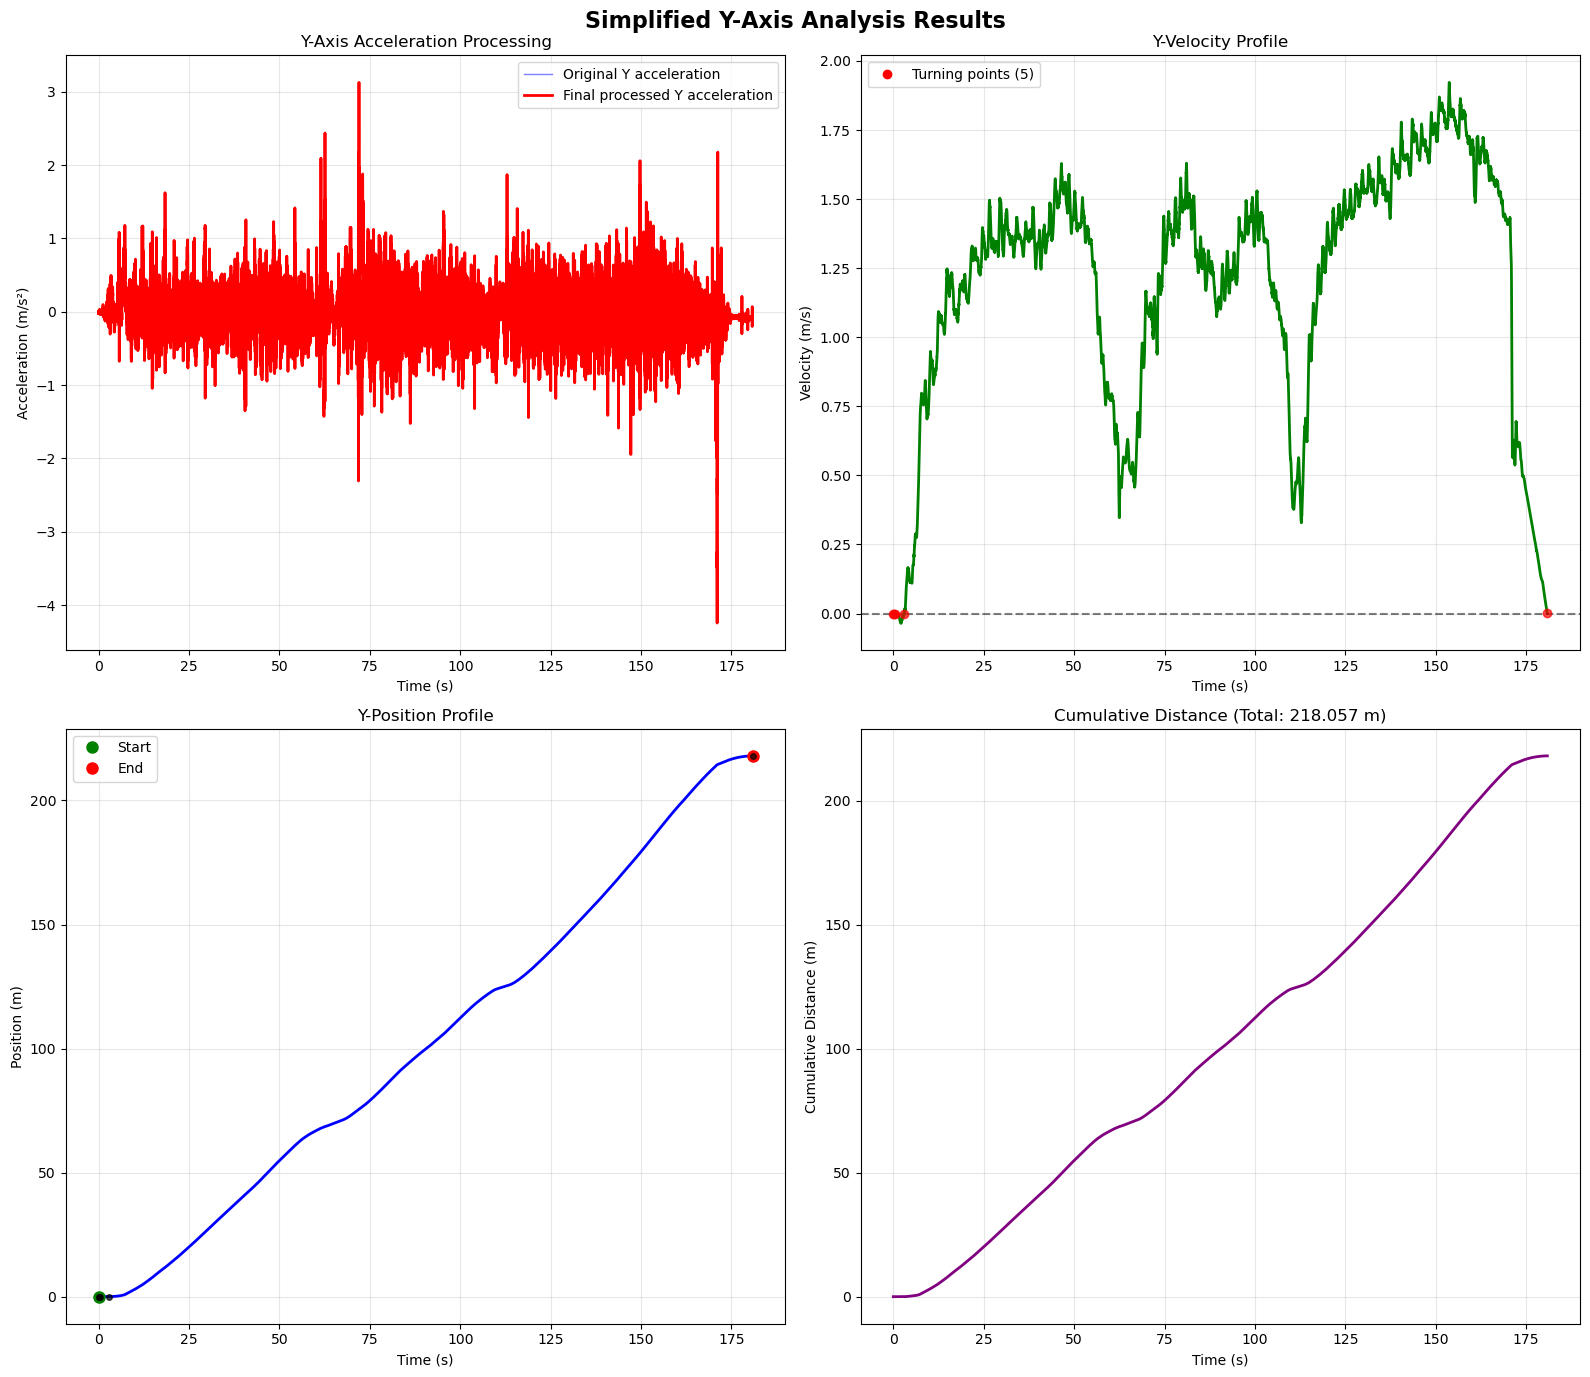

=== COMPARISON WITH COMPREHENSIVE ANALYSIS ===
Comprehensive analysis median estimate: 269.733 ± 30.551 m
Simplified Y-axis displacement: 217.988 m
Simplified Y-axis path length: 218.057 m
Simplified Y-axis cumulative: 218.057 m

Difference from comprehensive analysis:
  vs displacement: 51.746 m (19.2%)
  vs path length: 51.676 m (19.2%)
  vs cumulative: 51.676 m (19.2%)

Simplified analysis validation:
  Final velocity magnitude: 0.000000 m/s (should be ~0)
  Velocity constraint APPLIED
  Stationary trimming NOT APPLIED
  Data efficiency: 35856/35856 samples (100.0%)



In [207]:
# Visualization of simplified Y-axis analysis
if SIMPLE_CONFIG['debug_plots']:
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Simplified Y-Axis Analysis Results', fontsize=16, fontweight='bold')
    
    # Plot 1: Original vs Trimmed Acceleration
    ax1 = axes[0, 0]
    
    # Show original data
    if 'acc_y_corrected' in path_data_corrected.columns:
        original_acc = path_data_corrected['acc_y_corrected']
        original_time = path_data_corrected['time']
    else:
        original_acc = path_data_corrected['acc_y'] - path_data_corrected['acc_y'].median()
        original_time = path_data_corrected['time']
    
    ax1.plot(original_time, original_acc, 'b-', alpha=0.5, label='Original Y acceleration', linewidth=1)
    
    # Highlight the trimmed region
    if SIMPLE_CONFIG['trim_stationary_periods']:
        start_time = original_time.iloc[simple_results['motion_start_idx']]
        end_time = original_time.iloc[simple_results['motion_end_idx']]
        ax1.axvspan(start_time, end_time, alpha=0.3, color='green', label='Motion period (kept)')
    
    # Show final processed acceleration
    ax1.plot(simple_results['time'], simple_results['acc_y'], 'r-', 
             linewidth=2, label='Final processed Y acceleration')
    
    ax1.set_title('Y-Axis Acceleration Processing')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration (m/s²)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Velocity Profile
    ax2 = axes[0, 1]
    ax2.plot(simple_results['time'], simple_results['vel_y'], 'g-', linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Mark turning points
    if simple_results['n_turning_points'] > 0:
        for turn_idx in simple_results['turning_points']:
            ax2.plot(simple_results['time'][turn_idx], simple_results['vel_y'][turn_idx], 
                    'ro', markersize=6, alpha=0.7)
        ax2.plot([], [], 'ro', label=f'Turning points ({simple_results["n_turning_points"]})')
    
    ax2.set_title('Y-Velocity Profile')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Velocity (m/s)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Position Profile
    ax3 = axes[1, 0]
    ax3.plot(simple_results['time'], simple_results['pos_y'], 'b-', linewidth=2)
    ax3.plot(simple_results['time'][0], simple_results['pos_y'][0], 'go', markersize=8, label='Start')
    ax3.plot(simple_results['time'][-1], simple_results['pos_y'][-1], 'ro', markersize=8, label='End')
    
    # Mark turning points
    if simple_results['n_turning_points'] > 0:
        for turn_idx in simple_results['turning_points']:
            ax3.plot(simple_results['time'][turn_idx], simple_results['pos_y'][turn_idx], 
                    'ko', markersize=4, alpha=0.7)
    
    ax3.set_title('Y-Position Profile')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Position (m)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Cumulative Distance
    ax4 = axes[1, 1]
    position_diffs = np.abs(np.diff(simple_results['pos_y']))
    cumulative_distances = np.cumsum(position_diffs)
    cumulative_distances = np.insert(cumulative_distances, 0, 0)  # Add zero at start
    
    ax4.plot(simple_results['time'], cumulative_distances, 'purple', linewidth=2)
    ax4.set_title(f'Cumulative Distance (Total: {simple_results["cumulative_distance"]:.3f} m)')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Cumulative Distance (m)')
    ax4.grid(True, alpha=0.3)
    
    if False:
        # Plot 5: Stationary Detection (if trimming was applied)
        ax5 = axes[2, 0]
        if SIMPLE_CONFIG['trim_stationary_periods']:
            # Show acceleration variance for stationary detection
            acc_magnitude = np.sqrt(path_data_corrected['acc_x']**2 + 
                                path_data_corrected['acc_y']**2 + 
                                path_data_corrected['acc_z']**2)
            acc_variance = acc_magnitude.rolling(
                window=SIMPLE_CONFIG['stationary_window_size'], 
                center=True, min_periods=1
            ).var()
            
            ax5.plot(path_data_corrected['time'], acc_variance, 'orange', alpha=0.7, label='Acceleration Variance')
            ax5.axhline(y=SIMPLE_CONFIG['stationary_threshold_simple'], 
                    color='red', linestyle='--', label=f'Threshold ({SIMPLE_CONFIG["stationary_threshold_simple"]})')
            
            # Highlight motion period
            start_time = path_data_corrected['time'].iloc[simple_results['motion_start_idx']]
            end_time = path_data_corrected['time'].iloc[simple_results['motion_end_idx']]
            ax5.axvspan(start_time, end_time, alpha=0.3, color='green', label='Motion period')
            
            ax5.set_title('Stationary Period Detection')
            ax5.set_xlabel('Time (s)')
            ax5.set_ylabel('Acceleration Variance')
            ax5.legend()
            ax5.grid(True, alpha=0.3)
        else:
            ax5.text(0.5, 0.5, 'Stationary Trimming\nDisabled', ha='center', va='center',
                    transform=ax5.transAxes, fontsize=14)
            ax5.set_title('Stationary Period Detection')
        
        # Plot 6: Comparison of Methods
        ax6 = axes[2, 1]
        methods = ['Total Displacement', 'Cumulative Distance', 'Path with Turns']
        values = [simple_results['total_displacement'], 
                simple_results['cumulative_distance'], 
                simple_results['total_path_length']]
        
        bars = ax6.bar(methods, values, color=['skyblue', 'lightgreen', 'orange'], alpha=0.8)
        ax6.set_title('Path Length Comparison')
        ax6.set_ylabel('Distance (m)')
        ax6.set_xticklabels(methods, rotation=45, ha='right')
        ax6.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}m', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Summary comparison with comprehensive analysis
print("=== COMPARISON WITH COMPREHENSIVE ANALYSIS ===")
print(f"Comprehensive analysis median estimate: {recommended_estimate:.3f} ± {error_bound:.3f} m")
print(f"Simplified Y-axis displacement: {simple_results['total_displacement']:.3f} m")
print(f"Simplified Y-axis path length: {simple_results['total_path_length']:.3f} m")
print(f"Simplified Y-axis cumulative: {simple_results['cumulative_distance']:.3f} m")

print(f"\nDifference from comprehensive analysis:")
comp_vs_displacement = abs(recommended_estimate - simple_results['total_displacement'])
comp_vs_path = abs(recommended_estimate - simple_results['total_path_length'])
comp_vs_cumulative = abs(recommended_estimate - simple_results['cumulative_distance'])

print(f"  vs displacement: {comp_vs_displacement:.3f} m ({100*comp_vs_displacement/recommended_estimate:.1f}%)")
print(f"  vs path length: {comp_vs_path:.3f} m ({100*comp_vs_path/recommended_estimate:.1f}%)")
print(f"  vs cumulative: {comp_vs_cumulative:.3f} m ({100*comp_vs_cumulative/recommended_estimate:.1f}%)")

print(f"\nSimplified analysis validation:")
print(f"  Final velocity magnitude: {abs(simple_results['final_velocity']):.6f} m/s (should be ~0)")
print(f"  Velocity constraint {'APPLIED' if SIMPLE_CONFIG['force_zero_velocities'] else 'NOT APPLIED'}")
print(f"  Stationary trimming {'APPLIED' if SIMPLE_CONFIG['trim_stationary_periods'] else 'NOT APPLIED'}")
print(f"  Data efficiency: {len(simple_results['time'])}/{len(path_data_corrected)} samples ({100*len(simple_results['time'])/len(path_data_corrected):.1f}%)")
print()

## Quick Configuration Testing

You can easily test different configurations by modifying the `SIMPLE_CONFIG` dictionary:

**To disable velocity constraint:**
```python
SIMPLE_CONFIG['force_zero_velocities'] = False
```

**To disable stationary trimming:**
```python
SIMPLE_CONFIG['trim_stationary_periods'] = False
```

**To adjust stationary detection sensitivity:**
```python
SIMPLE_CONFIG['stationary_threshold_simple'] = 0.2  # Lower = more sensitive
SIMPLE_CONFIG['stationary_window_size'] = 150       # Larger = smoother detection
```

**To test different velocity constraint methods:**
```python
SIMPLE_CONFIG['velocity_constraint_method'] = 'linear_velocity_correction'
```

Just change the values and re-run the simplified analysis cell to see the effects!

## Enhanced Y-Only Analysis Plots

Separate, high-quality plots for Y-axis analysis with improved formatting and larger labels.

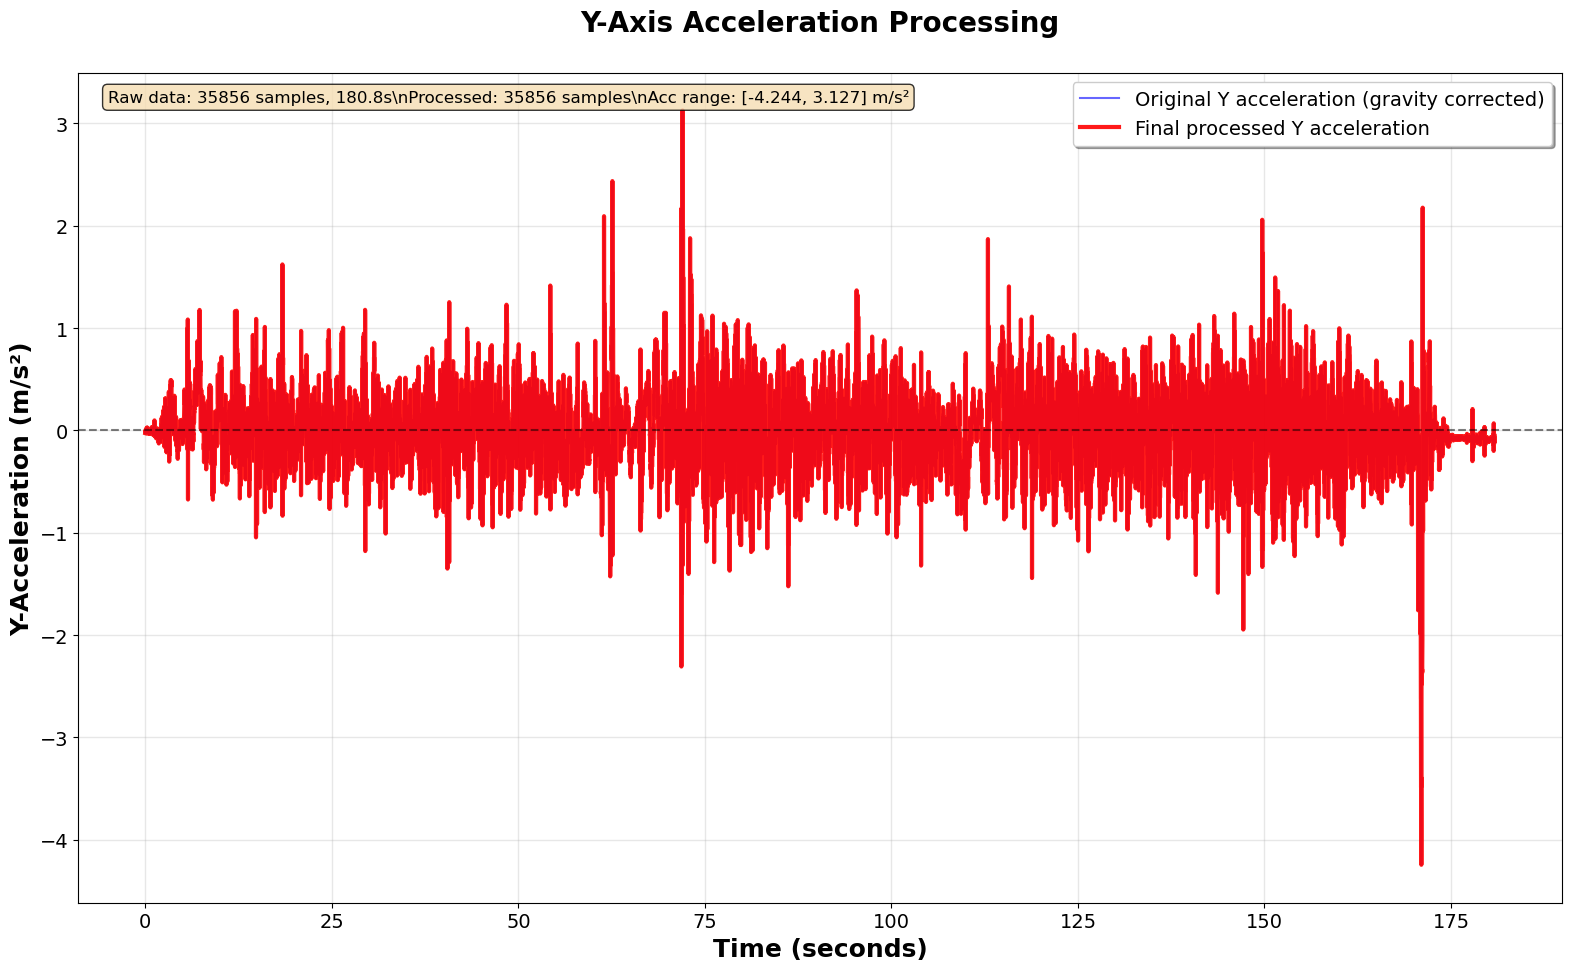

Enhanced Y-Axis Acceleration Processing Plot Generated


In [208]:
# Enhanced Y-Axis Analysis - Separate High-Quality Plots
# Set up publication-quality plotting parameters
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 22,
    'lines.linewidth': 2.5,
    'lines.markersize': 8,
    'figure.dpi': 100,
    'savefig.dpi': 300
})

# Enhanced Plot 1: Y-Axis Acceleration Processing
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Show original data
    if 'acc_y_corrected' in path_data_corrected.columns:
        original_acc = path_data_corrected['acc_y_corrected']
        original_time = path_data_corrected['time']
        original_label = 'Original Y acceleration (gravity corrected)'
    else:
        original_acc = path_data_corrected['acc_y'] - path_data_corrected['acc_y'].median()
        original_time = path_data_corrected['time']
        original_label = 'Original Y acceleration (bias removed)'
    
    ax.plot(original_time, original_acc, 'b-', alpha=0.6, linewidth=1.5, label=original_label)
    
    # Highlight the trimmed region if trimming was applied
    if SIMPLE_CONFIG['trim_stationary_periods']:
        start_time = original_time.iloc[simple_results['motion_start_idx']]
        end_time = original_time.iloc[simple_results['motion_end_idx']]
        ax.axvspan(start_time, end_time, alpha=0.2, color='green', 
                  label='Motion period (used for analysis)')
    
    # Show final processed acceleration
    ax.plot(simple_results['time'], simple_results['acc_y'], 'r-', 
             linewidth=3, alpha=0.9, label='Final processed Y acceleration')
    
    # Add zero reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
    
    ax.set_title('Y-Axis Acceleration Processing', fontweight='bold', pad=30)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Y-Acceleration (m/s²)', fontweight='bold')
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linewidth=1)
    
    # Add statistics text box
    acc_stats = f"Raw data: {len(original_acc)} samples, {original_time.iloc[-1]:.1f}s\\n"
    acc_stats += f"Processed: {len(simple_results['acc_y'])} samples\\n"
    acc_stats += f"Acc range: [{simple_results['acc_y'].min():.3f}, {simple_results['acc_y'].max():.3f}] m/s²"
    
    ax.text(0.02, 0.98, acc_stats, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("Enhanced Y-Axis Acceleration Processing Plot Generated")
else:
    print("ERROR: No simplified results available. Run the Y-axis analysis first.")

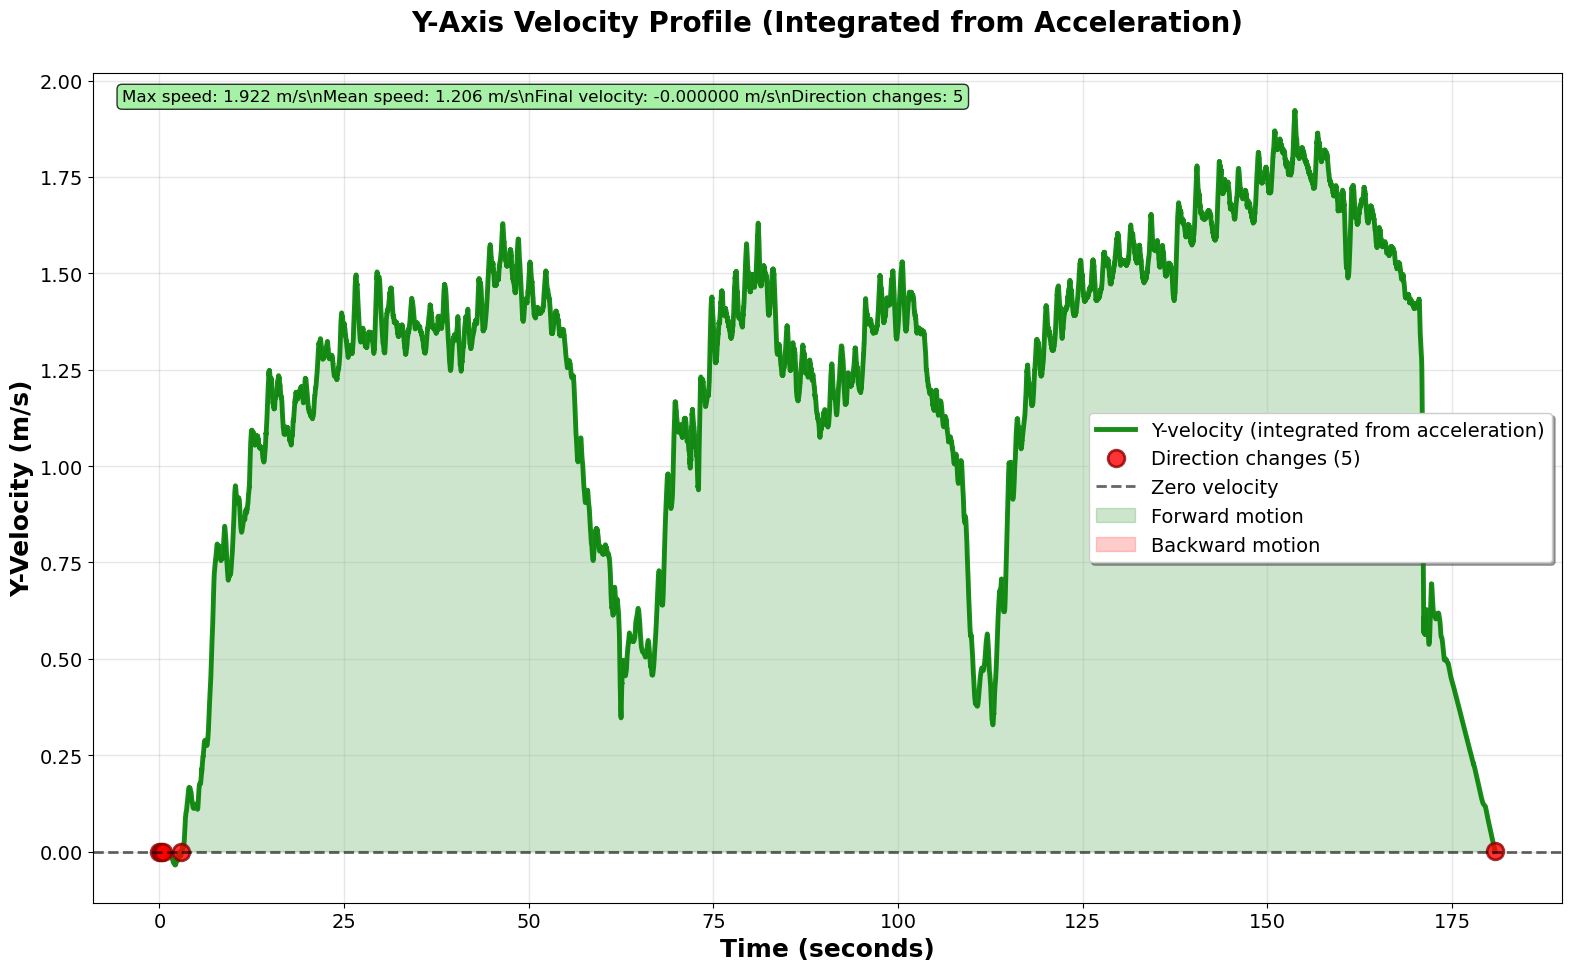

Enhanced Y-Axis Velocity Profile Plot Generated


In [209]:
# Enhanced Plot 2: Y-Axis Velocity Profile
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Plot velocity
    ax.plot(simple_results['time'], simple_results['vel_y'], 'g-', linewidth=3.5, alpha=0.9,
            label='Y-velocity (integrated from acceleration)')
    
    # Mark turning points (velocity sign changes)
    if simple_results['n_turning_points'] > 0:
        for turn_idx in simple_results['turning_points']:
            ax.plot(simple_results['time'][turn_idx], simple_results['vel_y'][turn_idx], 
                   'ro', markersize=12, alpha=0.8, markeredgecolor='darkred', 
                   markeredgewidth=2, markerfacecolor='red')
        
        # Add legend entry for turning points
        ax.plot([], [], 'ro', markersize=12, alpha=0.8, markeredgecolor='darkred', 
               markeredgewidth=2, markerfacecolor='red',
               label=f'Direction changes ({simple_results["n_turning_points"]})')
    
    # Add zero reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.6, linewidth=2, label='Zero velocity')
    
    # Highlight positive and negative velocity regions
    ax.fill_between(simple_results['time'], simple_results['vel_y'], 0, 
                   where=(simple_results['vel_y'] >= 0), alpha=0.2, color='green', 
                   label='Forward motion')
    ax.fill_between(simple_results['time'], simple_results['vel_y'], 0, 
                   where=(simple_results['vel_y'] < 0), alpha=0.2, color='red', 
                   label='Backward motion')
    
    ax.set_title('Y-Axis Velocity Profile (Integrated from Acceleration)', fontweight='bold', pad=30)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Y-Velocity (m/s)', fontweight='bold')
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linewidth=1)
    
    # Velocity statistics
    max_speed = np.max(np.abs(simple_results['vel_y']))
    mean_speed = np.mean(np.abs(simple_results['vel_y']))
    final_vel = simple_results['final_velocity']
    
    # Add statistics text box
    vel_stats = f"Max speed: {max_speed:.3f} m/s\\n"
    vel_stats += f"Mean speed: {mean_speed:.3f} m/s\\n"
    vel_stats += f"Final velocity: {final_vel:.6f} m/s\\n"
    vel_stats += f"Direction changes: {simple_results['n_turning_points']}"
    
    ax.text(0.02, 0.98, vel_stats, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("Enhanced Y-Axis Velocity Profile Plot Generated")
else:
    print("ERROR: No simplified results available. Run the Y-axis analysis first.")

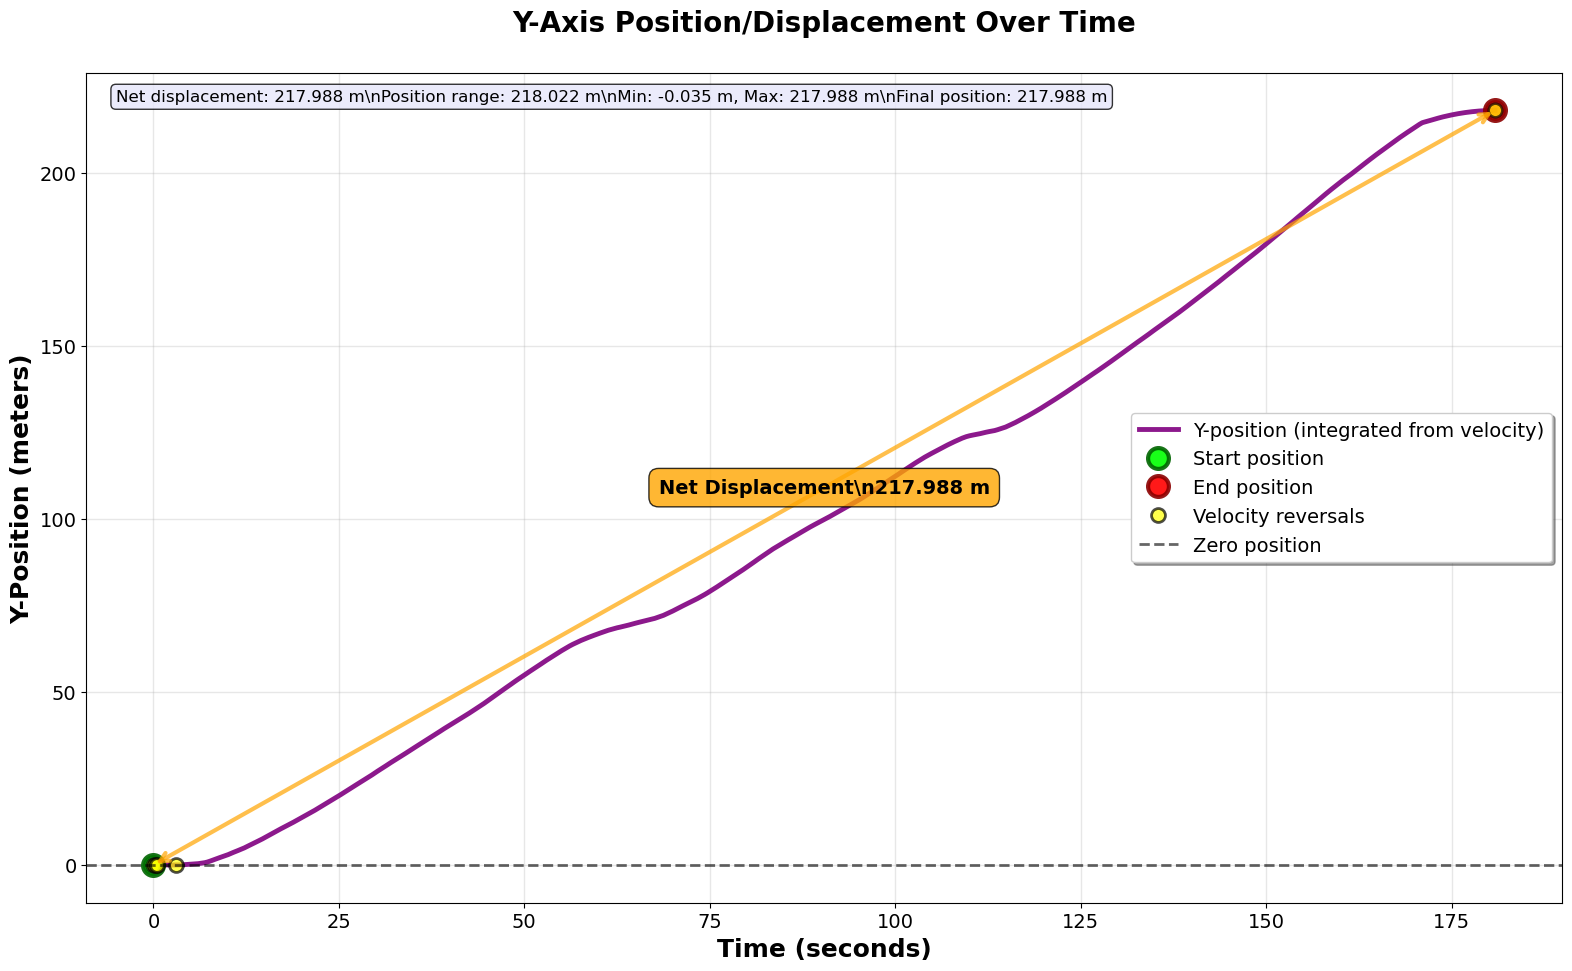

Enhanced Y-Axis Position/Displacement Plot Generated


In [210]:
# Enhanced Plot 3: Y-Axis Position/Displacement Profile
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Plot position trajectory
    ax.plot(simple_results['time'], simple_results['pos_y'], 'purple', linewidth=3.5, alpha=0.9,
            label='Y-position (integrated from velocity)')
    
    # Mark start and end points with larger, more prominent markers
    ax.plot(simple_results['time'][0], simple_results['pos_y'][0], 'go', markersize=15, 
           alpha=0.9, markeredgecolor='darkgreen', markeredgewidth=3, 
           markerfacecolor='lime', label='Start position')
    ax.plot(simple_results['time'][-1], simple_results['pos_y'][-1], 'ro', markersize=15, 
           alpha=0.9, markeredgecolor='darkred', markeredgewidth=3, 
           markerfacecolor='red', label='End position')
    
    # Mark turning points in position
    if simple_results['n_turning_points'] > 0:
        for turn_idx in simple_results['turning_points']:
            ax.plot(simple_results['time'][turn_idx], simple_results['pos_y'][turn_idx], 
                   'ko', markersize=10, alpha=0.7, markeredgecolor='black', 
                   markeredgewidth=2, markerfacecolor='yellow')
        
        # Add legend entry for turning points
        ax.plot([], [], 'ko', markersize=10, alpha=0.7, markeredgecolor='black', 
               markeredgewidth=2, markerfacecolor='yellow', label='Velocity reversals')
    
    # Add zero reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.6, linewidth=2, label='Zero position')
    
    # Add displacement arrow
    ax.annotate('', xy=(simple_results['time'][-1], simple_results['pos_y'][-1]), 
               xytext=(simple_results['time'][0], simple_results['pos_y'][0]),
               arrowprops=dict(arrowstyle='<->', color='orange', lw=3, alpha=0.7))
    
    # Add displacement text
    displacement = simple_results['total_displacement']
    mid_time = (simple_results['time'][0] + simple_results['time'][-1]) / 2
    mid_pos = (simple_results['pos_y'][0] + simple_results['pos_y'][-1]) / 2
    ax.text(mid_time, mid_pos, f'Net Displacement\\n{displacement:.3f} m', 
           ha='center', va='center', fontsize=14, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='orange', alpha=0.8))
    
    ax.set_title('Y-Axis Position/Displacement Over Time', fontweight='bold', pad=30)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Y-Position (meters)', fontweight='bold')
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linewidth=1)
    
    # Position statistics
    total_displacement = simple_results['total_displacement']
    max_position = np.max(simple_results['pos_y'])
    min_position = np.min(simple_results['pos_y'])
    position_range = max_position - min_position
    final_pos = simple_results['final_position']
    
    # Add statistics text box
    pos_stats = f"Net displacement: {total_displacement:.3f} m\\n"
    pos_stats += f"Position range: {position_range:.3f} m\\n"
    pos_stats += f"Min: {min_position:.3f} m, Max: {max_position:.3f} m\\n"
    pos_stats += f"Final position: {final_pos:.3f} m"
    
    ax.text(0.02, 0.98, pos_stats, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("Enhanced Y-Axis Position/Displacement Plot Generated")
else:
    print("ERROR: No simplified results available. Run the Y-axis analysis first.")

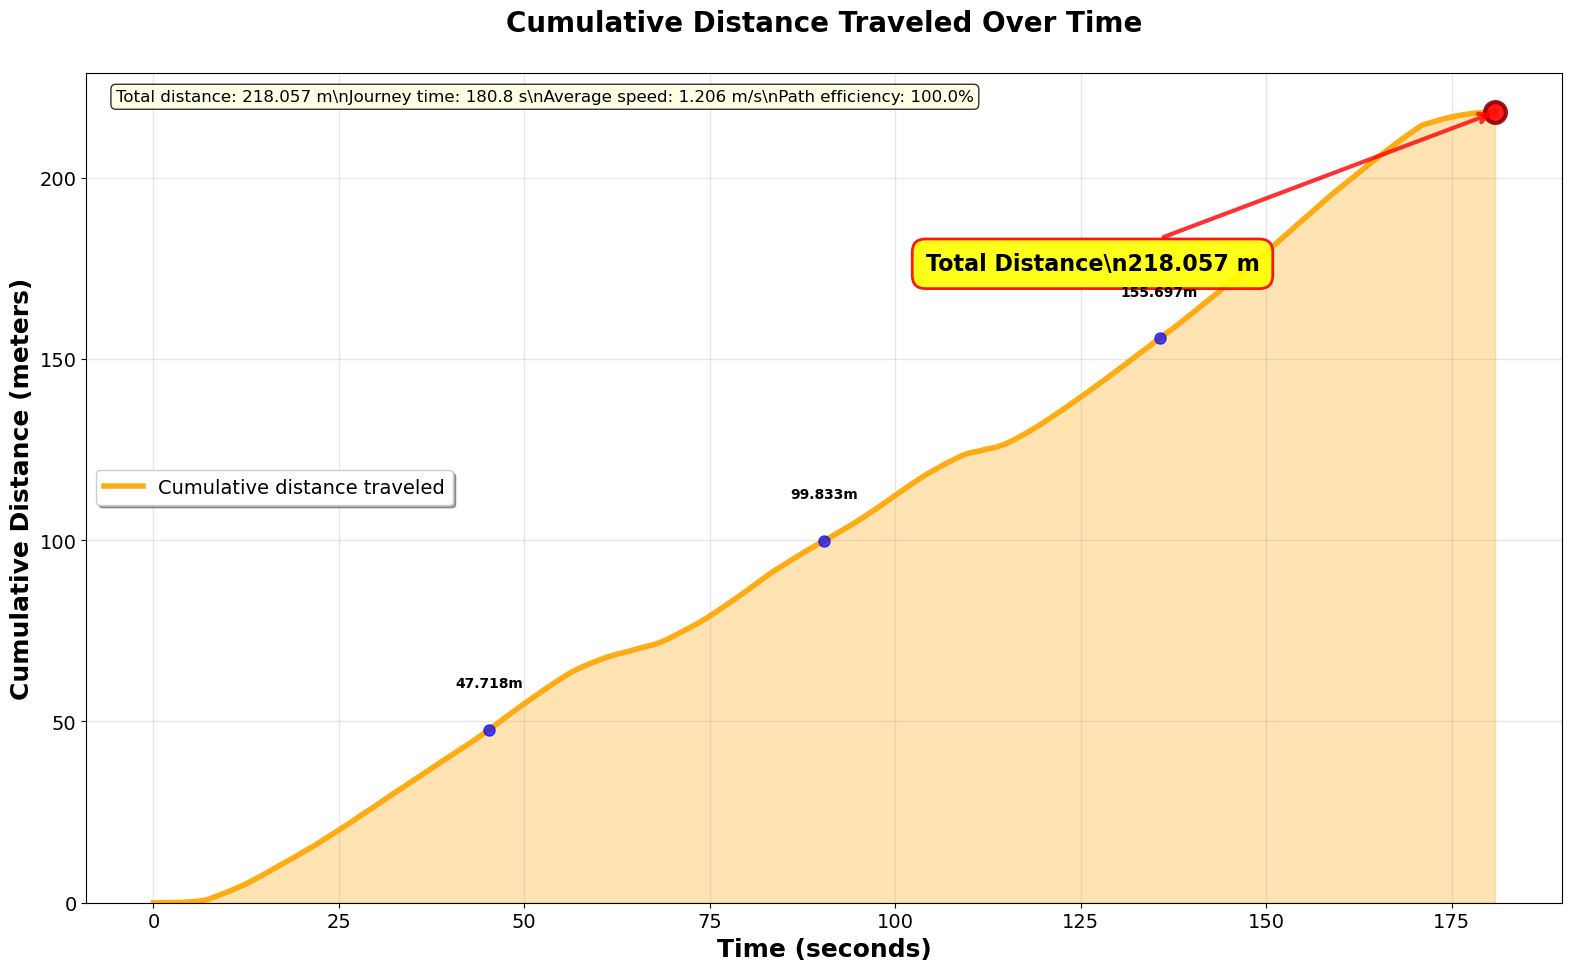

Enhanced Cumulative Distance Plot Generated
Path Analysis Complete - Total Distance: 218.057 m


In [211]:
# Enhanced Plot 4: Cumulative Distance Over Time
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Calculate cumulative distance
    position_diffs = np.abs(np.diff(simple_results['pos_y']))
    cumulative_distances = np.cumsum(position_diffs)
    cumulative_distances = np.insert(cumulative_distances, 0, 0)  # Add zero at start
    
    # Plot cumulative distance with gradient fill
    ax.plot(simple_results['time'], cumulative_distances, 'orange', linewidth=4, alpha=0.9,
            label='Cumulative distance traveled')
    
    # Fill under the curve with gradient effect
    ax.fill_between(simple_results['time'], cumulative_distances, alpha=0.3, color='orange')
    
    # Mark final distance with prominent annotation
    final_distance = cumulative_distances[-1]
    ax.plot(simple_results['time'][-1], final_distance, 'ro', markersize=15, 
           alpha=0.9, markeredgecolor='darkred', markeredgewidth=3, markerfacecolor='red')
    
    # Add final distance annotation with callout
    ax.annotate(f'Total Distance\\n{final_distance:.3f} m', 
               xy=(simple_results['time'][-1], final_distance),
               xytext=(simple_results['time'][-1] * 0.7, final_distance * 0.8),
               fontsize=16, fontweight='bold', ha='center',
               arrowprops=dict(arrowstyle='->', color='red', lw=3, alpha=0.8),
               bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', 
                        edgecolor='red', linewidth=2, alpha=0.9))
    
    # Add intermediate distance markers
    quarter_points = [len(cumulative_distances)//4, len(cumulative_distances)//2, 3*len(cumulative_distances)//4]
    for i, point in enumerate(quarter_points):
        time_point = simple_results['time'][point]
        dist_point = cumulative_distances[point]
        ax.plot(time_point, dist_point, 'bo', markersize=8, alpha=0.7)
        ax.text(time_point, dist_point + final_distance*0.05, f'{dist_point:.3f}m', 
               ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title('Cumulative Distance Traveled Over Time', fontweight='bold', pad=30)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Cumulative Distance (meters)', fontweight='bold')
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linewidth=1)
    
    # Add statistics text box
    avg_speed = final_distance / simple_results['time'][-1]
    distance_stats = f"Total distance: {final_distance:.3f} m\\n"
    distance_stats += f"Journey time: {simple_results['time'][-1]:.1f} s\\n"
    distance_stats += f"Average speed: {avg_speed:.3f} m/s\\n"
    distance_stats += f"Path efficiency: {simple_results['total_displacement']/final_distance*100:.1f}%"
    
    ax.text(0.02, 0.98, distance_stats, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # Set y-axis to start from 0
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()
    
    print("Enhanced Cumulative Distance Plot Generated")
    print(f"Path Analysis Complete - Total Distance: {final_distance:.3f} m")
else:
    print("ERROR: No simplified results available. Run the Y-axis analysis first.")

## Improved Separated Plots for Analysis

The following cells provide cleaner, larger plots for detailed analysis of the Y-axis results and raw data progression.

=== RAW DATA ANALYSIS - Y-AXIS PROGRESSION ===


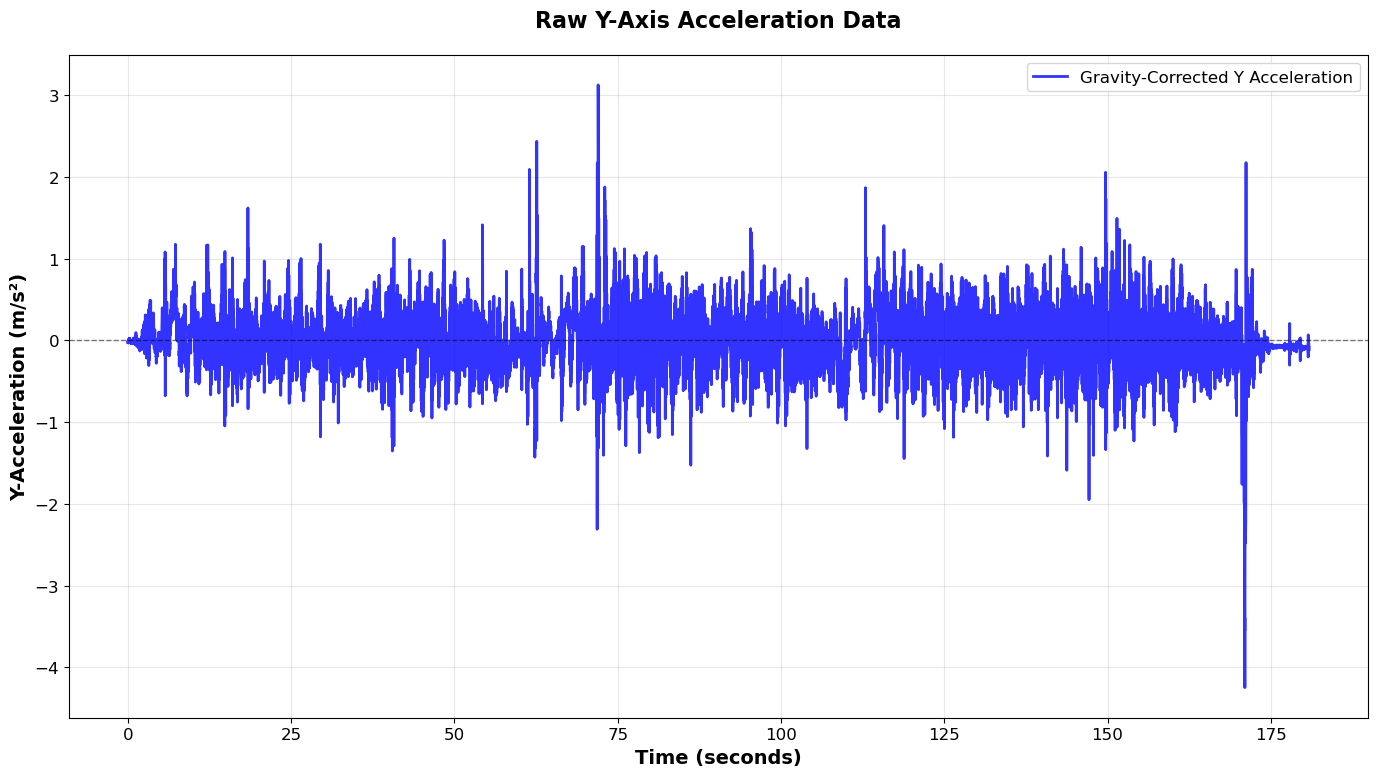

Raw acceleration data duration: 180.8 seconds
Raw acceleration range: [-4.246, 3.125] m/s²
Raw acceleration std deviation: 0.328 m/s²


In [212]:
# Set up improved plotting parameters
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# Raw Data Analysis: Y-Axis Acceleration Progression
print("=== RAW DATA ANALYSIS - Y-AXIS PROGRESSION ===")

# Plot 1: Raw Y-Axis Acceleration
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Show original raw acceleration
if 'acc_y_corrected' in path_data_corrected.columns:
    original_acc = path_data_corrected['acc_y_corrected']
    original_time = path_data_corrected['time']
    ax.plot(original_time, original_acc, 'b-', linewidth=2, alpha=0.8, label='Gravity-Corrected Y Acceleration')
else:
    original_acc = path_data_corrected['acc_y'] - path_data_corrected['acc_y'].median()
    original_time = path_data_corrected['time']
    ax.plot(original_time, original_acc, 'b-', linewidth=2, alpha=0.8, label='Raw Y Acceleration (Bias Removed)')

# Highlight the motion period if trimming was applied
if SIMPLE_CONFIG['trim_stationary_periods'] and 'simple_results' in globals():
    start_time = original_time.iloc[simple_results['motion_start_idx']]
    end_time = original_time.iloc[simple_results['motion_end_idx']]
    ax.axvspan(start_time, end_time, alpha=0.2, color='green', label='Motion Period (Used for Analysis)')

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax.set_title('Raw Y-Axis Acceleration Data', fontweight='bold', pad=20)
ax.set_xlabel('Time (seconds)', fontweight='bold')
ax.set_ylabel('Y-Acceleration (m/s²)', fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Raw acceleration data duration: {original_time.iloc[-1]:.1f} seconds")
print(f"Raw acceleration range: [{original_acc.min():.3f}, {original_acc.max():.3f}] m/s²")
print(f"Raw acceleration std deviation: {original_acc.std():.3f} m/s²")

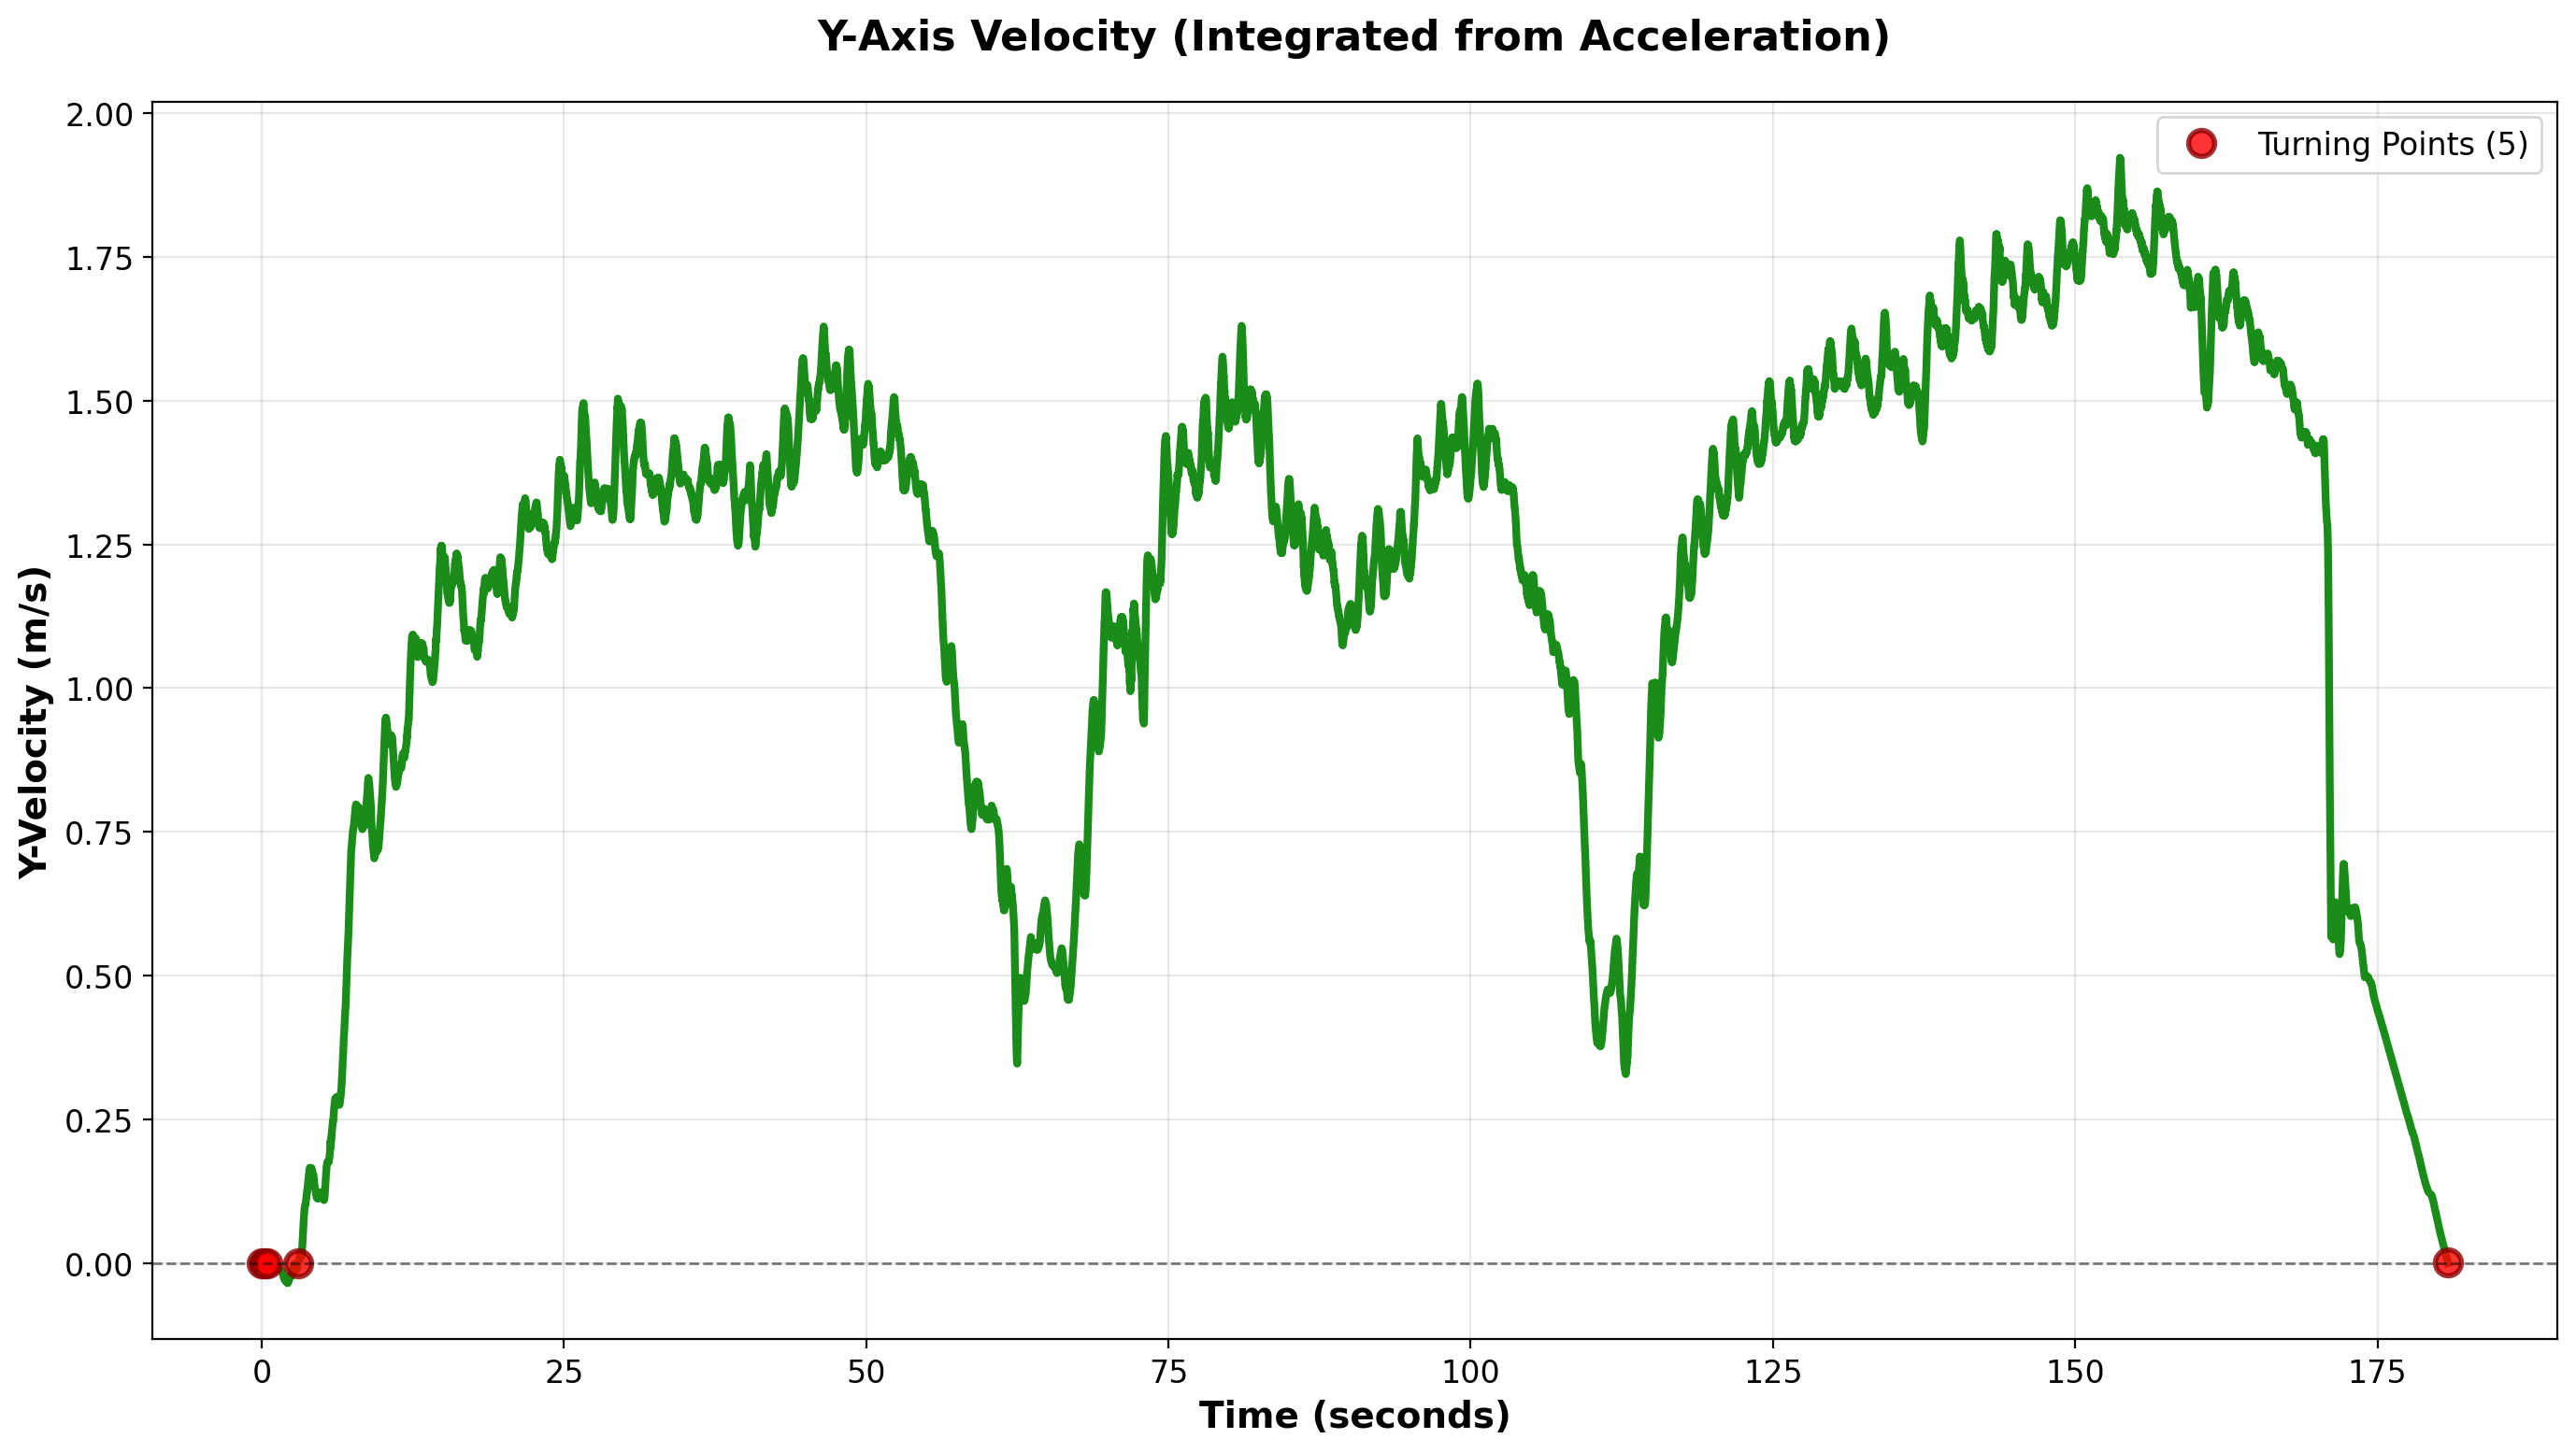

Velocity Analysis:
  Maximum speed: 1.922 m/s
  Mean speed: 1.206 m/s
  Final velocity: -0.000000 m/s (should be ~0 if constraint applied)
  Number of direction changes: 5


In [213]:
# Plot 2: Y-Axis Velocity (Integrated from Acceleration)
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(14, 8), dpi = 200)
    
    ax.plot(simple_results['time'], simple_results['vel_y'], 'g-', linewidth=3, alpha=0.9)
    
    # Mark turning points (velocity sign changes)
    if simple_results['n_turning_points'] > 0:
        for turn_idx in simple_results['turning_points']:
            ax.plot(simple_results['time'][turn_idx], simple_results['vel_y'][turn_idx], 
                   'ro', markersize=10, alpha=0.8, markeredgecolor='darkred', markeredgewidth=2)
        # Add legend entry for turning points
        ax.plot([], [], 'ro', markersize=10, alpha=0.8, markeredgecolor='darkred', markeredgewidth=2,
               label=f'Turning Points ({simple_results["n_turning_points"]})')
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_title('Y-Axis Velocity (Integrated from Acceleration)', fontweight='bold', pad=20)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Y-Velocity (m/s)', fontweight='bold')
    if simple_results['n_turning_points'] > 0:
        ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Velocity statistics
    max_speed = np.max(np.abs(simple_results['vel_y']))
    mean_speed = np.mean(np.abs(simple_results['vel_y']))
    final_vel = simple_results['final_velocity']
    
    print(f"Velocity Analysis:")
    print(f"  Maximum speed: {max_speed:.3f} m/s")
    print(f"  Mean speed: {mean_speed:.3f} m/s")
    print(f"  Final velocity: {final_vel:.6f} m/s (should be ~0 if constraint applied)")
    print(f"  Number of direction changes: {simple_results['n_turning_points']}")
else:
    print("No simplified results available. Run the simplified analysis first.")

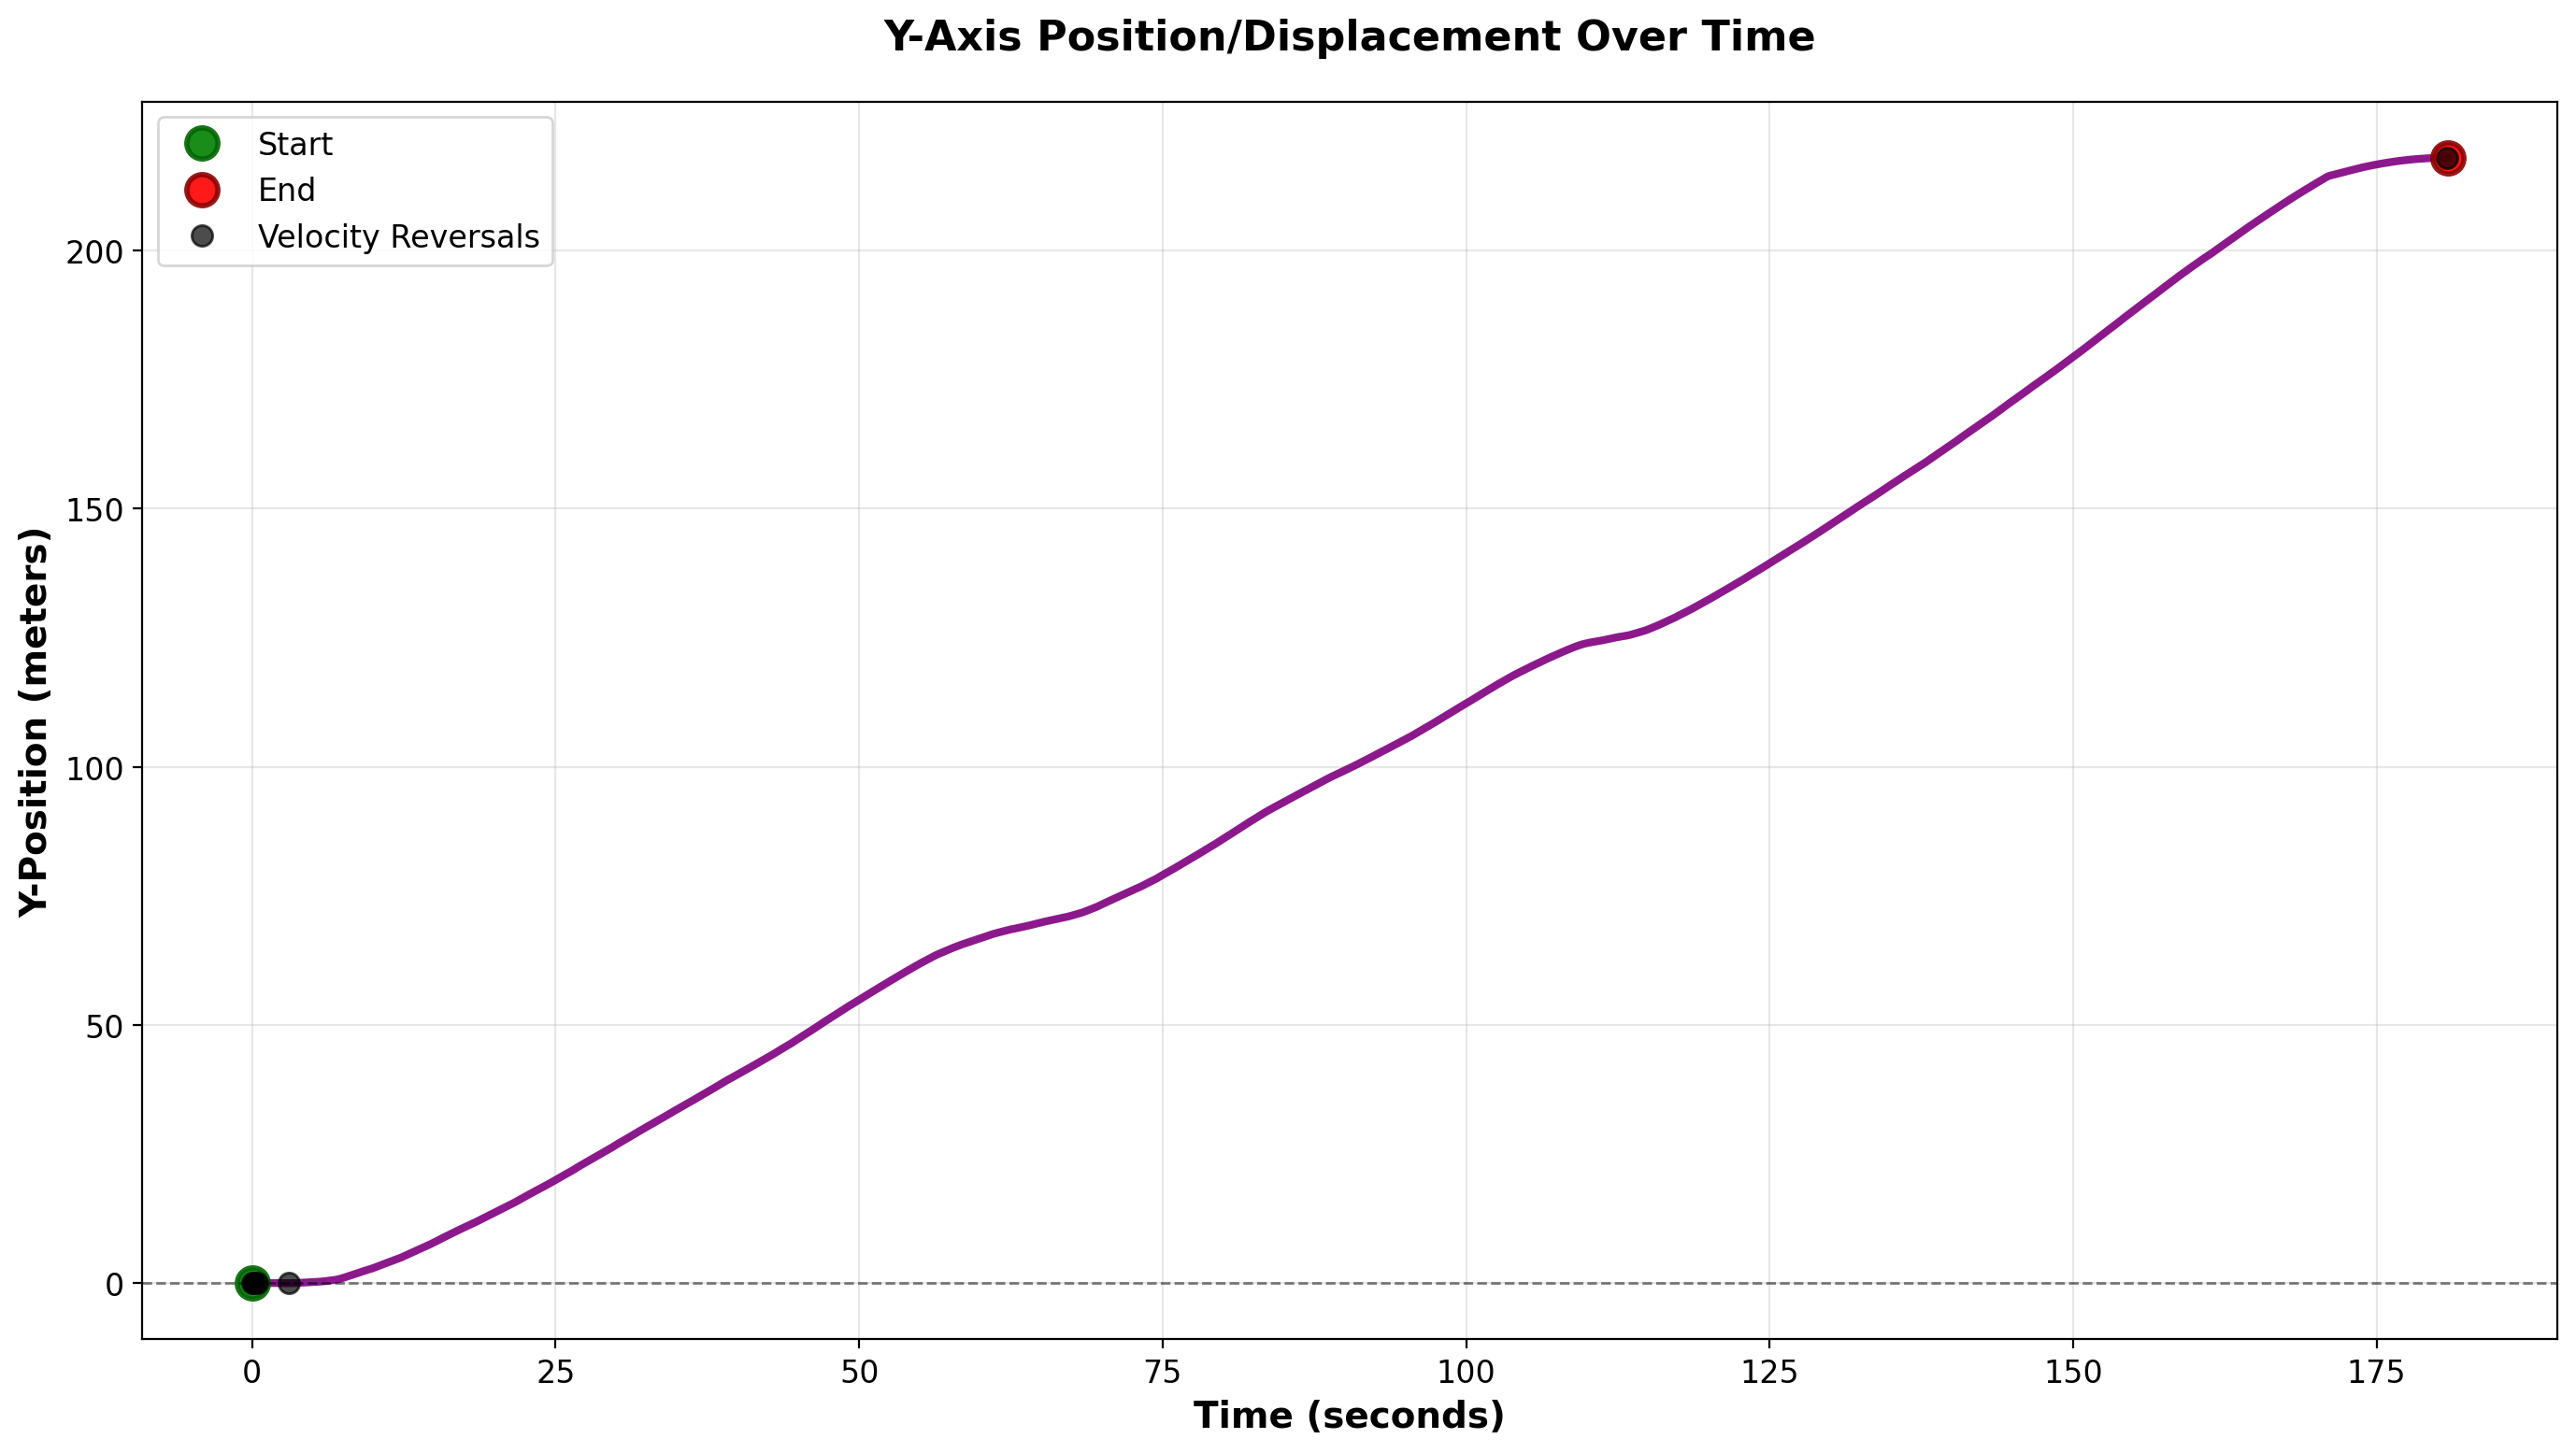

Position Analysis:
  Total displacement (|end - start|): 217.988 m
  Position range: 218.022 m (from -0.035 to 217.988 m)
  Final position: 217.988 m
  Net displacement: 217.988 m


In [214]:
# Plot 3: Y-Axis Position/Displacement (Integrated from Velocity)
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(14, 8), dpi = 200)
    
    ax.plot(simple_results['time'], simple_results['pos_y'], 'purple', linewidth=3, alpha=0.9)
    
    # Mark start and end points
    ax.plot(simple_results['time'][0], simple_results['pos_y'][0], 'go', markersize=12, 
           alpha=0.9, markeredgecolor='darkgreen', markeredgewidth=2, label='Start')
    ax.plot(simple_results['time'][-1], simple_results['pos_y'][-1], 'ro', markersize=12, 
           alpha=0.9, markeredgecolor='darkred', markeredgewidth=2, label='End')
    
    # Mark turning points in position
    if simple_results['n_turning_points'] > 0:
        for turn_idx in simple_results['turning_points']:
            ax.plot(simple_results['time'][turn_idx], simple_results['pos_y'][turn_idx], 
                   'ko', markersize=8, alpha=0.7, markeredgecolor='black', markeredgewidth=1)
        # Add legend entry for turning points
        ax.plot([], [], 'ko', markersize=8, alpha=0.7, markeredgecolor='black', markeredgewidth=1,
               label='Velocity Reversals')
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_title('Y-Axis Position/Displacement Over Time', fontweight='bold', pad=20)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Y-Position (meters)', fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Position statistics
    total_displacement = simple_results['total_displacement']
    max_position = np.max(simple_results['pos_y'])
    min_position = np.min(simple_results['pos_y'])
    position_range = max_position - min_position
    final_pos = simple_results['final_position']
    
    print(f"Position Analysis:")
    print(f"  Total displacement (|end - start|): {total_displacement:.3f} m")
    print(f"  Position range: {position_range:.3f} m (from {min_position:.3f} to {max_position:.3f} m)")
    print(f"  Final position: {final_pos:.3f} m")
    print(f"  Net displacement: {final_pos:.3f} m")
else:
    print("No simplified results available. Run the simplified analysis first.")

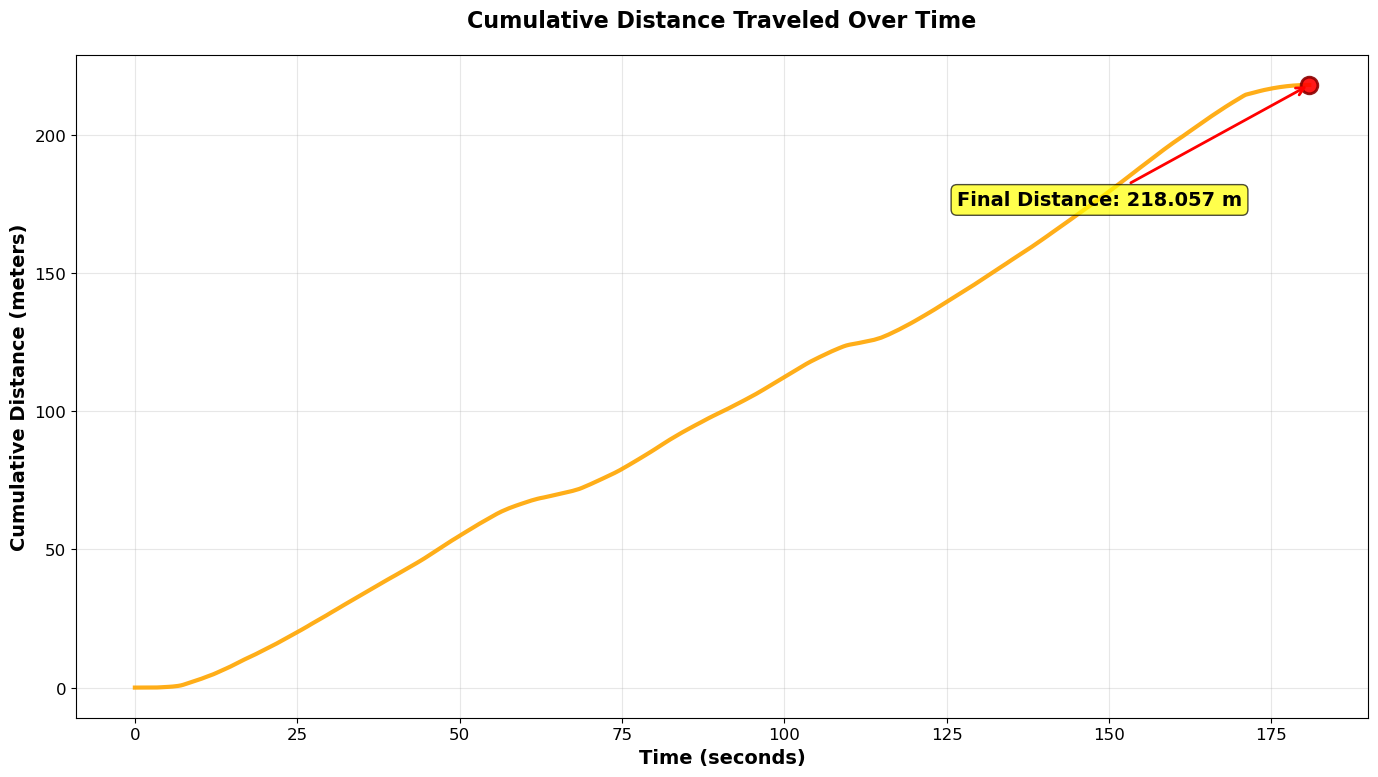

Cumulative Distance Analysis:
  Final cumulative distance: 218.057 m
  Average speed over journey: 1.206 m/s


In [215]:
# Plot 4: Cumulative Distance Over Time
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Calculate cumulative distance
    position_diffs = np.abs(np.diff(simple_results['pos_y']))
    cumulative_distances = np.cumsum(position_diffs)
    cumulative_distances = np.insert(cumulative_distances, 0, 0)  # Add zero at start
    
    ax.plot(simple_results['time'], cumulative_distances, 'orange', linewidth=3, alpha=0.9)
    
    # Mark final distance
    final_distance = cumulative_distances[-1]
    ax.plot(simple_results['time'][-1], final_distance, 'ro', markersize=12, 
           alpha=0.9, markeredgecolor='darkred', markeredgewidth=2)
    
    # Add text annotation for final distance
    ax.annotate(f'Final Distance: {final_distance:.3f} m', 
               xy=(simple_results['time'][-1], final_distance),
               xytext=(simple_results['time'][-1] * 0.7, final_distance * 0.8),
               fontsize=14, fontweight='bold',
               arrowprops=dict(arrowstyle='->', color='red', lw=2),
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.set_title('Cumulative Distance Traveled Over Time', fontweight='bold', pad=20)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Cumulative Distance (meters)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Cumulative Distance Analysis:")
    print(f"  Final cumulative distance: {final_distance:.3f} m")
    print(f"  Average speed over journey: {final_distance / simple_results['time'][-1]:.3f} m/s")
else:
    print("No simplified results available. Run the simplified analysis first.")

## Enhanced Raw Data Analysis Plots

High-quality, separate plots for raw data analysis including raw acceleration, integrated velocity, and displacement.

=== ENHANCED RAW DATA ANALYSIS ===


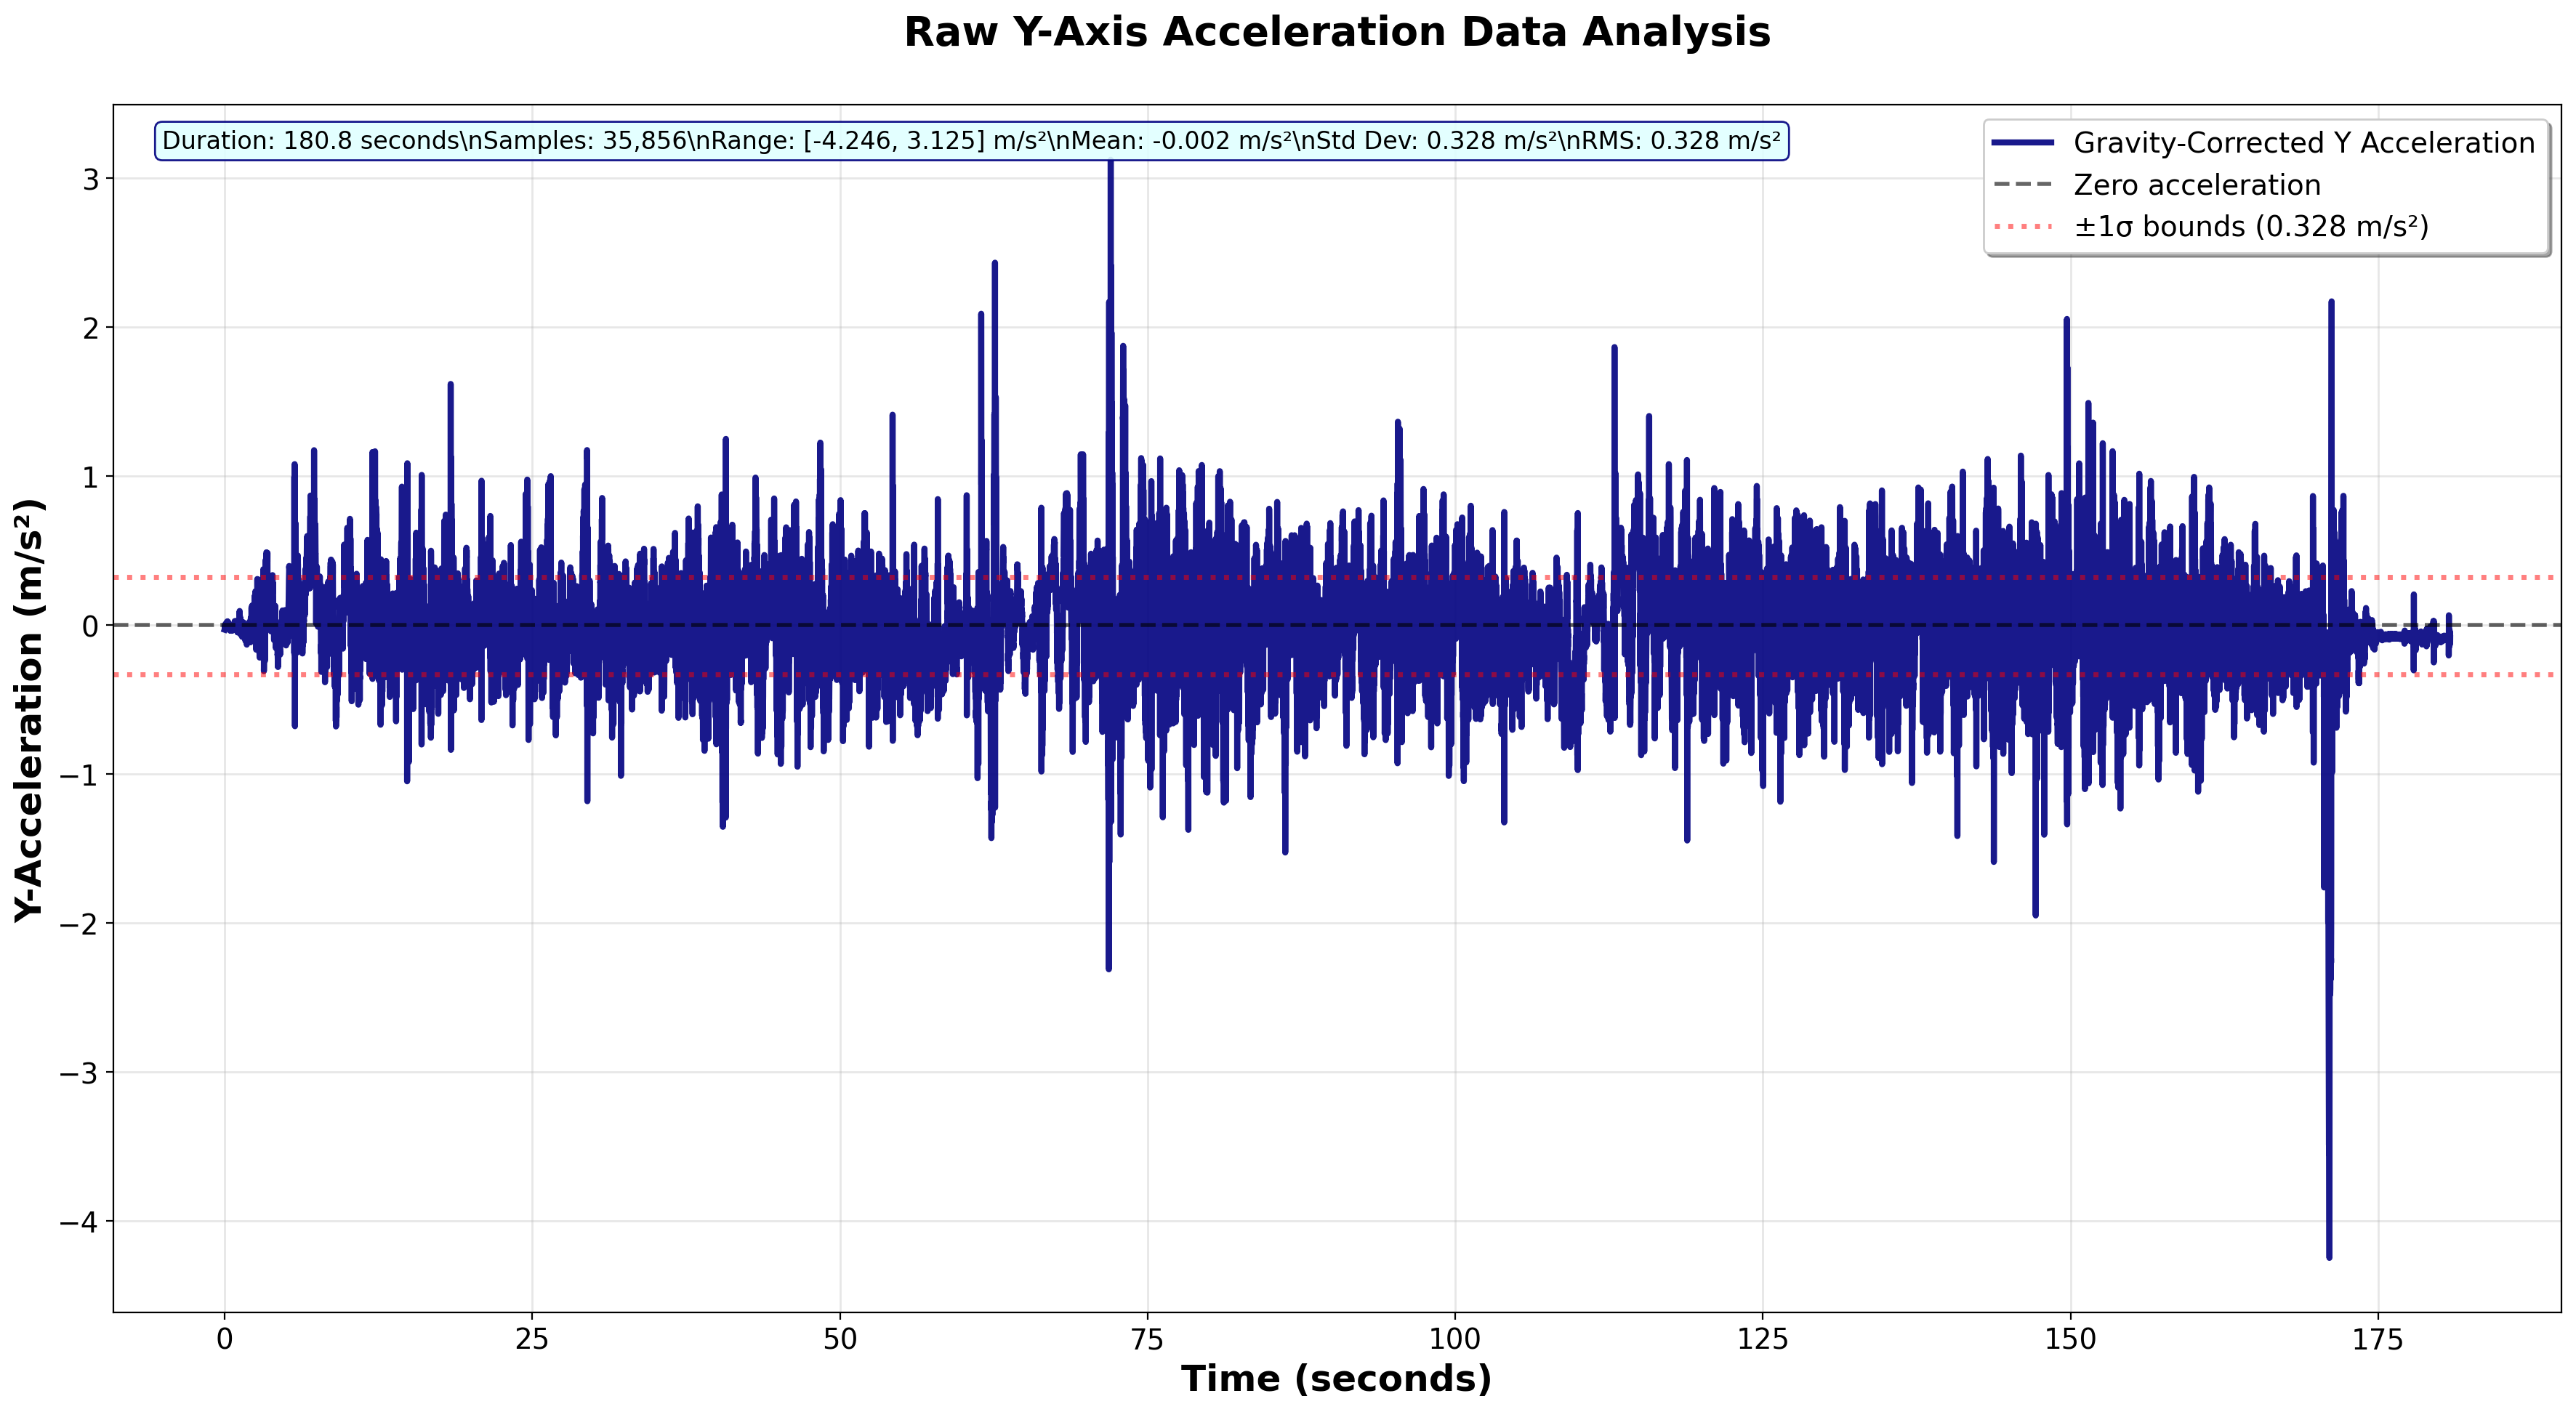

Raw Y-Acceleration Analysis:
  Duration: 180.8 seconds
  Sample count: 35,856
  Acceleration range: [-4.246, 3.125] m/s²
  Standard deviation: 0.328 m/s²


In [216]:
# Enhanced Raw Data Plot 1: Raw Y-Axis Acceleration
print("=== ENHANCED RAW DATA ANALYSIS ===")

# Reset plotting parameters for raw data analysis
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 22,
    'lines.linewidth': 2.5,
    'lines.markersize': 8,
    'figure.dpi': 100,
    'savefig.dpi': 300
})

fig, ax = plt.subplots(1, 1, figsize=(18, 10), dpi = 200)

# Show original raw acceleration
if 'acc_y_corrected' in path_data_corrected.columns:
    original_acc = path_data_corrected['acc_y_corrected']
    original_time = path_data_corrected['time']
    main_label = 'Gravity-Corrected Y Acceleration'
    color = 'navy'
else:
    original_acc = path_data_corrected['acc_y'] - path_data_corrected['acc_y'].median()
    original_time = path_data_corrected['time']
    main_label = 'Raw Y Acceleration (Bias Removed)'
    color = 'darkblue'

# Main acceleration plot with thicker line
ax.plot(original_time, original_acc, color=color, linewidth=3, alpha=0.9, label=main_label)

# Highlight the motion period if trimming was applied
if SIMPLE_CONFIG['trim_stationary_periods'] and 'simple_results' in globals():
    start_time = original_time.iloc[simple_results['motion_start_idx']]
    end_time = original_time.iloc[simple_results['motion_end_idx']]
    ax.axvspan(start_time, end_time, alpha=0.25, color='green', 
              label='Motion Period (Used for Integration)')
    
    # Add vertical lines to mark boundaries
    ax.axvline(x=start_time, color='green', linestyle=':', linewidth=2, alpha=0.8)
    ax.axvline(x=end_time, color='green', linestyle=':', linewidth=2, alpha=0.8)

# Add zero reference line
ax.axhline(y=0, color='black', linestyle='--', alpha=0.6, linewidth=2, label='Zero acceleration')

# Add statistical bounds
acc_mean = original_acc.mean()
acc_std = original_acc.std()
ax.axhline(y=acc_mean + acc_std, color='red', linestyle=':', alpha=0.5, 
          label=f'±1σ bounds ({acc_std:.3f} m/s²)')
ax.axhline(y=acc_mean - acc_std, color='red', linestyle=':', alpha=0.5)

ax.set_title('Raw Y-Axis Acceleration Data Analysis', fontweight='bold', pad=30)
ax.set_xlabel('Time (seconds)', fontweight='bold')
ax.set_ylabel('Y-Acceleration (m/s²)', fontweight='bold')
ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linewidth=1)

# Add comprehensive statistics text box
acc_stats = f"Duration: {original_time.iloc[-1]:.1f} seconds\\n"
acc_stats += f"Samples: {len(original_acc):,}\\n"
acc_stats += f"Range: [{original_acc.min():.3f}, {original_acc.max():.3f}] m/s²\\n"
acc_stats += f"Mean: {acc_mean:.3f} m/s²\\n"
acc_stats += f"Std Dev: {acc_std:.3f} m/s²\\n"
acc_stats += f"RMS: {np.sqrt(np.mean(original_acc**2)):.3f} m/s²"

ax.text(0.02, 0.98, acc_stats, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', 
        alpha=0.9, edgecolor='navy', linewidth=1))

plt.tight_layout()
plt.show()

print(f"Raw Y-Acceleration Analysis:")
print(f"  Duration: {original_time.iloc[-1]:.1f} seconds")
print(f"  Sample count: {len(original_acc):,}")
print(f"  Acceleration range: [{original_acc.min():.3f}, {original_acc.max():.3f}] m/s²")
print(f"  Standard deviation: {acc_std:.3f} m/s²")

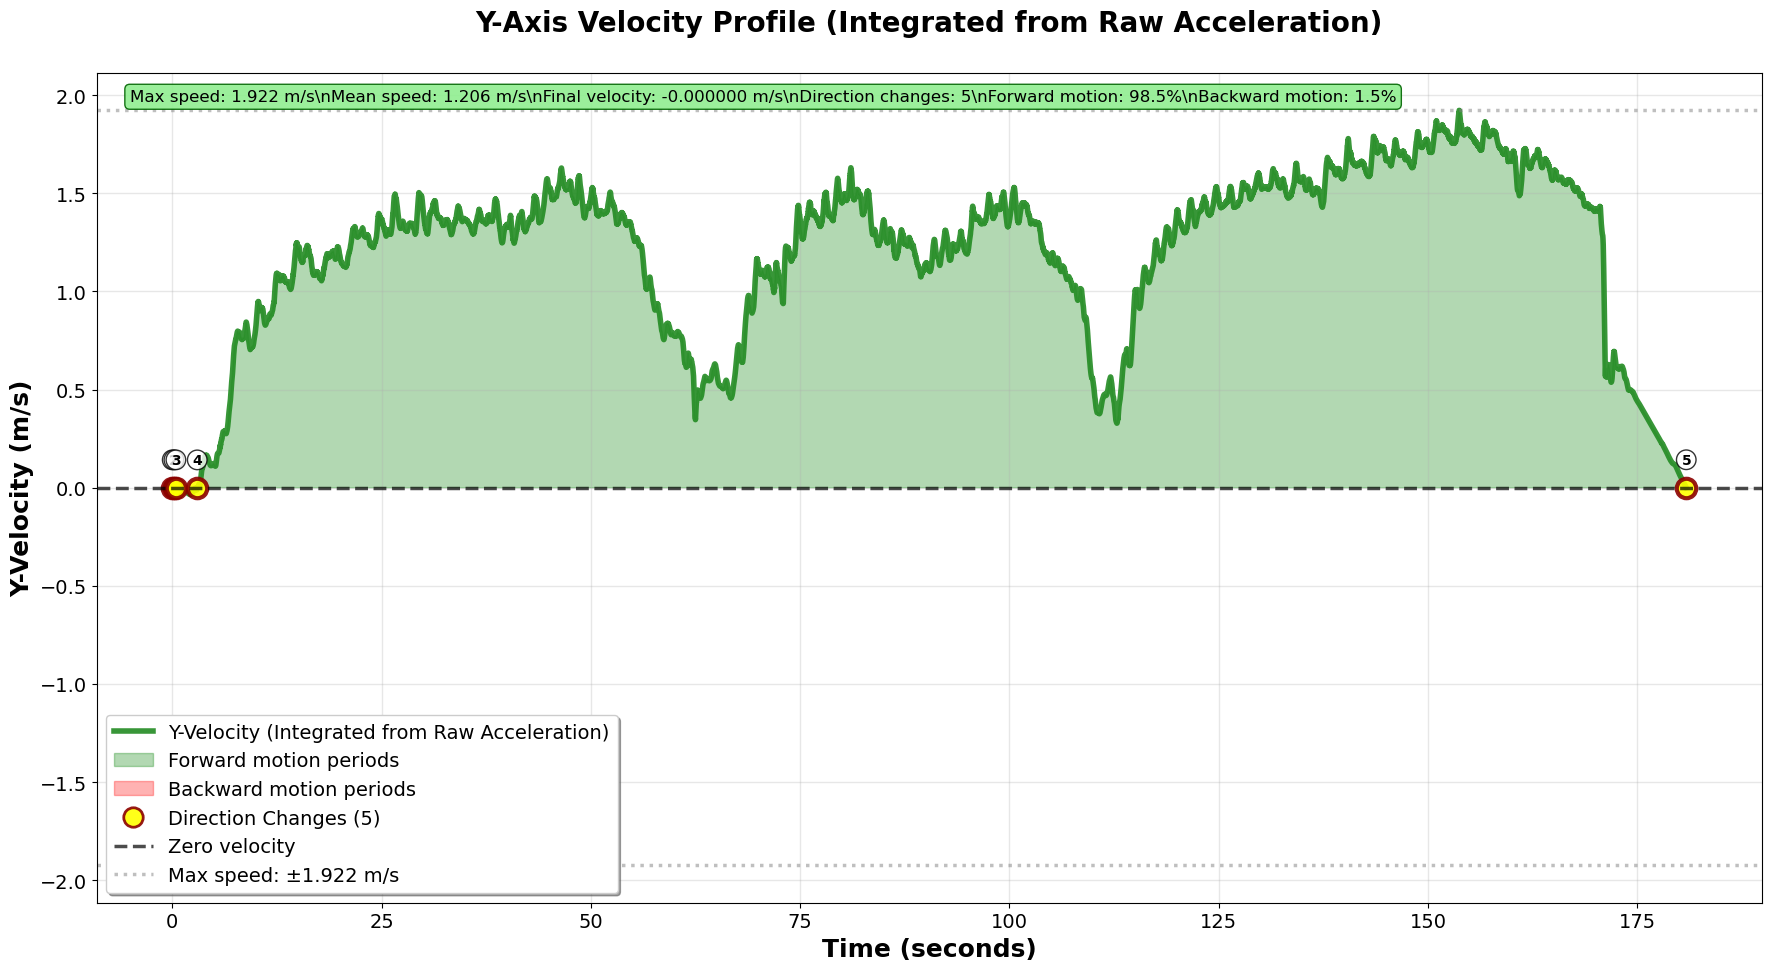

Enhanced Y-Velocity Analysis Generated


In [217]:
# Enhanced Raw Data Plot 2: Integrated Y-Axis Velocity
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    
    # Plot velocity with enhanced styling
    ax.plot(simple_results['time'], simple_results['vel_y'], 'forestgreen', 
           linewidth=4, alpha=0.9, label='Y-Velocity (Integrated from Raw Acceleration)')
    
    # Fill areas above/below zero with different colors
    ax.fill_between(simple_results['time'], simple_results['vel_y'], 0, 
                   where=(simple_results['vel_y'] >= 0), alpha=0.3, color='green', 
                   label='Forward motion periods', interpolate=True)
    ax.fill_between(simple_results['time'], simple_results['vel_y'], 0, 
                   where=(simple_results['vel_y'] < 0), alpha=0.3, color='red', 
                   label='Backward motion periods', interpolate=True)
    
    # Mark turning points with enhanced visibility
    if simple_results['n_turning_points'] > 0:
        for i, turn_idx in enumerate(simple_results['turning_points']):
            ax.plot(simple_results['time'][turn_idx], simple_results['vel_y'][turn_idx], 
                   'o', markersize=14, alpha=0.9, markeredgecolor='darkred', 
                   markeredgewidth=3, markerfacecolor='yellow')
            
            # Add turn number labels
            ax.annotate(f'{i+1}', 
                       xy=(simple_results['time'][turn_idx], simple_results['vel_y'][turn_idx]),
                       xytext=(0, 15), textcoords='offset points',
                       ha='center', va='bottom', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', alpha=0.8))
        
        # Legend entry for turning points
        ax.plot([], [], 'o', markersize=14, alpha=0.9, markeredgecolor='darkred', 
               markerfacecolor='yellow', markeredgewidth=2,
               label=f'Direction Changes ({simple_results["n_turning_points"]})')
    
    # Add zero reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=2.5, label='Zero velocity')
    
    # Add velocity bounds
    vel_max = np.max(np.abs(simple_results['vel_y']))
    ax.axhline(y=vel_max, color='gray', linestyle=':', alpha=0.5, label=f'Max speed: ±{vel_max:.3f} m/s')
    ax.axhline(y=-vel_max, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_title('Y-Axis Velocity Profile (Integrated from Raw Acceleration)', fontweight='bold', pad=30)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Y-Velocity (m/s)', fontweight='bold')
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linewidth=1)
    
    # Enhanced velocity statistics
    max_speed = np.max(np.abs(simple_results['vel_y']))
    mean_speed = np.mean(np.abs(simple_results['vel_y']))
    final_vel = simple_results['final_velocity']
    
    # Calculate time spent in forward vs backward motion
    forward_time = np.sum(simple_results['vel_y'] >= 0) / len(simple_results['vel_y']) * 100
    backward_time = 100 - forward_time
    
    vel_stats = f"Max speed: {max_speed:.3f} m/s\\n"
    vel_stats += f"Mean speed: {mean_speed:.3f} m/s\\n"
    vel_stats += f"Final velocity: {final_vel:.6f} m/s\\n"
    vel_stats += f"Direction changes: {simple_results['n_turning_points']}\\n"
    vel_stats += f"Forward motion: {forward_time:.1f}%\\n"
    vel_stats += f"Backward motion: {backward_time:.1f}%"
    
    ax.text(0.02, 0.98, vel_stats, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', 
            alpha=0.9, edgecolor='darkgreen', linewidth=1))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Enhanced Y-Velocity Analysis Generated")
else:
    print("ERROR: No simplified results available. Run the Y-axis analysis first.")

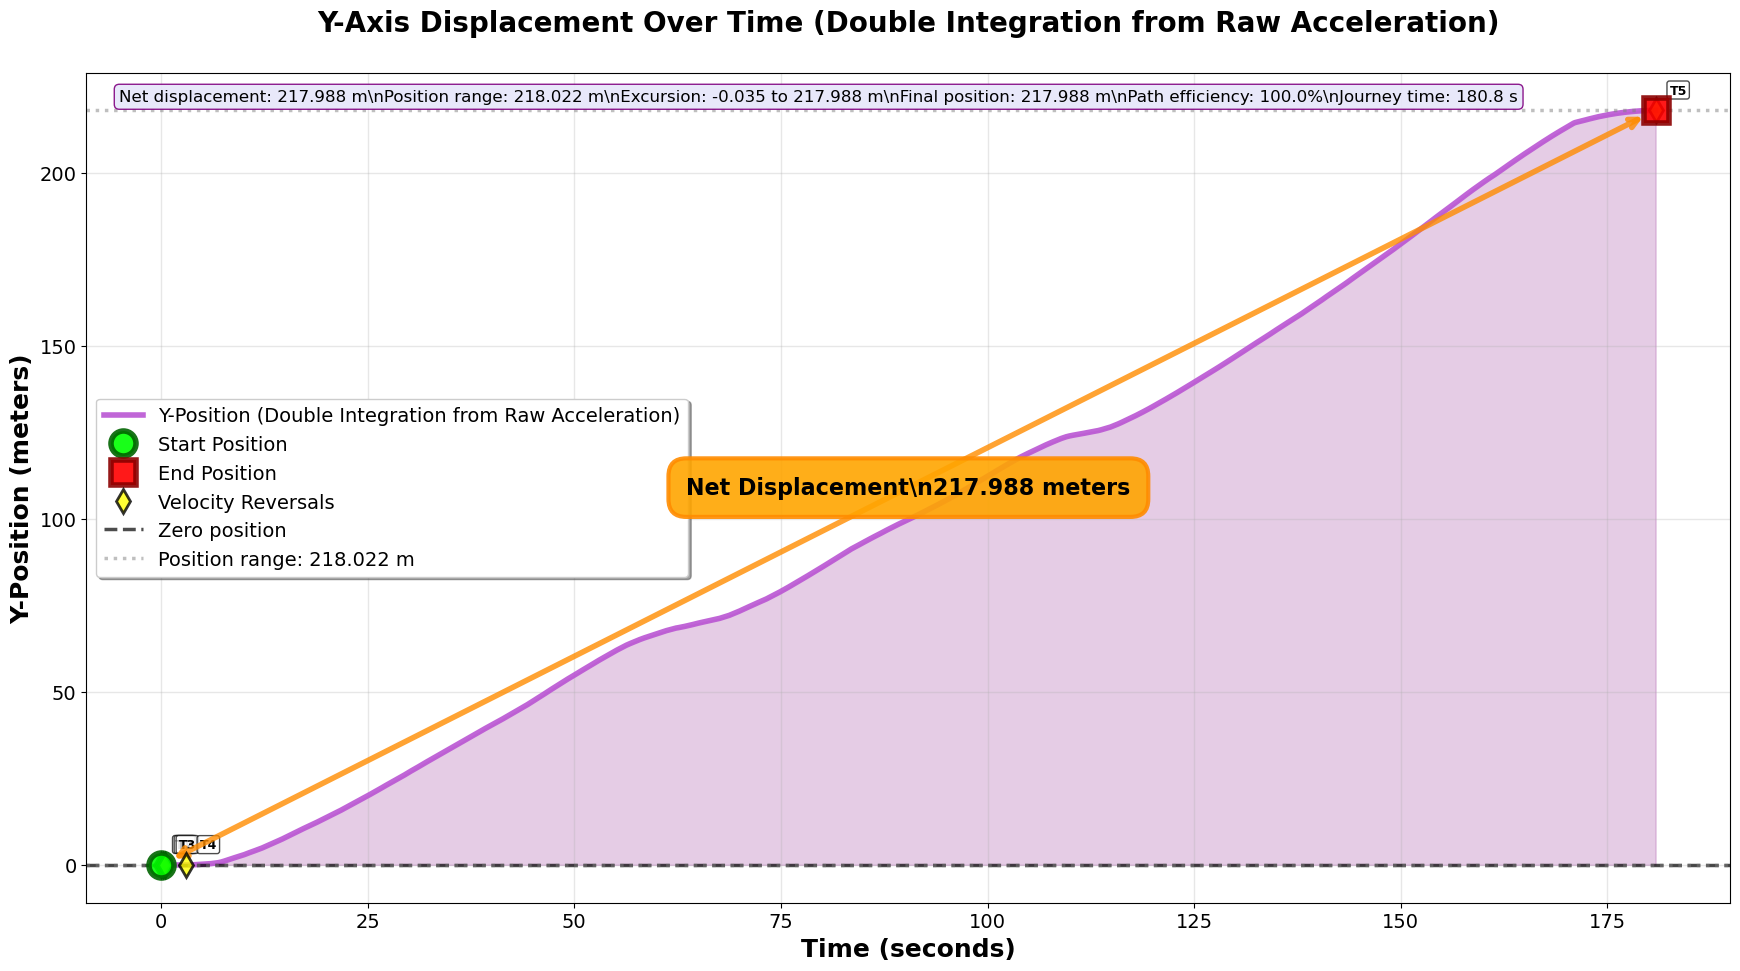

Enhanced Y-Displacement Analysis Generated
Final Results:
  Net displacement: 217.988 m
  Position range: 218.022 m
  Path efficiency: 100.0%


In [218]:
# Enhanced Raw Data Plot 3: Integrated Y-Axis Displacement
if 'simple_results' in globals():
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    
    # Plot position trajectory with enhanced styling
    ax.plot(simple_results['time'], simple_results['pos_y'], 'mediumorchid', 
           linewidth=4, alpha=0.9, label='Y-Position (Double Integration from Raw Acceleration)')
    
    # Add gradient fill under the curve to show displacement evolution
    ax.fill_between(simple_results['time'], simple_results['pos_y'], alpha=0.2, color='purple')
    
    # Mark start and end points with very prominent markers
    start_marker = ax.plot(simple_results['time'][0], simple_results['pos_y'][0], 'o', 
                          markersize=18, alpha=0.9, markeredgecolor='darkgreen', 
                          markeredgewidth=4, markerfacecolor='lime', 
                          label='Start Position', zorder=10)
    end_marker = ax.plot(simple_results['time'][-1], simple_results['pos_y'][-1], 's', 
                        markersize=18, alpha=0.9, markeredgecolor='darkred', 
                        markeredgewidth=4, markerfacecolor='red', 
                        label='End Position', zorder=10)
    
    # Mark turning points with enhanced visibility
    if simple_results['n_turning_points'] > 0:
        for i, turn_idx in enumerate(simple_results['turning_points']):
            ax.plot(simple_results['time'][turn_idx], simple_results['pos_y'][turn_idx], 
                   'd', markersize=12, alpha=0.8, markeredgecolor='black', 
                   markeredgewidth=2, markerfacecolor='yellow', zorder=8)
            
            # Add turn labels
            ax.annotate(f'T{i+1}', 
                       xy=(simple_results['time'][turn_idx], simple_results['pos_y'][turn_idx]),
                       xytext=(10, 10), textcoords='offset points',
                       ha='left', va='bottom', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # Legend entry for turning points
        ax.plot([], [], 'd', markersize=12, alpha=0.8, markeredgecolor='black', 
               markerfacecolor='yellow', markeredgewidth=2, label='Velocity Reversals')
    
    # Add zero reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=2.5, label='Zero position')
    
    # Add displacement arrow with enhanced styling
    displacement_arrow = ax.annotate('', 
                                   xy=(simple_results['time'][-1], simple_results['pos_y'][-1]), 
                                   xytext=(simple_results['time'][0], simple_results['pos_y'][0]),
                                   arrowprops=dict(arrowstyle='<->', color='darkorange', 
                                                 lw=4, alpha=0.8, shrinkA=10, shrinkB=10))
    
    # Add displacement measurement
    displacement = simple_results['total_displacement']
    mid_time = (simple_results['time'][0] + simple_results['time'][-1]) / 2
    mid_pos = (simple_results['pos_y'][0] + simple_results['pos_y'][-1]) / 2
    
    # Enhanced displacement annotation
    ax.annotate(f'Net Displacement\\n{displacement:.3f} meters', 
               xy=(mid_time, mid_pos), 
               xytext=(0, 0), textcoords='offset points',
               ha='center', va='center', fontsize=16, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.8', facecolor='orange', 
                        edgecolor='darkorange', linewidth=3, alpha=0.9),
               zorder=15)
    
    # Add position bounds
    pos_max = np.max(simple_results['pos_y'])
    pos_min = np.min(simple_results['pos_y'])
    ax.axhline(y=pos_max, color='gray', linestyle=':', alpha=0.5, 
              label=f'Position range: {pos_max-pos_min:.3f} m')
    ax.axhline(y=pos_min, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_title('Y-Axis Displacement Over Time (Double Integration from Raw Acceleration)', 
                fontweight='bold', pad=30)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Y-Position (meters)', fontweight='bold')
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linewidth=1)
    
    # Comprehensive position statistics
    total_displacement = simple_results['total_displacement']
    max_position = np.max(simple_results['pos_y'])
    min_position = np.min(simple_results['pos_y'])
    position_range = max_position - min_position
    final_pos = simple_results['final_position']
    
    # Calculate path efficiency
    path_length = simple_results.get('total_path_length', simple_results.get('cumulative_distance', 0))
    efficiency = (total_displacement / path_length * 100) if path_length > 0 else 0
    
    pos_stats = f"Net displacement: {total_displacement:.3f} m\\n"
    pos_stats += f"Position range: {position_range:.3f} m\\n"
    pos_stats += f"Excursion: {min_position:.3f} to {max_position:.3f} m\\n"
    pos_stats += f"Final position: {final_pos:.3f} m\\n"
    pos_stats += f"Path efficiency: {efficiency:.1f}%\\n"
    pos_stats += f"Journey time: {simple_results['time'][-1]:.1f} s"
    
    ax.text(0.02, 0.98, pos_stats, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lavender', 
            alpha=0.9, edgecolor='purple', linewidth=1))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Enhanced Y-Displacement Analysis Generated")
    print(f"Final Results:")
    print(f"  Net displacement: {total_displacement:.3f} m")
    print(f"  Position range: {position_range:.3f} m") 
    print(f"  Path efficiency: {efficiency:.1f}%")
else:
    print("ERROR: No simplified results available. Run the Y-axis analysis first.")

\n=== COMPREHENSIVE RAW ACCELERATION ANALYSIS ===


/tmp/ipykernel_61793/2932805738.py:94: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


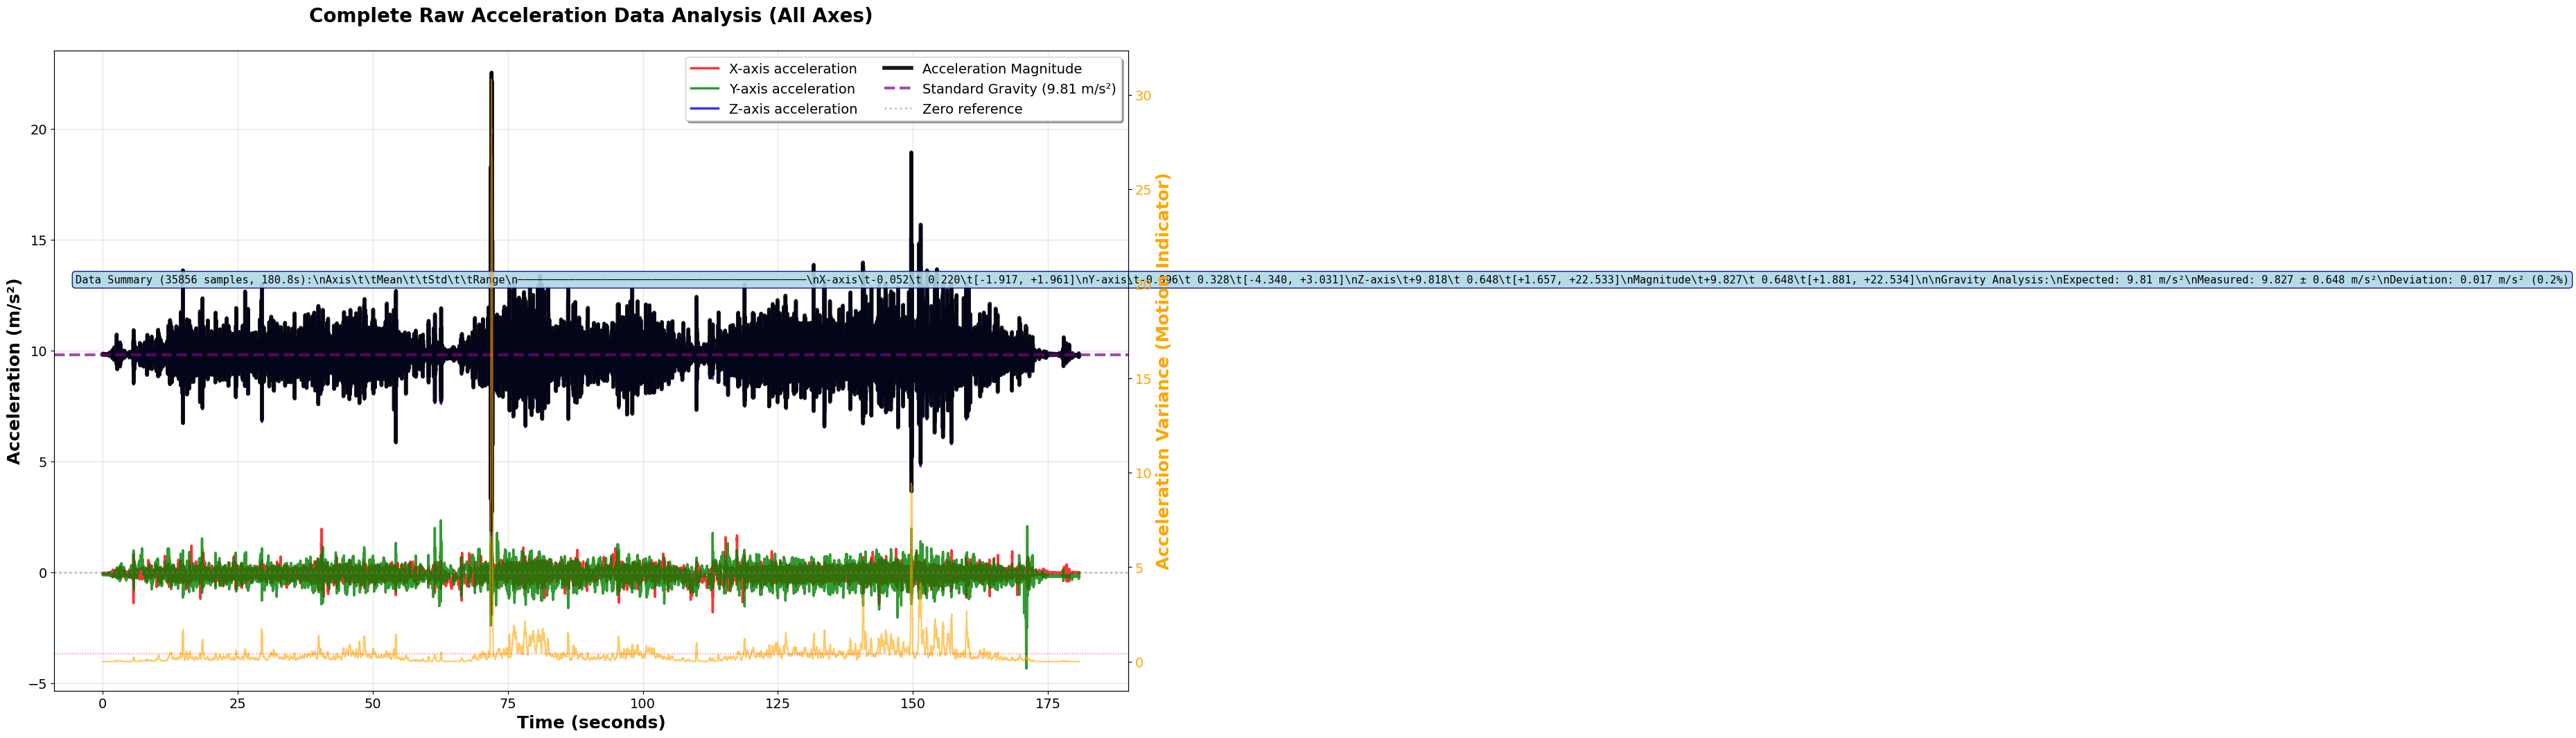

\nRaw Acceleration Analysis Summary:
X-axis      : Mean= -0.052, Std= 0.220, Range=[ -1.917,  +1.961] m/s²
Y-axis      : Mean= -0.096, Std= 0.328, Range=[ -4.340,  +3.031] m/s²
Z-axis      : Mean= +9.818, Std= 0.648, Range=[ +1.657, +22.533] m/s²
Magnitude   : Mean= +9.827, Std= 0.648, Range=[ +1.881, +22.534] m/s²
\nData Quality Assessment:
  Duration: 180.8 seconds
  Sample rate: ~198.3 Hz
  Gravity deviation: 0.017 m/s² (0.2%)
  Motion detection threshold: 0.422 m/s² variance


In [219]:
# Enhanced Raw Data Plot 4: Combined Raw Acceleration (All Axes + Magnitude)
print("\\n=== COMPREHENSIVE RAW ACCELERATION ANALYSIS ===")

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Plot all acceleration axes with distinct colors and styles
ax.plot(path_data_corrected['time'], path_data_corrected['acc_x'], 
       color='red', linewidth=2.5, alpha=0.8, label='X-axis acceleration', linestyle='-')
ax.plot(path_data_corrected['time'], path_data_corrected['acc_y'], 
       color='green', linewidth=2.5, alpha=0.8, label='Y-axis acceleration', linestyle='-')
ax.plot(path_data_corrected['time'], path_data_corrected['acc_z'], 
       color='blue', linewidth=2.5, alpha=0.8, label='Z-axis acceleration', linestyle='-')

# Calculate and plot acceleration magnitude with enhanced styling
acc_magnitude = np.sqrt(path_data_corrected['acc_x']**2 + 
                       path_data_corrected['acc_y']**2 + 
                       path_data_corrected['acc_z']**2)

ax.plot(path_data_corrected['time'], acc_magnitude, 
       color='black', linewidth=4, alpha=0.9, label='Acceleration Magnitude', linestyle='-')

# Add gravity reference lines
ax.axhline(y=9.81, color='purple', linestyle='--', alpha=0.7, linewidth=3, 
          label='Standard Gravity (9.81 m/s²)')
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5, linewidth=2, label='Zero reference')

# Highlight motion period if available
if SIMPLE_CONFIG['trim_stationary_periods'] and 'simple_results' in globals():
    start_time = path_data_corrected['time'].iloc[simple_results['motion_start_idx']]
    end_time = path_data_corrected['time'].iloc[simple_results['motion_end_idx']]
    ax.axvspan(start_time, end_time, alpha=0.15, color='orange', 
              label='Motion Period (Used for Analysis)', zorder=0)
    
    # Add motion period boundaries
    ax.axvline(x=start_time, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax.axvline(x=end_time, color='orange', linestyle=':', linewidth=2, alpha=0.8)

# Enhanced styling
ax.set_title('Complete Raw Acceleration Data Analysis (All Axes)', fontweight='bold', pad=30)
ax.set_xlabel('Time (seconds)', fontweight='bold')
ax.set_ylabel('Acceleration (m/s²)', fontweight='bold')
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, ncol=2)
ax.grid(True, alpha=0.3, linewidth=1)

# Calculate comprehensive statistics for all axes
stats_data = {
    'X-axis': path_data_corrected['acc_x'],
    'Y-axis': path_data_corrected['acc_y'], 
    'Z-axis': path_data_corrected['acc_z'],
    'Magnitude': acc_magnitude
}

# Create comprehensive statistics text
stats_text = f"Data Summary ({len(path_data_corrected)} samples, {path_data_corrected['time'].iloc[-1]:.1f}s):\\n"
stats_text += "Axis\\t\\tMean\\t\\tStd\\t\\tRange\\n"
stats_text += "─" * 45 + "\\n"

for axis_name, data in stats_data.items():
    mean_val = data.mean()
    std_val = data.std()
    min_val = data.min()
    max_val = data.max()
    stats_text += f"{axis_name}\\t{mean_val:+6.3f}\\t{std_val:6.3f}\\t[{min_val:+6.3f}, {max_val:+6.3f}]\\n"

# Add special analysis for magnitude
gravity_deviation = abs(acc_magnitude.mean() - 9.81)
stats_text += f"\\nGravity Analysis:\\n"
stats_text += f"Expected: 9.81 m/s²\\n"
stats_text += f"Measured: {acc_magnitude.mean():.3f} ± {acc_magnitude.std():.3f} m/s²\\n"
stats_text += f"Deviation: {gravity_deviation:.3f} m/s² ({gravity_deviation/9.81*100:.1f}%)"

# Position the statistics box
ax.text(0.02, 0.65, stats_text, transform=ax.transAxes, fontsize=11, fontfamily='monospace',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', 
        alpha=0.9, edgecolor='navy', linewidth=1))

# Add variance analysis for motion detection
variance_window = 50  # samples
acc_variance = acc_magnitude.rolling(window=variance_window, center=True, min_periods=1).var()
motion_threshold = acc_variance.quantile(0.7)  # 70th percentile as motion indicator

# Create a second y-axis for variance
ax2 = ax.twinx()
ax2.plot(path_data_corrected['time'], acc_variance, 'orange', linewidth=1.5, alpha=0.6)
ax2.axhline(y=motion_threshold, color='red', linestyle=':', alpha=0.6, linewidth=1)
ax2.set_ylabel('Acceleration Variance (Motion Indicator)', fontweight='bold', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set reasonable limits
ax.set_ylim([min(path_data_corrected['acc_x'].min(), path_data_corrected['acc_y'].min(), 
                path_data_corrected['acc_z'].min()) - 1, 
            max(acc_magnitude.max() + 1, 15)])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\\nRaw Acceleration Analysis Summary:")
print("=" * 50)
for axis_name, data in stats_data.items():
    print(f"{axis_name:12}: Mean={data.mean():+7.3f}, Std={data.std():6.3f}, Range=[{data.min():+7.3f}, {data.max():+7.3f}] m/s²")

print(f"\\nData Quality Assessment:")
print(f"  Duration: {path_data_corrected['time'].iloc[-1]:.1f} seconds")
print(f"  Sample rate: ~{len(path_data_corrected)/path_data_corrected['time'].iloc[-1]:.1f} Hz")
print(f"  Gravity deviation: {gravity_deviation:.3f} m/s² ({gravity_deviation/9.81*100:.1f}%)")
print(f"  Motion detection threshold: {motion_threshold:.3f} m/s² variance")